In [1]:
# necessary imports
from collections import defaultdict
from functools import reduce
import json
from pathlib import Path
import pickle
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
from scipy.stats import pointbiserialr
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# reading in data
acct_df = pd.read_parquet(Path('../../q2data/q2-ucsd-acctDF.pqt'))
cons_df = pd.read_parquet(Path('../../q2data/q2-ucsd-consDF.pqt'))
trxn_df = pd.read_parquet(Path('../../q2data/q2-ucsd-trxnDF.pqt'))

In [3]:
# changing column types for processing
acct_df.balance_date = pd.to_datetime(acct_df.balance_date)
acct_df = acct_df.astype({'prism_consumer_id': int, 'prism_account_id': int})

cons_df.evaluation_date = pd.to_datetime(cons_df.evaluation_date)
cons_df = cons_df.astype({'prism_consumer_id': int})

trxn_df.posted_date = pd.to_datetime(trxn_df.posted_date)
trxn_df = trxn_df.astype({'prism_consumer_id': int, 'prism_transaction_id': int})

In [4]:
# replacing category ints with actual values
cat_mappings = pd.read_csv(Path("../../q2data/q2-ucsd-cat-map.csv"))
cat_mappings = dict(zip(cat_mappings['category_id'], cat_mappings['category']))
trxn_df.category = trxn_df.category.replace(cat_mappings)

In [5]:
display(acct_df, cons_df, trxn_df)

prism_consumer_id  prism_account_id account_type balance_date   balance
0                   3023                 0      SAVINGS   2021-08-31     90.57
1                   3023                 1     CHECKING   2021-08-31    225.95
2                   4416                 2      SAVINGS   2022-03-31  15157.17
3                   4416                 3     CHECKING   2022-03-31     66.42
4                   4227                 4     CHECKING   2021-07-31   7042.90
...                  ...               ...          ...          ...       ...
24461              11500             24461     CHECKING   2022-03-27    732.75
24462              11615             24462      SAVINGS   2022-03-30      5.00
24463              11615             24463     CHECKING   2022-03-30   1956.46
24464              12210             24464     CHECKING   2022-03-28   2701.51
24465              11615             24465     CHECKING   2022-03-30   7967.45

[24466 rows x 5 columns]

prism_consumer_id evaluation_date  credit_score  DQ_TARGET
0                      0      2021-09-01         726.0        0.0
1                      1      2021-07-01         626.0        0.0
2                      2      2021-05-01         680.0        0.0
3                      3      2021-03-01         734.0        0.0
4                      4      2021-10-01         676.0        0.0
...                  ...             ...           ...        ...
14995              14995      2022-03-08         655.0        NaN
14996              14996      2022-01-15         625.0        NaN
14997              14997      2022-01-31         688.0        NaN
14998              14998      2022-03-08         722.0        NaN
14999              14999      2022-02-12         751.0        NaN

[15000 rows x 4 columns]

prism_consumer_id  prism_transaction_id            category  amount  \
0                     3023                     0       MISCELLANEOUS    0.05   
1                     3023                     1                LOAN  481.56   
2                     3023                     2       MISCELLANEOUS    0.05   
3                     3023                     3       MISCELLANEOUS    0.07   
4                     3023                     4       MISCELLANEOUS    0.06   
...                    ...                   ...                 ...     ...   
6407316              10533               6405304     BILLS_UTILITIES    4.96   
6407317              10533               6405305                LOAN   63.48   
6407318              10533               6405306                LOAN   53.99   
6407319              10533               6405307                LOAN  175.98   
6407320              10533               6405308  FOOD_AND_BEVERAGES   16.04   

        credit_or_debit posted_date  
0                CREDIT  2021-04-16  
1                CREDIT  2021-04-30  
2                CREDIT  2021-05-16  
3                CREDIT  2021-06-16  
4                CREDIT  2021-07-16  
...                 ...         ...  
6407316           DEBIT  2022-03-11  
6407317           DEBIT  2022-03-30  
6407318           DEBIT  2022-03-30  
6407319           DEBIT  2022-03-31  
6407320           DEBIT  2022-03-31  

[6407321 rows x 6 columns]

In [6]:
# different account types
acct_df.account_type.value_counts()

account_type
CHECKING           15467
SAVINGS             7751
CREDIT CARD          691
LOAN                 127
LINE OF CREDIT        93
CONSUMER              73
BROKERAGE             66
CD                    45
MONEY MARKET          36
AUTO                  29
MORTGAGE              22
PREPAID               19
OTHER                 12
IRA                    9
ROTH                   5
CASH MANAGEMENT        5
401K                   4
RETIREMENT             3
STUDENT                2
HSA                    2
OVERDRAFT              2
MONEYMARKET            1
STOCK PLAN             1
HOME EQUITY            1
Name: count, dtype: int64

In [7]:
# number of consumers that hold x number of accounts
acct_df.groupby('prism_consumer_id').count().prism_account_id.value_counts()

prism_account_id
2     6038
1     5038
3     1179
4      404
5      173
6       76
7       41
8       18
9       14
10      12
11       7
12       6
14       1
13       1
25       1
Name: count, dtype: int64

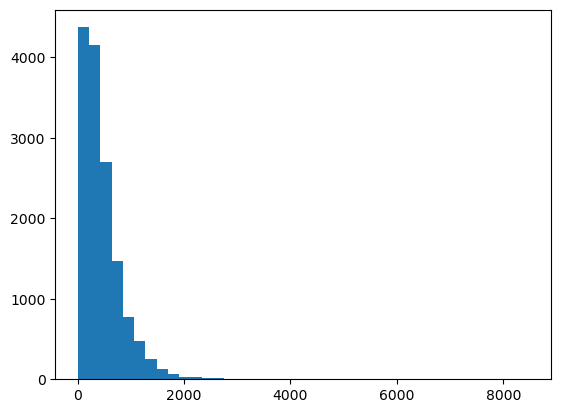

In [8]:
# distribution of number of transactions per consumer
trxn_counts = trxn_df.groupby('prism_consumer_id').count().prism_transaction_id
plt.hist(trxn_counts, bins=40)
plt.show()

In [9]:
# creating separate df for consumers with DQ_TARGET values
cons_df_no_na = cons_df[~cons_df['DQ_TARGET'].isna()]

In [10]:
def exclude_consumers(cons_df, acct_df, trxn_df):
    # minimum number of transactions
    trxn_counts = trxn_df.groupby('prism_consumer_id')['prism_transaction_id'].count()
    cons_at_least_2_trxns = set(trxn_counts[trxn_counts >= 2].index)

    # consumers with non zero balance
    balance_sum = acct_df.groupby('prism_consumer_id')['balance'].sum()
    cons_non_zero_balances = set(balance_sum[balance_sum != 0].index)

    # consumers with at least 1 credit and debit transaction
    credit_debit_counts = trxn_df.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
    credit_debit_counts.columns = ['num_credits', 'num_debits']
    cons_non_zero_credits = set(credit_debit_counts[credit_debit_counts.num_credits > 0].index)
    cons_non_zero_debits = set(credit_debit_counts[credit_debit_counts.num_debits > 0].index)
    cons_has_both_credits_debits = set(credit_debit_counts[((credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index)

    return cons_at_least_2_trxns.intersection(cons_non_zero_balances).intersection(cons_has_both_credits_debits)

In [11]:
def filter_time_window(df, days=None, months=None, years=None):
    """
    Filters transactions for each consumer over some time period
    Args:
        df (pd.DataFrame): dataframe to window over 
        days (int): number of days to go back
        months (int): number of months to go back
        years (int): number of years to go back
    Returns:
        pd.DataFrame: windowed dataframe
    """
    def filter_group(group):
        latest_date = group['posted_date'].max()  # Get latest transaction date per consumer
        cutoff_date = latest_date - pd.DateOffset(days=days or 0, months=months or 0, years=years or 0)
        return group[group['posted_date'] >= cutoff_date]  # Filter transactions

    return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)

In [12]:
def calc_balance_delta(rand_cons):
    """
    Calculating change in balance from first transaction to last transaction.
    Args:
        rand_cons (int): consumer id
    Returns:
        float: change in balance
    """
    rand_cons_acct_df = acct_df[acct_df.prism_consumer_id == rand_cons]
    rand_cons_trxn_df = trxn_df[trxn_df.prism_consumer_id == rand_cons].sort_values(by='posted_date')
    
    avg_balance_date = np.mean(rand_cons_acct_df.balance_date)
    balance = sum(rand_cons_acct_df.balance)
    
    before_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date <= avg_balance_date]
    after_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date > avg_balance_date]
    
    initial_balance = balance + sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "DEBIT"].amount) - \
                               sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "CREDIT"].amount) 
    ending_balance = balance + sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "CREDIT"].amount) - \
                               sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "DEBIT"].amount) 
    if initial_balance == 0:
        return 1
    else:
        return ((ending_balance - initial_balance) / initial_balance)

In [13]:
def create_inflows_outflows_features(trxn_df):
    # creating relevant outflows df with only expenses
    debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
    credits_not_income = ['SELF_TRANSFER', 'LOAN', 'REFUND'] # maybe TAX
    
    outflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'DEBIT') & (~trxn_df['category'].isin(debits_not_expenses))] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_agg_df.columns = ['OUTFLOWS_amt_' + col for col in outflows_agg_df.columns]
    inflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'CREDIT') & (~trxn_df['category'].isin(credits_not_income))] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_agg_df.columns = ['INFLOWS_amt_' + col for col in inflows_agg_df.columns]
    
    ### creating filtered window transactions dfs for inflows and outflows ###
    trxn_df_last_14_days = filter_time_window(trxn_df, days=14)
    trxn_df_last_30_days = filter_time_window(trxn_df, days=30)
    trxn_df_last_3_months = filter_time_window(trxn_df, months=3)
    trxn_df_last_6_months = filter_time_window(trxn_df, months=6)
    trxn_df_last_year = filter_time_window(trxn_df, years=1)

    # grabbing debits and credits across time periods
    debits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'DEBIT']
    debits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'DEBIT']
    debits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'DEBIT']
    debits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'DEBIT']
    debits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'DEBIT']
    
    credits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'CREDIT']
    credits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'CREDIT']
    credits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'CREDIT']
    credits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'CREDIT']
    credits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'CREDIT']

    # creating windowed expenses aggregate metrics
    outflows_last_14_days_agg_df = debits_df_last_14_days[~debits_df_last_14_days['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_14_days_agg_df.columns = ['OUTFLOWS_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]
    
    outflows_last_30_days_agg_df = debits_df_last_30_days[~debits_df_last_30_days['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_30_days_agg_df.columns = ['OUTFLOWS_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]
    
    outflows_last_3_months_agg_df = debits_df_last_3_months[~debits_df_last_3_months['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_3_months_agg_df.columns = ['OUTFLOWS_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]
    
    outflows_last_6_months_agg_df = debits_df_last_6_months[~debits_df_last_6_months['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_6_months_agg_df.columns = ['OUTFLOWS_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]
    
    outflows_last_year_agg_df = debits_df_last_year[~debits_df_last_year['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_year_agg_df.columns = ['OUTFLOWS_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

    # creating windowed inflows aggregate metrics
    inflows_last_14_days_agg_df = credits_df_last_14_days[~credits_df_last_14_days['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_14_days_agg_df.columns = ['INFLOWS_amt_last_14_days_' + col for col in inflows_last_14_days_agg_df.columns]
    
    inflows_last_30_days_agg_df = credits_df_last_30_days[~credits_df_last_30_days['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_30_days_agg_df.columns = ['INFLOWS_amt_last_30_days_' + col for col in inflows_last_30_days_agg_df.columns]
    
    inflows_last_3_months_agg_df = credits_df_last_3_months[~credits_df_last_3_months['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_3_months_agg_df.columns = ['INFLOWS_amt_last_3_months_' + col for col in inflows_last_3_months_agg_df.columns]
    
    inflows_last_6_months_agg_df = credits_df_last_6_months[~credits_df_last_6_months['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_6_months_agg_df.columns = ['INFLOWS_amt_last_6_months_' + col for col in inflows_last_6_months_agg_df.columns]
    
    inflows_last_year_agg_df = credits_df_last_year[~credits_df_last_year['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_year_agg_df.columns = ['INFLOWS_amt_last_year_' + col for col in inflows_last_year_agg_df.columns]

    all_outflows_dfs = [
                             outflows_agg_df, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df,
                             outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df,
                         ]

    all_inflows_dfs = [
                             inflows_agg_df, inflows_last_14_days_agg_df, inflows_last_30_days_agg_df,
                             inflows_last_3_months_agg_df, inflows_last_6_months_agg_df, inflows_last_year_agg_df,
                         ]

    return all_outflows_dfs, all_inflows_dfs

In [14]:
def create_binary_features(trxn_df):
    # creating flags for risky categories
    risky_categories = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # removed small dollar advance because no rows have it # TODO ADD OVERDRAFT
    trxn_category_table = trxn_df.pivot_table(index='prism_consumer_id', columns='category', values='amount', aggfunc='size', fill_value=0)
    
    gambling_flag_df = pd.DataFrame((trxn_category_table['GAMBLING'] > 0).astype(int)).reset_index()
    bnpl_flag_df = pd.DataFrame((trxn_category_table['BNPL'] > 0).astype(int)).reset_index()
    overdraft_flag_df = pd.DataFrame((trxn_category_table['OVERDRAFT'] > 0).astype(int)).reset_index()

    return [gambling_flag_df, bnpl_flag_df, overdraft_flag_df]

In [15]:
def read_other_data(balance_features_fp, category_features_fp):
    return pd.read_csv(balance_features_fp), pd.read_csv(category_features_fp)

In [16]:
def create_features_df(cons_df, acct_df, trxn_df, exclude=False):
    # if we want to do scoring exclusions, then have new cons_df with filtered consumers
    if exclude:
        kept_consumers = exclude_consumers(cons_df, acct_df, trxn_df)
        cons_df = cons_df[cons_df.prism_consumer_id.isin(kept_consumers)]
        
    # creating sum of balances feature
    sum_of_balance_df = pd.DataFrame(acct_df.groupby('prism_consumer_id')['balance'].sum()) \
                       .rename(columns={'balance': 'sum_of_balance'}).reset_index()

    # calculating credit_minus_debit feature
    credit_minus_debit_df = pd.DataFrame(trxn_df.groupby('prism_consumer_id') \
                            .apply(
                                lambda group: group.loc[group["credit_or_debit"] == "CREDIT", "amount"].sum()
                                            - group.loc[group["credit_or_debit"] == "DEBIT", "amount"].sum()
                                )).reset_index().rename(columns={0: "credit_minus_debit"})
    
    # create balance deltas
    balance_deltas = cons_df['prism_consumer_id'].apply(calc_balance_delta)
    balance_delta_df = pd.DataFrame(balance_deltas).reset_index() \
                                               .rename(columns=
                                                       {'index': 'prism_consumer_id', 
                                                        'prism_consumer_id': 'balance_delta'}
                                                      )

    # number of "income" sources for each consumer -- TODO: disregard credits that aren't actual income
    num_income_sources = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['category'].nunique()
    num_income_source_df = pd.DataFrame(num_income_sources).reset_index() \
                                    .rename(columns=
                                            {'index': 'prism_consumer_id', 
                                             'category': 'num_income_source'}
                                           )
    
    # number of accounts for each consumer
    num_accounts_df = acct_df.groupby('prism_consumer_id')['account_type'].count().reset_index() \
                             .rename(columns={'account_type': 'num_accounts'})
    
    all_outflows_dfs, all_inflows_dfs = create_inflows_outflows_features(trxn_df)
    binary_features_dfs = create_binary_features(trxn_df)
    balance_features_df, category_features_df = read_other_data('balance_features_2.csv', 'category_features_2.csv')
    balance_features_df = balance_features_df.drop(columns='Unnamed: 0')
    
    # merging outflows and inflows across time periods into features df
    features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                         [cons_df, sum_of_balance_df, credit_minus_debit_df, balance_delta_df, 
                          num_income_source_df, num_accounts_df, balance_features_df, category_features_df] + 
                         all_outflows_dfs + all_inflows_dfs + binary_features_dfs
                        )
    fill_na_cols = features_df.columns.difference(['DQ_TARGET'])
    features_df[fill_na_cols] = features_df[fill_na_cols].fillna(0)
 
    return features_df

In [17]:
features_df = create_features_df(cons_df, acct_df, trxn_df)

/tmp/ipykernel_396/2458608586.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_396/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_396/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future 

In [18]:
features_df.shape, 'GAMBLING' in features_df

((15000, 2060), True)

## Week 1 

**Single best feature to predict `DQ_TARGET`**

**Simple**
- sum of a consumer's `balance`
- `credit_score` seems like an obvious one
- sum of consumer's credit - sum of consumer's debit

In [10]:
# getting outflow (debit) and inflow (credit) categories
debit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'DEBIT']['category'].value_counts().index)
credit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'CREDIT']['category'].value_counts().index)

In [11]:
# creating sum of balances feature
sum_of_balance = pd.DataFrame(acct_df.groupby('prism_consumer_id')['balance'].sum()) \
                   .rename(columns={'balance': 'sum_of_balance'}).reset_index()
# use left outer join because we want features for all consumers even if it is NA for now
features_df = cons_df.merge(sum_of_balance, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

In [12]:
features_df

prism_consumer_id evaluation_date  credit_score  DQ_TARGET  \
0                      0      2021-09-01         726.0        0.0   
1                      1      2021-07-01         626.0        0.0   
2                      2      2021-05-01         680.0        0.0   
3                      3      2021-03-01         734.0        0.0   
4                      4      2021-10-01         676.0        0.0   
...                  ...             ...           ...        ...   
14995              14995      2022-03-08         655.0        NaN   
14996              14996      2022-01-15         625.0        NaN   
14997              14997      2022-01-31         688.0        NaN   
14998              14998      2022-03-08         722.0        NaN   
14999              14999      2022-02-12         751.0        NaN   

       sum_of_balance  
0              320.37  
1             3302.42  
2             2805.36  
3             7667.01  
4              394.55  
...               ...  
14995             NaN  
14996         6821.92  
14997             NaN  
14998             NaN  
14999         2000.94  

[15000 rows x 5 columns]

**Note: balances have different meaning based on account type, i.e. a credit card balance (outflow) vs checkings balance (inflow)**

#### Feature significance metrics

In [13]:
# r2 value for sum of balance feature #
# getting rows where neither features are NA
cons_sum_balance_df_no_na = features_df[(~features_df['DQ_TARGET'].isna()) & (~features_df['sum_of_balance'].isna())]
sum_balance_r2 = np.corrcoef(
        cons_sum_balance_df_no_na['DQ_TARGET'], 
        cons_sum_balance_df_no_na['sum_of_balance']
    )[0][1]**2
sum_balance_r2

0.0015695061588102432

In [14]:
# KS test pvalue for sum of balance feature
cons_sum_balance_dq0 = cons_sum_balance_df_no_na[cons_sum_balance_df_no_na["DQ_TARGET"] == 0.0]
cons_sum_balance_dq1 = cons_sum_balance_df_no_na[cons_sum_balance_df_no_na["DQ_TARGET"] == 1.0]
scipy.stats.ks_2samp(cons_sum_balance_dq0["sum_of_balance"], cons_sum_balance_dq1["sum_of_balance"]).pvalue

3.7555463168404585e-99

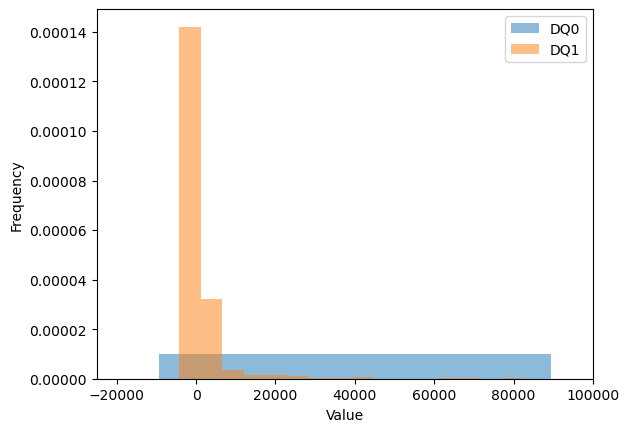

In [15]:
# plotting distributions of sum of balance for delinquent vs nondelinquent consumers
plt.hist(cons_sum_balance_dq0["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_sum_balance_dq1["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ1")

plt.xlim(-25000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

In [16]:
# r2 value of credit score feature
credit_score_r2 = np.corrcoef(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])[0][1]**2
credit_score_r2

0.06828206045598226

In [17]:
# point biserial value for credit score feature
credit_score_pbr = scipy.stats.pointbiserialr(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])
credit_score_pbr.pvalue

1.5212196313474402e-186

In [18]:
# calculating credit_minus_debit feature
credit_minus_debit = trxn_df.groupby('prism_consumer_id') \
                            .apply(
                                lambda group: group.loc[group["credit_or_debit"] == "CREDIT", "amount"].sum()
                                            - group.loc[group["credit_or_debit"] == "DEBIT", "amount"].sum()
                                )

/tmp/ipykernel_352/3454179167.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [19]:
# merging credit_minus_debit feature with features_df
features_df = features_df.merge(pd.DataFrame(credit_minus_debit).reset_index() \
                                          .rename(columns={0: "credit_minus_debit"}), 
                                                 on='prism_consumer_id',
                                                 how='left')
cons_credit_minus_debit_dq0 = features_df[features_df["DQ_TARGET"] == 0.0]
cons_credit_minus_debit_dq0_no_na = cons_credit_minus_debit_dq0[~cons_credit_minus_debit_dq0["credit_minus_debit"].isna()]
cons_credit_minus_debit_dq1 = features_df[features_df["DQ_TARGET"] == 1.0]
cons_credit_minus_debit_dq1_no_na = cons_credit_minus_debit_dq1[~cons_credit_minus_debit_dq1["credit_minus_debit"].isna()]
# calculating KS stat for credit_minus_debit feature for delinquent / nondelinquent consumers
scipy.stats.ks_2samp(cons_credit_minus_debit_dq0_no_na["credit_minus_debit"], cons_credit_minus_debit_dq1_no_na["credit_minus_debit"]).pvalue

1.643182347946055e-26

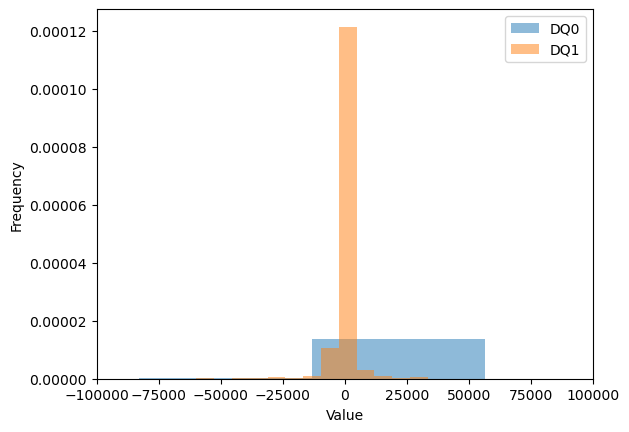

In [20]:
# # plotting distributions of credit_minus_debit for delinquent vs nondelinquent consumers
plt.hist(cons_credit_minus_debit_dq0["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_credit_minus_debit_dq1["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ1")

plt.xlim(-100000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

## Week 2

**New balance features**
- percent change in balance from earliest date to latest date
- account balance less than 0
  
**New income features**
- number of income transactions
- standard deviation of income
- number of income sources

In [25]:
# growth in balance for each consumer
balance_deltas = cons_df['prism_consumer_id'].apply(calc_balance_delta)

CPU times: user 5min 21s, sys: 2.58 s, total: 5min 24s
Wall time: 1min 53s


In [26]:
# creating balance_delta dataframe and merging with other features generated
balance_delta_df = pd.DataFrame(balance_deltas).reset_index() \
                                               .rename(columns=
                                                       {'index': 'prism_consumer_id', 
                                                        'prism_consumer_id': 'balance_delta'}
                                                      )
features_df = features_df.merge(balance_delta_df, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

In [27]:
# number of "income" sources for each consumer -- TODO: disregard credits that aren't actual income
num_income_sources = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['category'].nunique()
num_income_source_df = pd.DataFrame(num_income_sources).reset_index() \
                                .rename(columns=
                                        {'index': 'prism_consumer_id', 
                                         'category': 'num_income_source'}
                                       )
num_income_source_df

prism_consumer_id  num_income_source
0                      0                  7
1                      1                  6
2                      2                  8
3                      3                  9
4                      4                  5
...                  ...                ...
14471              14995                  6
14472              14996                  6
14473              14997                  5
14474              14998                 10
14475              14999                  6

[14476 rows x 2 columns]

In [29]:
# merging num_income_source and std_income features
features_df = features_df.merge(num_income_source_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(std_income_df, on='prism_consumer_id', how='left')
features_df

prism_consumer_id evaluation_date  credit_score  DQ_TARGET  \
0                      0      2021-09-01         726.0        0.0   
1                      1      2021-07-01         626.0        0.0   
2                      2      2021-05-01         680.0        0.0   
3                      3      2021-03-01         734.0        0.0   
4                      4      2021-10-01         676.0        0.0   
...                  ...             ...           ...        ...   
14995              14995      2022-03-08         655.0        NaN   
14996              14996      2022-01-15         625.0        NaN   
14997              14997      2022-01-31         688.0        NaN   
14998              14998      2022-03-08         722.0        NaN   
14999              14999      2022-02-12         751.0        NaN   

       sum_of_balance  credit_minus_debit  balance_delta  num_income_source  \
0              320.37             -521.59      -0.379272                7.0   
1             3302.42             1805.43       3.245659                6.0   
2             2805.36              430.13       0.203075                8.0   
3             7667.01             2795.24       0.481150                9.0   
4              394.55            -2543.60      -1.421784                5.0   
...               ...                 ...            ...                ...   
14995             NaN             -543.80       1.000000                6.0   
14996         6821.92              878.01       0.147716                6.0   
14997             NaN              163.74       1.000000                5.0   
14998             NaN              413.80       1.000000               10.0   
14999         2000.94              297.73       0.174805                6.0   

       INFLOWS_std  
0       494.177258  
1       383.271173  
2       609.314103  
3       844.130789  
4       368.114382  
...            ...  
14995   329.312758  
14996  1076.542076  
14997  2448.997302  
14998  1701.940647  
14999   394.697351  

[15000 rows x 9 columns]

In [30]:
# creating separate features df for non-NA DQ_TARGET rows
features_df_no_na = features_df[~features_df.DQ_TARGET.isna()]

**NEXT STEPS**
- begin considering category nuances
- more specific time recurrence

## Week 3

#### Feature Creation

In [34]:
# creating relevant outflows df with only expenses
debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
credits_not_income = ['SELF_TRANSFER', 'LOAN', 'REFUND'] # maybe TAX

outflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'DEBIT') & (~trxn_df['category'].isin(debits_not_expenses))] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_agg_df.columns = ['OUTFLOWS_amt_' + col for col in outflows_agg_df.columns]
inflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'CREDIT') & (~trxn_df['category'].isin(credits_not_income))] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_agg_df.columns = ['INFLOWS_amt_' + col for col in inflows_agg_df.columns]

In [35]:
### creating filtered window transactions dfs for inflows and outflows ###
trxn_df_last_14_days = filter_time_window(trxn_df, days=14)
trxn_df_last_30_days = filter_time_window(trxn_df, days=30)
trxn_df_last_3_months = filter_time_window(trxn_df, months=3)
trxn_df_last_6_months = filter_time_window(trxn_df, months=6)
trxn_df_last_year = filter_time_window(trxn_df, years=1)

/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated o

In [36]:
# grabbing debits and credits across time periods
debits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'DEBIT']
debits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'DEBIT']
debits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'DEBIT']
debits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'DEBIT']
debits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'DEBIT']

credits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'CREDIT']
credits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'CREDIT']
credits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'CREDIT']
credits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'CREDIT']
credits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'CREDIT']

In [37]:
# creating windowed expenses aggregate metrics
outflows_last_14_days_agg_df = debits_df_last_14_days[~debits_df_last_14_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_14_days_agg_df.columns = ['OUTFLOWS_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]

outflows_last_30_days_agg_df = debits_df_last_30_days[~debits_df_last_30_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_30_days_agg_df.columns = ['OUTFLOWS_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]

outflows_last_3_months_agg_df = debits_df_last_3_months[~debits_df_last_3_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_3_months_agg_df.columns = ['OUTFLOWS_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]

outflows_last_6_months_agg_df = debits_df_last_6_months[~debits_df_last_6_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_6_months_agg_df.columns = ['OUTFLOWS_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]

outflows_last_year_agg_df = debits_df_last_year[~debits_df_last_year['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_year_agg_df.columns = ['OUTFLOWS_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

In [38]:
# creating windowed expenses aggregate metrics
inflows_last_14_days_agg_df = credits_df_last_14_days[~credits_df_last_14_days['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_14_days_agg_df.columns = ['INFLOWS_amt_last_14_days_' + col for col in inflows_last_14_days_agg_df.columns]

inflows_last_30_days_agg_df = credits_df_last_30_days[~credits_df_last_30_days['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_30_days_agg_df.columns = ['INFLOWS_amt_last_30_days_' + col for col in inflows_last_30_days_agg_df.columns]

inflows_last_3_months_agg_df = credits_df_last_3_months[~credits_df_last_3_months['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_3_months_agg_df.columns = ['INFLOWS_amt_last_3_months_' + col for col in inflows_last_3_months_agg_df.columns]

inflows_last_6_months_agg_df = credits_df_last_6_months[~credits_df_last_6_months['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_6_months_agg_df.columns = ['INFLOWS_amt_last_6_months_' + col for col in inflows_last_6_months_agg_df.columns]

inflows_last_year_agg_df = credits_df_last_year[~credits_df_last_year['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_year_agg_df.columns = ['INFLOWS_amt_last_year_' + col for col in inflows_last_year_agg_df.columns]

In [39]:
# combining outflows across time periods into features df
features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                     [
                         features_df, outflows_agg_df, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df,
                         outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df,
                     ])

In [40]:
# combining inflows across time periods into features df
features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                     [
                         features_df, inflows_agg_df, inflows_last_14_days_agg_df, inflows_last_30_days_agg_df,
                         inflows_last_3_months_agg_df, inflows_last_6_months_agg_df, inflows_last_year_agg_df,
                     ])

In [41]:
# creating flags for risky categories
risky_categories = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # removed small dollar advance because no rows have it # TODO ADD OVERDRAFT
trxn_category_table = trxn_df.pivot_table(index='prism_consumer_id', columns='category', values='amount', aggfunc='size', fill_value=0)
gambling_flag_df = pd.DataFrame((trxn_category_table['GAMBLING'] > 0).astype(int)).reset_index()
bnpl_flag_df = pd.DataFrame((trxn_category_table['BNPL'] > 0).astype(int)).reset_index()
overdraft_flag_df = pd.DataFrame((trxn_category_table['OVERDRAFT'] > 0).astype(int)).reset_index()

In [42]:
# combining risky flags into features df
features_df = features_df.merge(gambling_flag_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(bnpl_flag_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(overdraft_flag_df, on='prism_consumer_id', how='left')
features_df

prism_consumer_id evaluation_date  credit_score  DQ_TARGET  \
0                      0      2021-09-01         726.0        0.0   
1                      1      2021-07-01         626.0        0.0   
2                      2      2021-05-01         680.0        0.0   
3                      3      2021-03-01         734.0        0.0   
4                      4      2021-10-01         676.0        0.0   
...                  ...             ...           ...        ...   
14995              14995      2022-03-08         655.0        NaN   
14996              14996      2022-01-15         625.0        NaN   
14997              14997      2022-01-31         688.0        NaN   
14998              14998      2022-03-08         722.0        NaN   
14999              14999      2022-02-12         751.0        NaN   

       sum_of_balance  credit_minus_debit  balance_delta  num_income_source  \
0              320.37             -521.59      -0.379272                7.0   
1             3302.42             1805.43       3.245659                6.0   
2             2805.36              430.13       0.203075                8.0   
3             7667.01             2795.24       0.481150                9.0   
4              394.55            -2543.60      -1.421784                5.0   
...               ...                 ...            ...                ...   
14995             NaN             -543.80       1.000000                6.0   
14996         6821.92              878.01       0.147716                6.0   
14997             NaN              163.74       1.000000                5.0   
14998             NaN              413.80       1.000000               10.0   
14999         2000.94              297.73       0.174805                6.0   

       INFLOWS_std  OUTFLOWS_amt_mean  ...  INFLOWS_amt_last_6_months_min  \
0       494.177258          39.480227  ...                           0.02   
1       383.271173          41.397870  ...                           0.07   
2       609.314103          36.461969  ...                           0.02   
3       844.130789          51.027282  ...                           0.12   
4       368.114382          45.212308  ...                           0.02   
...            ...                ...  ...                            ...   
14995   329.312758          50.569211  ...                          13.13   
14996  1076.542076          87.960888  ...                           0.01   
14997  2448.997302         106.366888  ...                           0.82   
14998  1701.940647          56.062056  ...                           9.99   
14999   394.697351          83.175202  ...                           3.65   

       INFLOWS_amt_last_6_months_max  INFLOWS_amt_last_year_mean  \
0                            1400.00                  419.119310   
1                            1400.00                  509.625161   
2                            4694.48                  227.158437   
3                            4398.00                  493.122308   
4                             760.00                  431.771786   
...                              ...                         ...   
14995                        1321.53                  350.099722   
14996                        2000.00                  525.609667   
14997                        1734.41                  355.277015   
14998                        3084.03                  757.206183   
14999                        2000.00                  396.238780   

       INFLOWS_amt_last_year_std  INFLOWS_amt_last_year_median  \
0                     523.059901                         49.25   
1                     476.805740                        747.81   
2                     868.028778                          0.42   
3                     942.228631                          0.77   
4                     378.225565                        460.00   
...                          ...                           ...   
14995                 363

In [43]:
# what it should be: ((15000, 72), True)
features_df.shape, 'GAMBLING' in features_df.columns

((15000, 72), True)

In [44]:
# pulling in balance features (aman) and category features (tracy)
balance_features_df = pd.read_csv('balance_ftrs.csv')
category_features_df = pd.read_csv('category_features.csv')

In [45]:
final_features_df = features_df.merge(balance_features_df, on='prism_consumer_id', how='left')

In [46]:
final_features_df = final_features_df.merge(category_features_df, on='prism_consumer_id', how='left')

In [47]:
final_features_df = final_features_df.drop(columns=['evaluation_date', 'credit_score']) # drop credit score
final_features_df = final_features_df[~final_features_df['DQ_TARGET'].isna()].fillna(0)

In [48]:
final_features_df

DQ_TARGET  sum_of_balance  credit_minus_debit  balance_delta  \
0            0.0          320.37             -521.59      -0.379272   
1            0.0         3302.42             1805.43       3.245659   
2            0.0         2805.36              430.13       0.203075   
3            0.0         7667.01             2795.24       0.481150   
4            0.0          394.55            -2543.60      -1.421784   
...          ...             ...                 ...            ...   
13995        0.0         1028.80              844.51       4.582506   
13996        0.0        11495.77             -321.80      -0.027231   
13997        0.0         2396.85               47.76       0.020331   
13998        0.0        14835.71             9486.36       1.773367   
13999        0.0          -41.00            -1189.10      -1.035711   

       num_income_source  INFLOWS_std  OUTFLOWS_amt_mean  OUTFLOWS_amt_std  \
0                    7.0   494.177258          39.480227         67.764723   
1                    6.0   383.271173          41.397870        124.649452   
2                    8.0   609.314103          36.461969         66.402281   
3                    9.0   844.130789          51.027282         68.022199   
4                    5.0   368.114382          45.212308         58.783697   
...                  ...          ...                ...               ...   
13995                4.0    72.440995           0.000000          0.000000   
13996                9.0   680.179827          90.099577        309.556912   
13997                6.0   562.410612         825.034444       1207.119639   
13998                8.0  1559.836439         106.514343        528.716026   
13999                7.0   678.347465         115.622648        295.890738   

       OUTFLOWS_amt_median  OUTFLOWS_amt_min  ...  PENSION_last_6_months_std  \
0                   20.000              1.08  ...                   0.000000   
1                   19.280              0.92  ...                   0.000000   
2                   15.335              0.00  ...                   0.000000   
3                   27.600              0.72  ...                   0.000000   
4                   25.870              0.00  ...                   0.000000   
...                    ...               ...  ...                        ...   
13995                0.000              0.00  ...                   0.000000   
13996               35.000              1.00  ...                   0.000000   
13997               87.030              0.90  ...                   0.000000   
13998               10.000              0.01  ...                  49.074773   
13999               35.000              1.71  ...                   0.000000   

       PENSION_last_6_months_max  PENSION_last_6_months_min  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        0.0   
...                          ...                        ...   
13995                        0.0                        0.0   
13996                        0.0                        0.0   
13997                        0.0                        0.0   
13998                     1527.0                     1442.0   
13999                        0.0                        0.0   

       PENSION_last_6_months_count  PENSION_last_year_mean  \
0                              0.0                0.000000   
1                              0.0                0.000000   
2                              0.0                0.000000   
3                              0.0                0.000000   
4                              0.0                0.000000   
...                            ...                     ...   
13995                          0.0                0.000000   
139

In [49]:
# (12000, 1895), True
final_features_df.shape, 'GAMBLING' in final_features_df.columns

((12000, 1894), True)

#### Model Building

In [19]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier # pip install
from lightgbm import LGBMClassifier # pip install
from xgboost import XGBClassifier 

import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type):
    """Trains and evaluates the specified model."""

    def get_metrics(X, y):
        # Predict on training data
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else y_pred
    
        # Evaluation Metrics
        metrics = {
            "ROC_AUC": roc_auc_score(y, y_prob),
            "Accuracy": accuracy_score(y, y_pred),
            "Precision": precision_score(y, y_pred),
            "Recall": recall_score(y, y_pred),
            "F1-Score": f1_score(y, y_pred),
            # "Confusion Matrix": confusion_matrix(y, y_pred)
        }

        # Confusion Matrix
        cm = confusion_matrix(y, y_pred)
        
        # Plot Confusion Matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix ({model_type})")
        plt.show()
    
        # Print Metrics
        print(f'{model_type} metrics:')
        for metric, value in metrics.items():
            print(f"\t{metric}: {value}")

        return metrics
    
    models = {
        "HistGB": HistGradientBoostingClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0),
        "LightGBM": LGBMClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1)
    }
    
    if model_type not in models:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from {list(models.keys())}")
    
    model = models[model_type]

    # Train model and track training time
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    print(f"Training Time: {end - start:.4f} seconds")

    train_metrics = get_metrics(X_train, y_train)
    test_metrics = get_metrics(X_test, y_test)

    return model, test_metrics

In [21]:
def split_data(final_features_df, test_size=0.25):
    # currently using train test split -- need to start using train val test split
    X_train, X_test, y_train, y_test = train_test_split(
        final_features_df.drop(columns=['prism_consumer_id', 'DQ_TARGET', 'evaluation_date', 'credit_score']), 
        final_features_df['DQ_TARGET'], test_size=test_size, stratify=final_features_df['DQ_TARGET']
    )
    return X_train, X_test, y_train, y_test

In [22]:
# with open('features_df.pkl', 'wb') as f:
#     pickle.dump(features_df, f)
# with open('../../q2data/features_df.pkl', 'rb') as f:
#     features_df = pickle.load(f)

In [23]:
features_df_DQ_no_na = features_df[~features_df.DQ_TARGET.isna()]
X_train, X_test, y_train, y_test = split_data(features_df_DQ_no_na)

##### Model Building Helper Functions

In [44]:
def fit_model(X_train, y_train, model_type):
    """
    Fits a machine learning model based on the specified type.

    Args:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): True training values
        model_type (str): Type of model to fit ('log_reg', REST TBD 'random_forest', 'xgboost', 'svm', 'multnb').

    Returns:
        model: Trained model.

    Saves:
        {model_type}_{train/test}_cm.png: confusion matrix of model's accuracy for train and test predictions.
    """

    ###############################
    ## MODEL TRAIN BY MODEL TYPE ##
    ###############################
    
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train, y_train) # TODO: hyperparameter config
    return model

In [45]:
def predict(X, y, model, proba=True, le=None):
    """
    Makes predictions using the trained model and evaluates accuracy.

    Args:
        X (pd.DataFrame): Features for prediction.
        y (pd.Series): True labels to compare predictions.
        model: Trained model (LogisticRegression, RandomForestClassifier, or XGBClassifier).
        proba (bool): True if you want to return the prediction probabilities, else False
        le (LabelEncoder, optional): Label encoder, required for 'xgboost' model.

    Returns:
        preds (numpy.ndarray): Predicted labels.
    """
    preds = model.predict(X)
    if proba:
        preds_proba = model.predict_proba(X)
        return preds, preds_proba
    return preds
    
    # if isinstance(model, XGBClassifier):
    #     preds_encoded = model.predict(X)
    #     preds = le.inverse_transform(preds_encoded)    

In [46]:
def evaluate_model(y, y_pred, y_pred_proba):
    # train metrics
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

In [65]:
# train model
model = fit_model(X_train, y_train, 'log_reg')

# predict train set
y_pred_train, y_pred_proba_train = predict(X_train, y_train, model)
y_pred_proba_train = y_pred_proba_train[:, 1]

# predict test set
y_pred_test, y_pred_proba_test = predict(X_test, y_test, model)
y_pred_proba_test = y_pred_proba_test[:, 1]

In [66]:
# train metrics
evaluate_model(y_train, y_pred_train, y_pred_proba_train)

ROC AUC Score: 0.5041
Accuracy: 0.5799

Confusion Matrix:
[[4794 3458]
 [ 323  425]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.72      8252
         1.0       0.11      0.57      0.18       748

    accuracy                           0.58      9000
   macro avg       0.52      0.57      0.45      9000
weighted avg       0.87      0.58      0.67      9000



In [67]:
# test metrics
evaluate_model(y_test, y_pred_test, y_pred_proba_test)

ROC AUC Score: 0.4973
Accuracy: 0.5533

Confusion Matrix:
[[1536 1206]
 [ 134  124]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.56      0.70      2742
         1.0       0.09      0.48      0.16       258

    accuracy                           0.55      3000
   macro avg       0.51      0.52      0.43      3000
weighted avg       0.85      0.55      0.65      3000



In [68]:
feature_weights = list(zip(model.coef_[0], model.feature_names_in_))
feature_weights.sort(reverse=True, key=lambda x: abs(x[0]))

### Week 5

#### Standardization

In [39]:
# Standardize features dataset
# features i should not standardize -- all binary features (GAMBLING, BNPL, OVERDRAFT)

In [24]:
def standardize(X_train, *args):
    # instantiate StandardScaler() to standardize features, excluding binary features
    scaler = StandardScaler()
    exclude_columns_standardize = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # binary features that shouldn't be standardized
    standardize_features = X_train.columns.difference(exclude_columns_standardize)
    
    transformer = ColumnTransformer([
        ('std_scaler', StandardScaler(), standardize_features)  # Standardize all except excluded ones
    ], remainder='passthrough')
    
    X_train_standardized = transformer.fit_transform(X_train)
    X_train_standardized = pd.DataFrame(X_train_standardized, columns=list(standardize_features) + exclude_columns_standardize)

    X_datasets = [X_train_standardized]
    
    # standardize test features
    for X_dataset in args:
        X_test_standardized = transformer.transform(X_dataset)
        X_test_standardized = pd.DataFrame(X_test_standardized, columns=list(standardize_features) + exclude_columns_standardize)
        X_datasets.append(X_test_standardized)

    return X_datasets

In [25]:
# standardize train and test sets
X_train_standardized, X_test_standardized = standardize(X_train, X_test)

Training Time: 7.0044 seconds


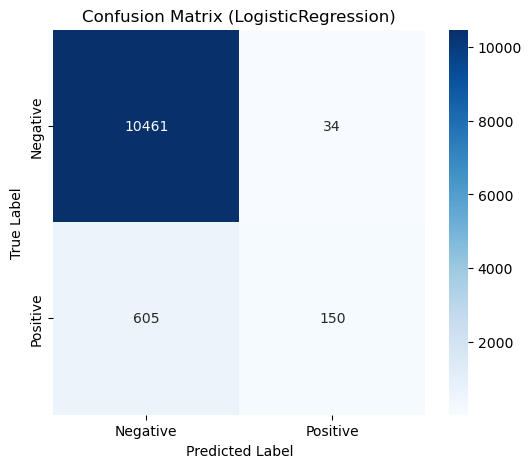

LogisticRegression metrics:
	ROC_AUC: 0.9097452271501093
	Accuracy: 0.9432
	Precision: 0.8152173913043478
	Recall: 0.1986754966887417
	F1-Score: 0.3194888178913738


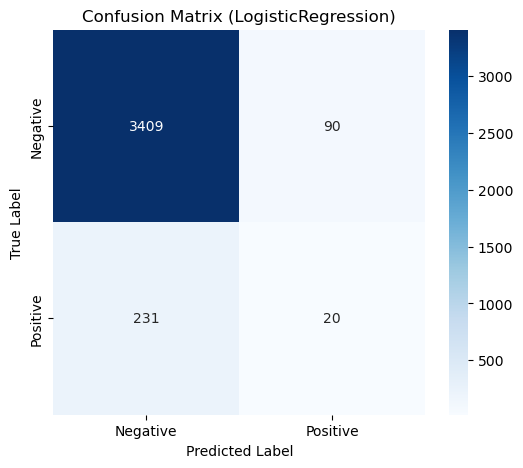

LogisticRegression metrics:
	ROC_AUC: 0.6995436373966836
	Accuracy: 0.9144
	Precision: 0.18181818181818182
	Recall: 0.0796812749003984
	F1-Score: 0.11080332409972299


In [37]:
model, test_metrics = train_and_evaluate(X_train_standardized, y_train, X_test_standardized, y_test, 'LogisticRegression')

Training Time: 95.7074 seconds


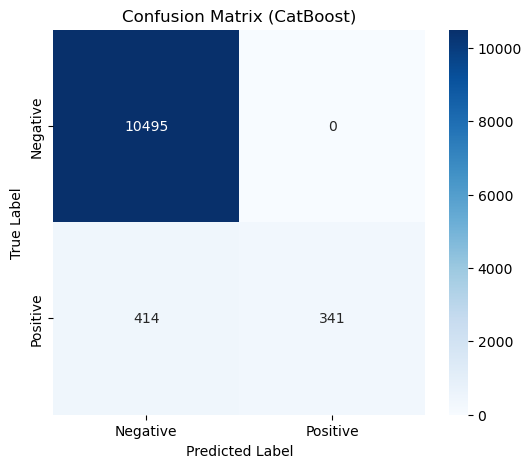

CatBoost metrics:
	ROC_AUC: 0.9890243540758923
	Accuracy: 0.9632
	Precision: 1.0
	Recall: 0.45165562913907287
	F1-Score: 0.6222627737226277


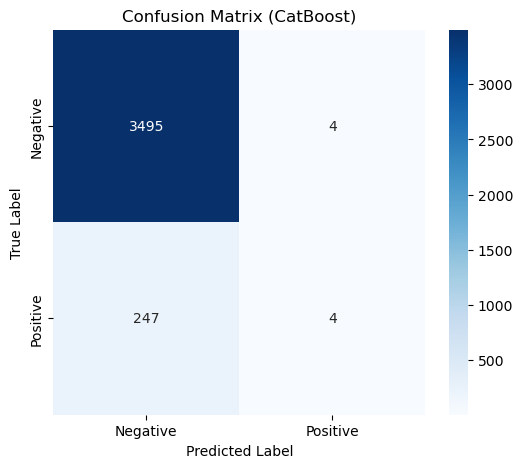

CatBoost metrics:
	ROC_AUC: 0.7787364403489215
	Accuracy: 0.9330666666666667
	Precision: 0.5
	Recall: 0.01593625498007968
	F1-Score: 0.03088803088803089


In [38]:
model, test_metrics = train_and_evaluate(X_train_standardized, y_train, X_test_standardized, y_test, 'CatBoost')

#### Feature Selection
- L1 lasso regularization
    - skip redundant features
- point biserial correlation
- recursive feature elimination (uses model coefficients w/o lasso)
     - takes a long time, starts with the initial subset of features and removes least important features recursively until target is reached

##### L1 lasso feature selection

In [26]:
def get_lasso_features(X_train, y_train):
    model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1) # can test different Cs
    model_l1.fit(X_train, y_train)

    feature_coefs = list(zip(model_l1.feature_names_in_, model_l1.coef_[0]))
    feature_coefs.sort(key=lambda x: abs(x[1]), reverse=True)
    return feature_coefs

In [27]:
def extract_category(feature_name):
    """Extracts the category from a feature name using regex."""
    match = re.match(r'^([A-Z]+(?:_[A-Z]+)*)', feature_name)
    return match.group(1) if match else feature_name 

In [28]:
def select_top_features(features, max_features, limit=2):
    category_dict = defaultdict(list)

    # Organize features by category
    for feature, coef in features:
        category = extract_category(feature)  # Extract category using regex
        category_dict[category].append((feature, coef))

    # Sort each category by absolute coefficient value (descending)
    for category in category_dict:
        category_dict[category].sort(key=lambda item: abs(item[1]), reverse=True)

    # Select top max_features, allowing up to 2 features per category
    selected_features = []
    category_counts = defaultdict(int)  # Track how many features have been selected per category

    # Flatten sorted features by absolute importance while respecting category limits
    sorted_features = sorted(
        [feat for feats in category_dict.values() for feat in feats], 
        key=lambda item: abs(item[1]), reverse=True
    )

    for feature, coef in sorted_features:
        category = extract_category(feature)
        if len(selected_features) < max_features and category_counts[category] < limit:
            selected_features.append((feature, coef))
            category_counts[category] += 1

    return selected_features

In [29]:
def get_feature_selection_datasets(X, selected_features):
    return X[np.array(selected_features)[:, 0]]

**Feature selection experiment**

In [36]:
max_features_lst = list(range(50, 2051, 100))
X_train, X_test, y_train, y_test = split_data(features_df_DQ_no_na, test_size=0.5)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)
X_train_standardized, X_val_standardized, X_test_standardized = standardize(X_train, X_val, X_test)

Testing 50 features...
Training Time: 0.4168 seconds


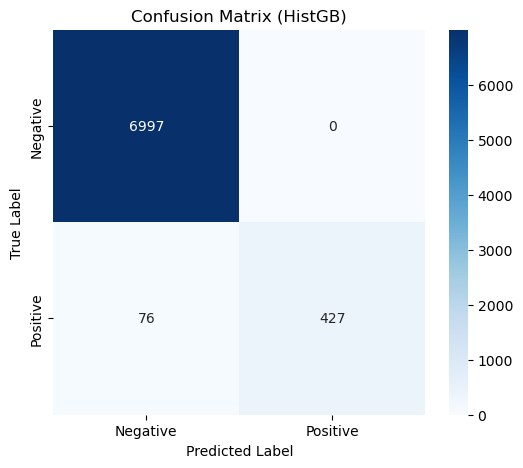

HistGB metrics:
	ROC_AUC: 0.9980161904093519
	Accuracy: 0.9898666666666667
	Precision: 1.0
	Recall: 0.8489065606361829
	F1-Score: 0.9182795698924732


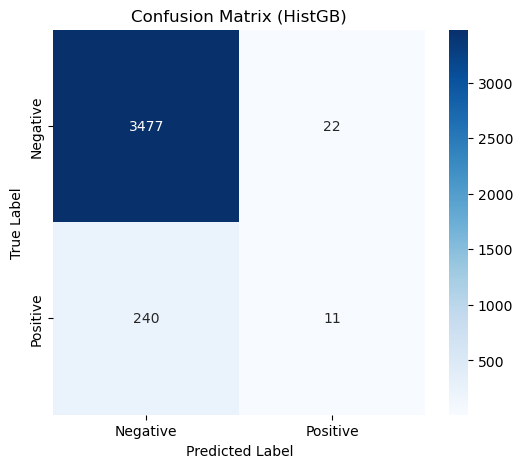

HistGB metrics:
	ROC_AUC: 0.7344978474214031
	Accuracy: 0.9301333333333334
	Precision: 0.3333333333333333
	Recall: 0.043824701195219126
	F1-Score: 0.07746478873239436
Training Time: 3.5265 seconds


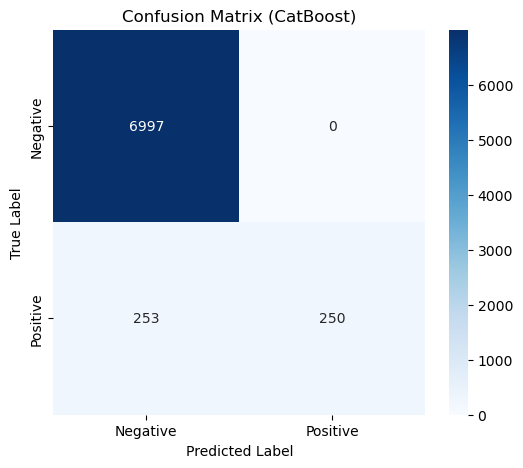

CatBoost metrics:
	ROC_AUC: 0.9874160780635609
	Accuracy: 0.9662666666666667
	Precision: 1.0
	Recall: 0.4970178926441352
	F1-Score: 0.6640106241699867


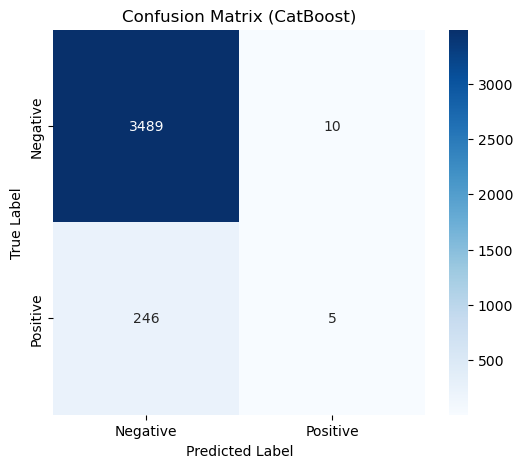

CatBoost metrics:
	ROC_AUC: 0.7507261608040545
	Accuracy: 0.9317333333333333
	Precision: 0.3333333333333333
	Recall: 0.0199203187250996
	F1-Score: 0.03759398496240601
[LightGBM] [Info] Number of positive: 503, number of negative: 6997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067067 -> initscore=-2.632647
[LightGBM] [Info] Start training from score -2.632647
Training Time: 0.2874 seconds


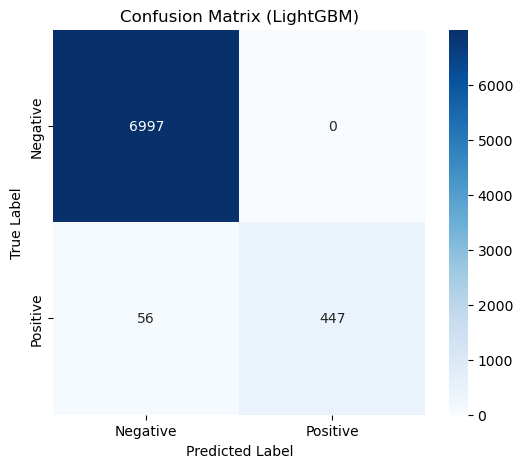

LightGBM metrics:
	ROC_AUC: 0.9980663397065087
	Accuracy: 0.9925333333333334
	Precision: 1.0
	Recall: 0.8886679920477137
	F1-Score: 0.9410526315789474


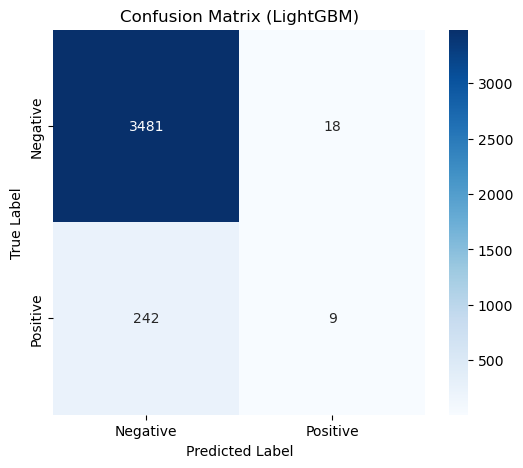

LightGBM metrics:
	ROC_AUC: 0.7402450785597252
	Accuracy: 0.9306666666666666
	Precision: 0.3333333333333333
	Recall: 0.035856573705179286
	F1-Score: 0.06474820143884892


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:15:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.3098 seconds


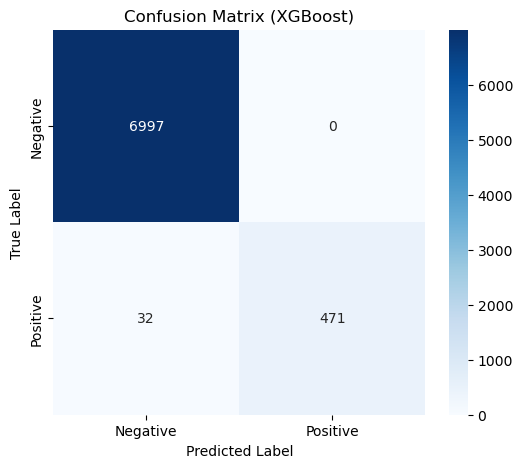

XGBoost metrics:
	ROC_AUC: 0.9991146447028846
	Accuracy: 0.9957333333333334
	Precision: 1.0
	Recall: 0.9363817097415507
	F1-Score: 0.9671457905544147


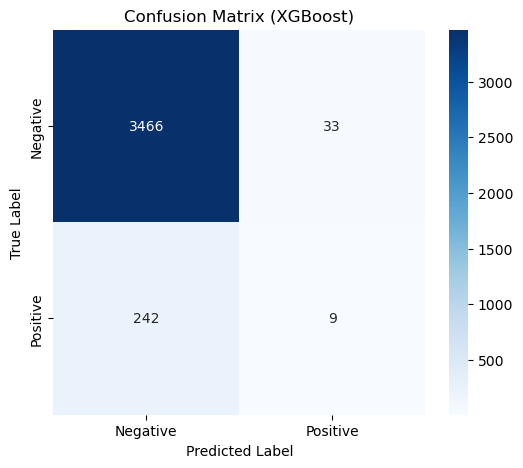

XGBoost metrics:
	ROC_AUC: 0.7184739179890895
	Accuracy: 0.9266666666666666
	Precision: 0.21428571428571427
	Recall: 0.035856573705179286
	F1-Score: 0.06143344709897611
Training Time: 0.4752 seconds


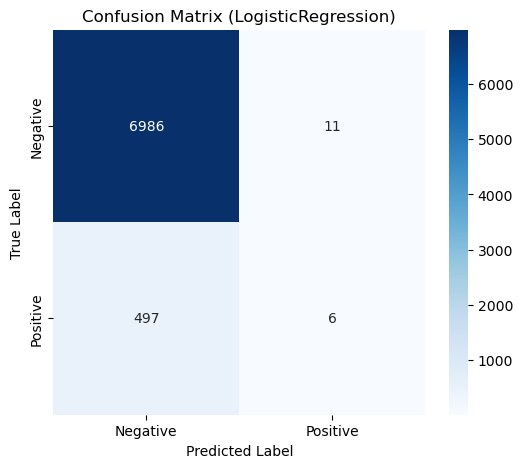

LogisticRegression metrics:
	ROC_AUC: 0.7946143348569438
	Accuracy: 0.9322666666666667
	Precision: 0.35294117647058826
	Recall: 0.011928429423459244
	F1-Score: 0.023076923076923078


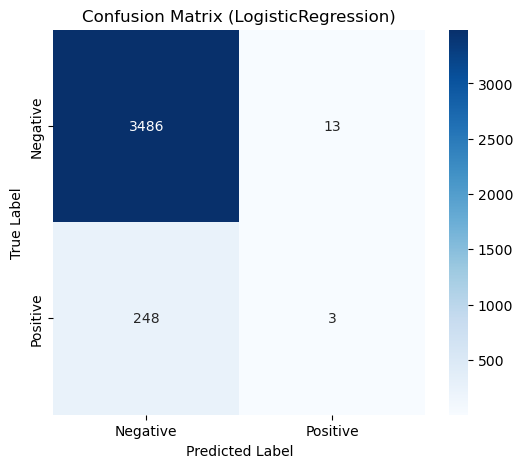

LogisticRegression metrics:
	ROC_AUC: 0.72881324089182
	Accuracy: 0.9304
	Precision: 0.1875
	Recall: 0.01195219123505976
	F1-Score: 0.02247191011235955
Testing 150 features...
Training Time: 0.6721 seconds


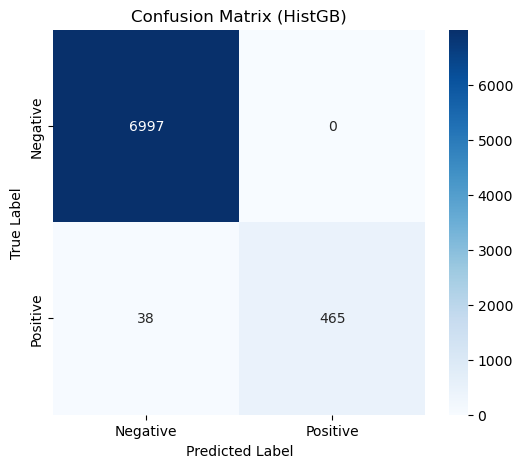

HistGB metrics:
	ROC_AUC: 0.998855516323241
	Accuracy: 0.9949333333333333
	Precision: 1.0
	Recall: 0.9244532803180915
	F1-Score: 0.9607438016528925


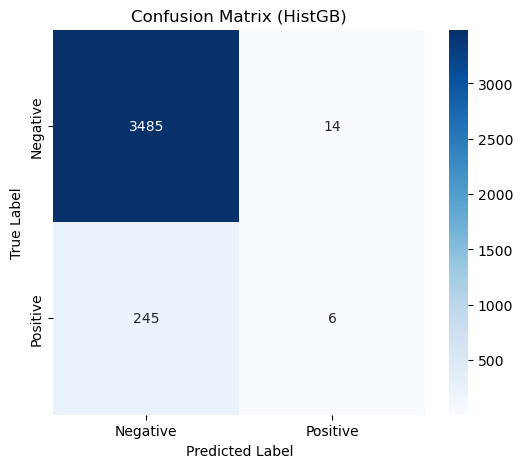

HistGB metrics:
	ROC_AUC: 0.7405285972429232
	Accuracy: 0.9309333333333333
	Precision: 0.3
	Recall: 0.02390438247011952
	F1-Score: 0.04428044280442804
Training Time: 6.4311 seconds


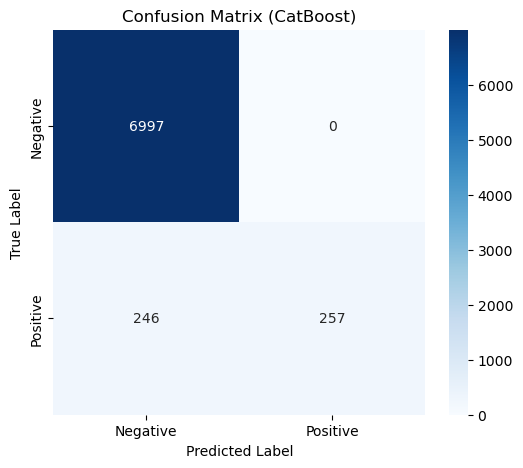

CatBoost metrics:
	ROC_AUC: 0.987670944463276
	Accuracy: 0.9672
	Precision: 1.0
	Recall: 0.510934393638171
	F1-Score: 0.6763157894736842


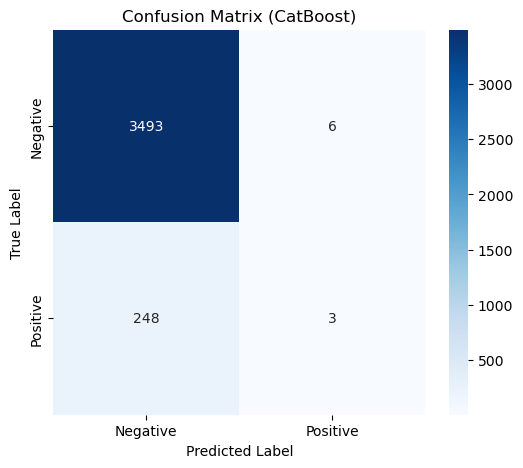

CatBoost metrics:
	ROC_AUC: 0.7680726081100007
	Accuracy: 0.9322666666666667
	Precision: 0.3333333333333333
	Recall: 0.01195219123505976
	F1-Score: 0.023076923076923078
[LightGBM] [Info] Number of positive: 503, number of negative: 6997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27053
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067067 -> initscore=-2.632647
[LightGBM] [Info] Start training from score -2.632647
Training Time: 0.5071 seconds


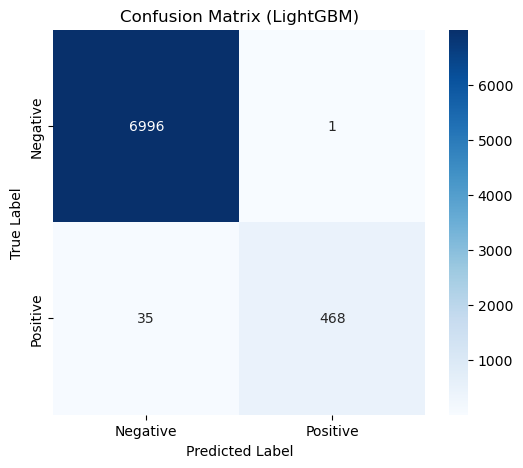

LightGBM metrics:
	ROC_AUC: 0.9989089331383431
	Accuracy: 0.9952
	Precision: 0.997867803837953
	Recall: 0.9304174950298211
	F1-Score: 0.9629629629629629


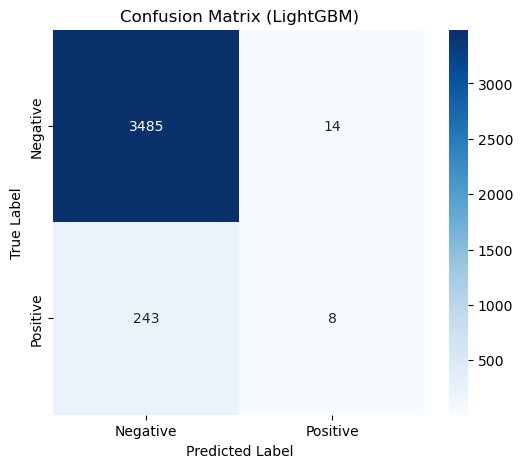

LightGBM metrics:
	ROC_AUC: 0.7426828837835284
	Accuracy: 0.9314666666666667
	Precision: 0.36363636363636365
	Recall: 0.03187250996015936
	F1-Score: 0.05860805860805861


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:15:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.5812 seconds


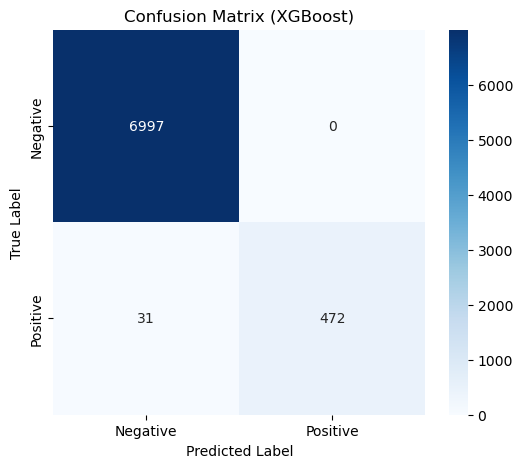

XGBoost metrics:
	ROC_AUC: 0.9995813315050387
	Accuracy: 0.9958666666666667
	Precision: 1.0
	Recall: 0.9383697813121272
	F1-Score: 0.9682051282051282


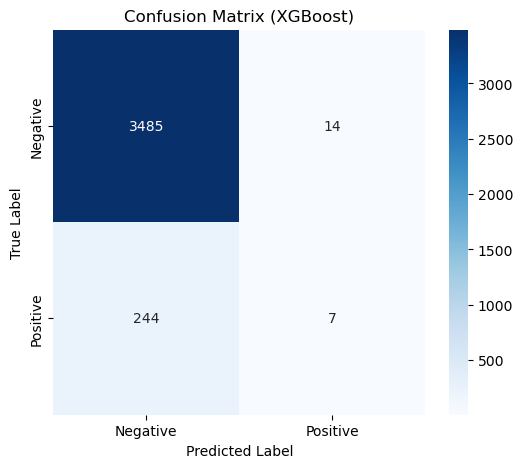

XGBoost metrics:
	ROC_AUC: 0.7344192820031679
	Accuracy: 0.9312
	Precision: 0.3333333333333333
	Recall: 0.027888446215139442
	F1-Score: 0.051470588235294115
Training Time: 0.5436 seconds


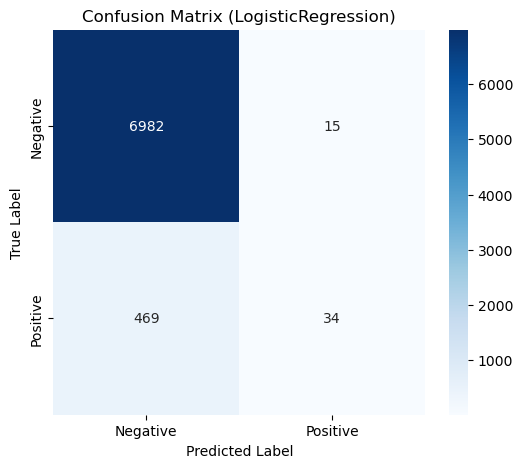

LogisticRegression metrics:
	ROC_AUC: 0.8259478430261649
	Accuracy: 0.9354666666666667
	Precision: 0.6938775510204082
	Recall: 0.06759443339960239
	F1-Score: 0.12318840579710146


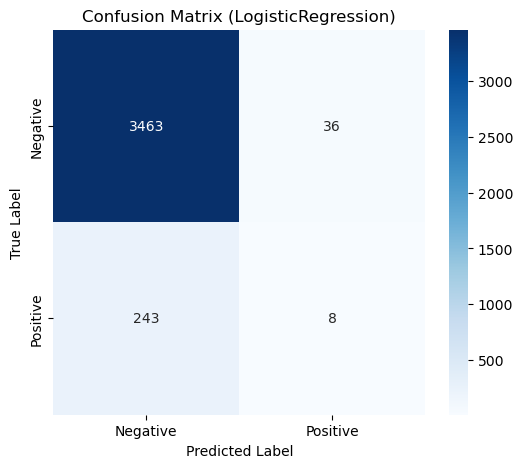

LogisticRegression metrics:
	ROC_AUC: 0.7179159896566919
	Accuracy: 0.9256
	Precision: 0.18181818181818182
	Recall: 0.03187250996015936
	F1-Score: 0.05423728813559322
Testing 250 features...
Training Time: 0.8989 seconds


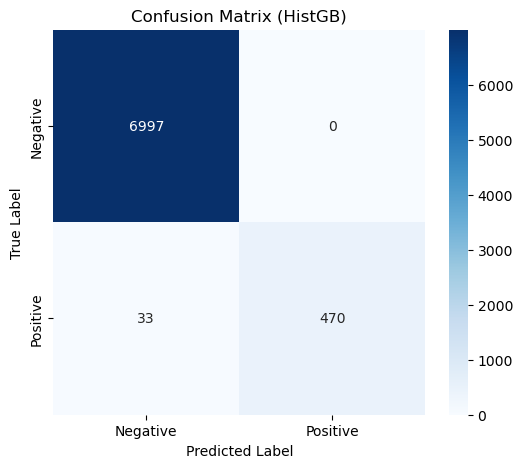

HistGB metrics:
	ROC_AUC: 0.9990359401402078
	Accuracy: 0.9956
	Precision: 1.0
	Recall: 0.9343936381709742
	F1-Score: 0.9660842754367934


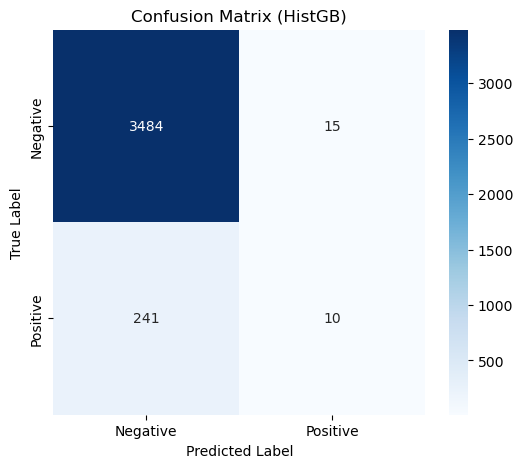

HistGB metrics:
	ROC_AUC: 0.7482712761415043
	Accuracy: 0.9317333333333333
	Precision: 0.4
	Recall: 0.0398406374501992
	F1-Score: 0.07246376811594203
Training Time: 10.3451 seconds


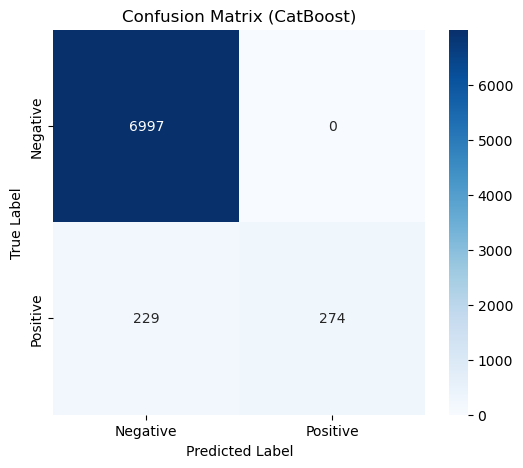

CatBoost metrics:
	ROC_AUC: 0.9875750499148881
	Accuracy: 0.9694666666666667
	Precision: 1.0
	Recall: 0.5447316103379721
	F1-Score: 0.7052767052767053


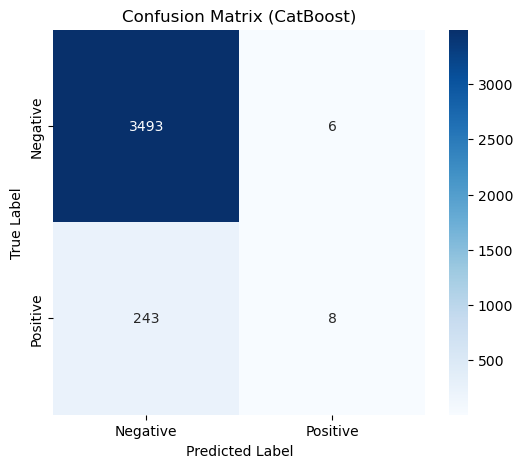

CatBoost metrics:
	ROC_AUC: 0.7707347232960129
	Accuracy: 0.9336
	Precision: 0.5714285714285714
	Recall: 0.03187250996015936
	F1-Score: 0.06037735849056604
[LightGBM] [Info] Number of positive: 503, number of negative: 6997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44976
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067067 -> initscore=-2.632647
[LightGBM] [Info] Start training from score -2.632647
Training Time: 0.8068 seconds


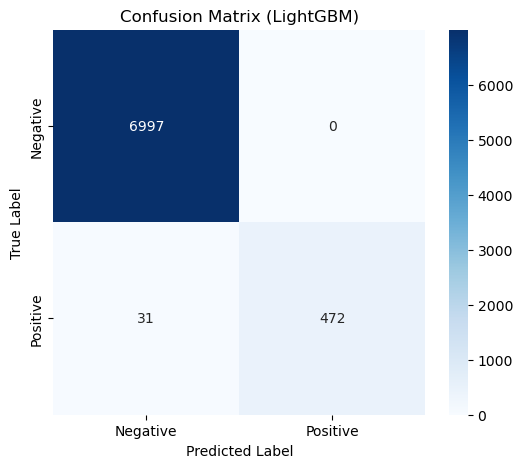

LightGBM metrics:
	ROC_AUC: 0.9991757330818575
	Accuracy: 0.9958666666666667
	Precision: 1.0
	Recall: 0.9383697813121272
	F1-Score: 0.9682051282051282


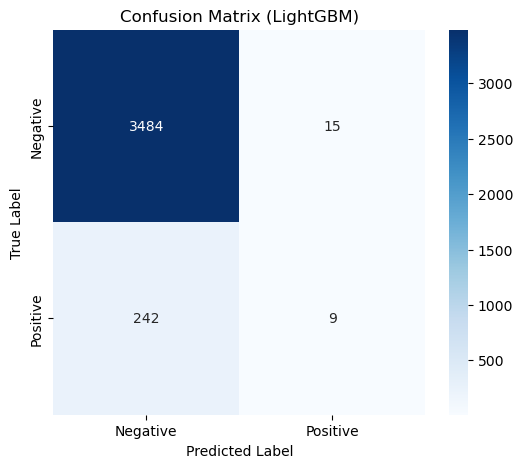

LightGBM metrics:
	ROC_AUC: 0.745904635245813
	Accuracy: 0.9314666666666667
	Precision: 0.375
	Recall: 0.035856573705179286
	F1-Score: 0.06545454545454546


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:16:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.9977 seconds


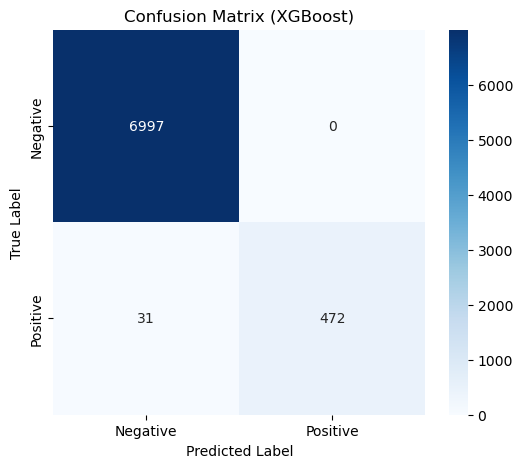

XGBoost metrics:
	ROC_AUC: 0.9995784901850864
	Accuracy: 0.9958666666666667
	Precision: 1.0
	Recall: 0.9383697813121272
	F1-Score: 0.9682051282051282


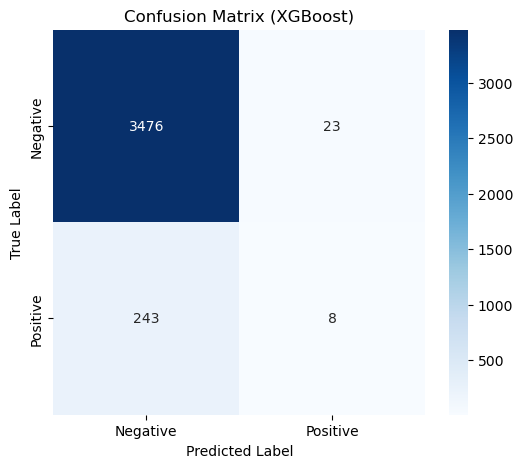

XGBoost metrics:
	ROC_AUC: 0.7470779926877229
	Accuracy: 0.9290666666666667
	Precision: 0.25806451612903225
	Recall: 0.03187250996015936
	F1-Score: 0.05673758865248227
Training Time: 0.5666 seconds


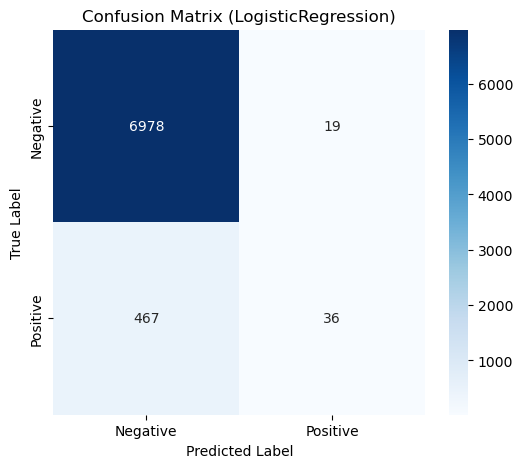

LogisticRegression metrics:
	ROC_AUC: 0.8381311388493393
	Accuracy: 0.9352
	Precision: 0.6545454545454545
	Recall: 0.07157057654075547
	F1-Score: 0.12903225806451613


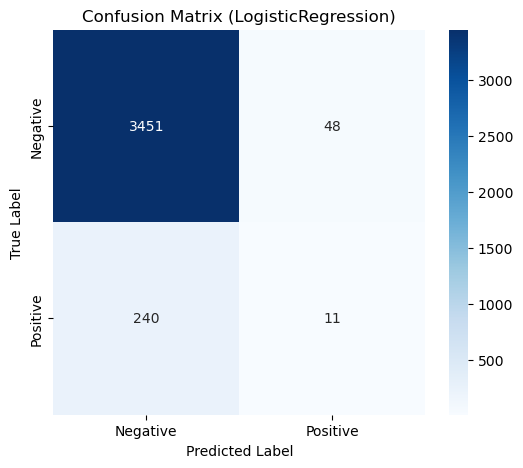

LogisticRegression metrics:
	ROC_AUC: 0.7130699835695798
	Accuracy: 0.9232
	Precision: 0.1864406779661017
	Recall: 0.043824701195219126
	F1-Score: 0.07096774193548387
Testing 350 features...
Training Time: 1.4502 seconds


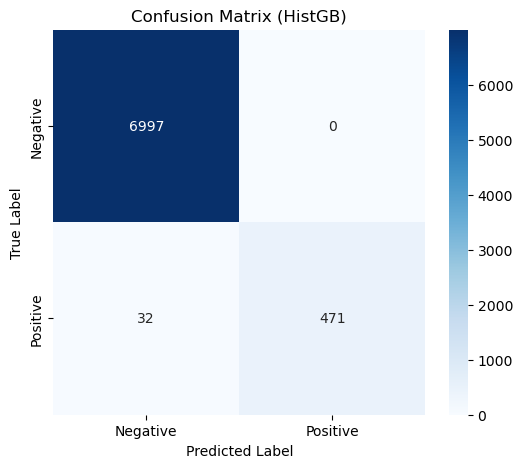

HistGB metrics:
	ROC_AUC: 0.99925827342647
	Accuracy: 0.9957333333333334
	Precision: 1.0
	Recall: 0.9363817097415507
	F1-Score: 0.9671457905544147


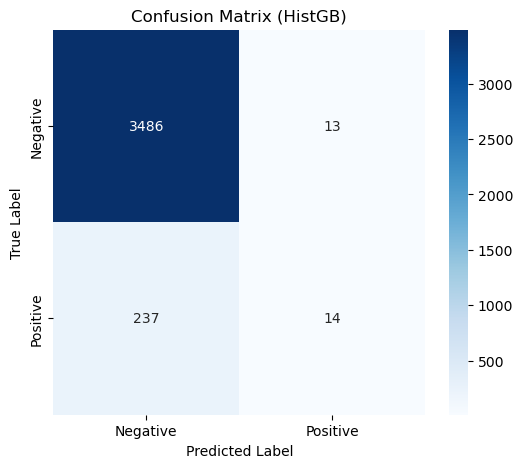

HistGB metrics:
	ROC_AUC: 0.7532823834698361
	Accuracy: 0.9333333333333333
	Precision: 0.5185185185185185
	Recall: 0.055776892430278883
	F1-Score: 0.10071942446043165
Training Time: 14.2607 seconds


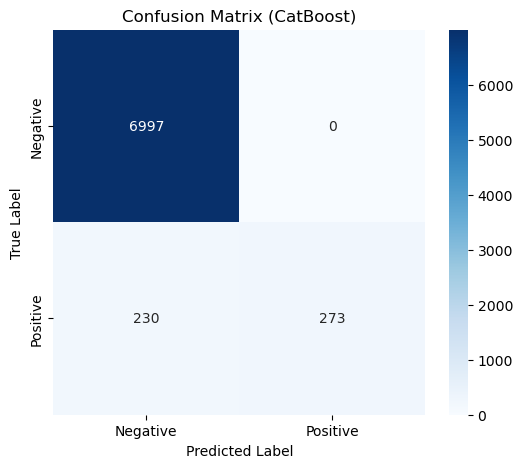

CatBoost metrics:
	ROC_AUC: 0.9898358882008791
	Accuracy: 0.9693333333333334
	Precision: 1.0
	Recall: 0.5427435387673957
	F1-Score: 0.7036082474226805


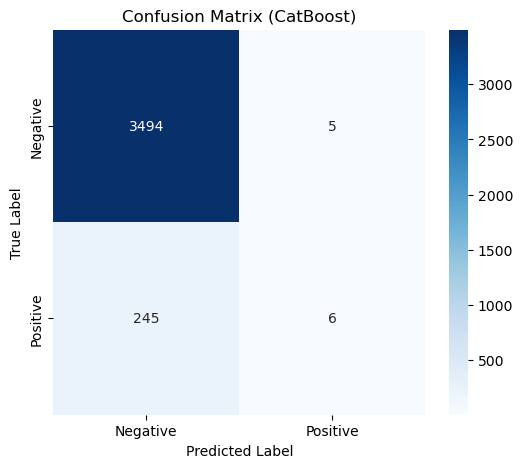

CatBoost metrics:
	ROC_AUC: 0.7746658407809176
	Accuracy: 0.9333333333333333
	Precision: 0.5454545454545454
	Recall: 0.02390438247011952
	F1-Score: 0.04580152671755725
[LightGBM] [Info] Number of positive: 503, number of negative: 6997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68533
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 350
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067067 -> initscore=-2.632647
[LightGBM] [Info] Start training from score -2.632647
Training Time: 1.0679 seconds


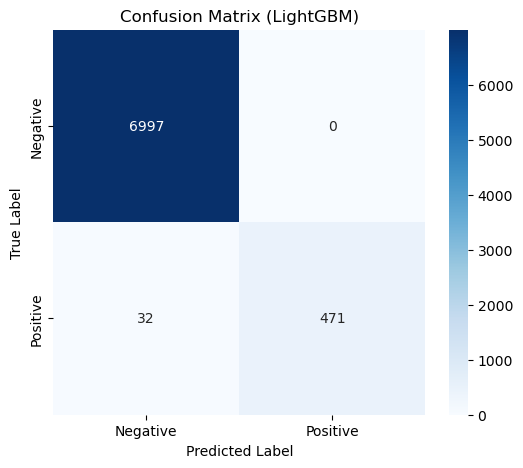

LightGBM metrics:
	ROC_AUC: 0.9992381000548091
	Accuracy: 0.9957333333333334
	Precision: 1.0
	Recall: 0.9363817097415507
	F1-Score: 0.9671457905544147


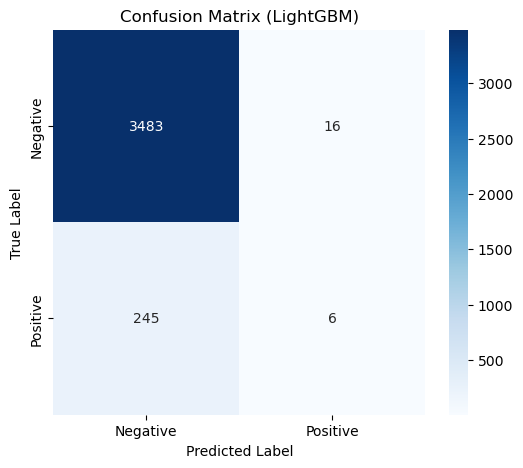

LightGBM metrics:
	ROC_AUC: 0.7509214357203935
	Accuracy: 0.9304
	Precision: 0.2727272727272727
	Recall: 0.02390438247011952
	F1-Score: 0.04395604395604396


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:16:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 1.3984 seconds


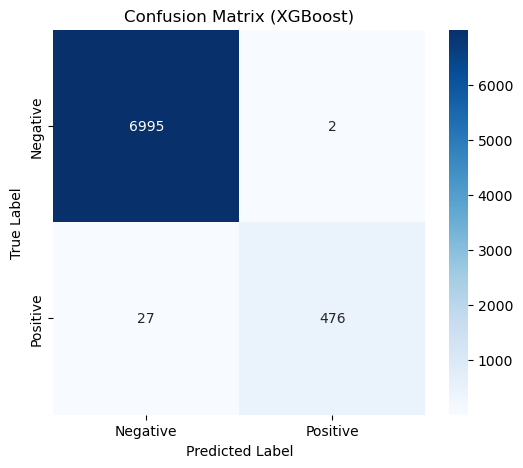

XGBoost metrics:
	ROC_AUC: 0.99965620028578
	Accuracy: 0.9961333333333333
	Precision: 0.99581589958159
	Recall: 0.9463220675944334
	F1-Score: 0.9704383282364933


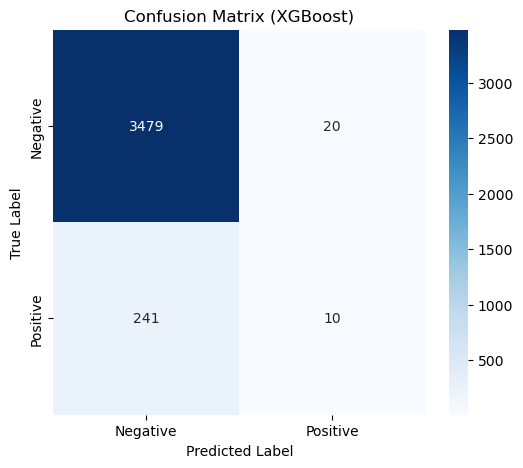

XGBoost metrics:
	ROC_AUC: 0.7444329569404577
	Accuracy: 0.9304
	Precision: 0.3333333333333333
	Recall: 0.0398406374501992
	F1-Score: 0.0711743772241993
Training Time: 0.7695 seconds


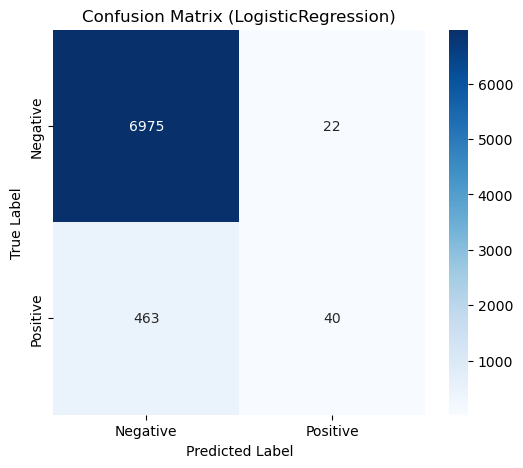

LogisticRegression metrics:
	ROC_AUC: 0.84594277979401
	Accuracy: 0.9353333333333333
	Precision: 0.6451612903225806
	Recall: 0.07952286282306163
	F1-Score: 0.1415929203539823


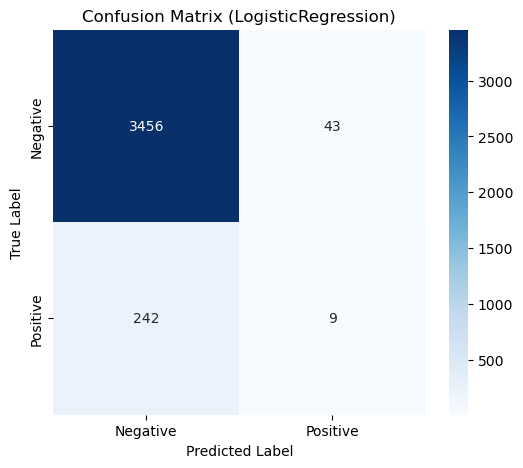

LogisticRegression metrics:
	ROC_AUC: 0.7137019228032141
	Accuracy: 0.924
	Precision: 0.17307692307692307
	Recall: 0.035856573705179286
	F1-Score: 0.0594059405940594
Testing 450 features...
Training Time: 1.4796 seconds


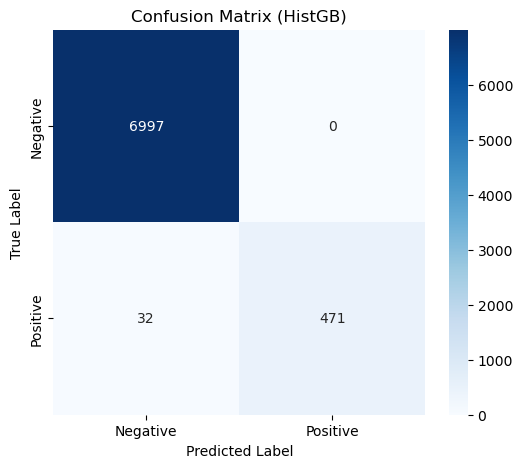

HistGB metrics:
	ROC_AUC: 0.9993085647896245
	Accuracy: 0.9957333333333334
	Precision: 1.0
	Recall: 0.9363817097415507
	F1-Score: 0.9671457905544147


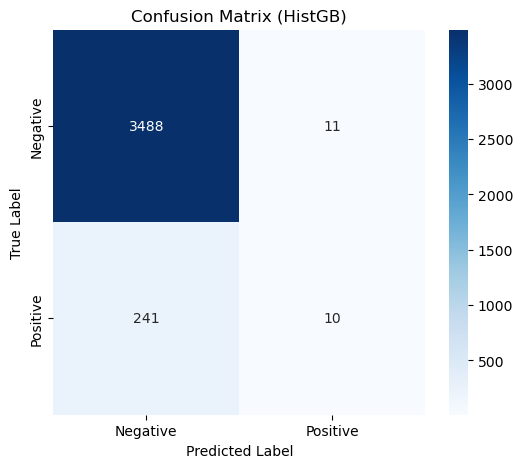

HistGB metrics:
	ROC_AUC: 0.7507922013005424
	Accuracy: 0.9328
	Precision: 0.47619047619047616
	Recall: 0.0398406374501992
	F1-Score: 0.07352941176470588
Training Time: 17.4034 seconds


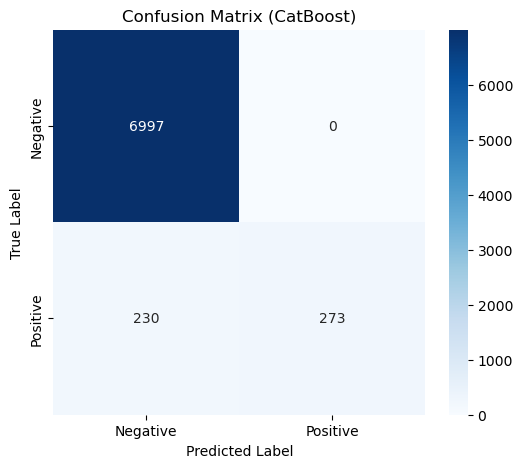

CatBoost metrics:
	ROC_AUC: 0.9907202490360111
	Accuracy: 0.9693333333333334
	Precision: 1.0
	Recall: 0.5427435387673957
	F1-Score: 0.7036082474226805


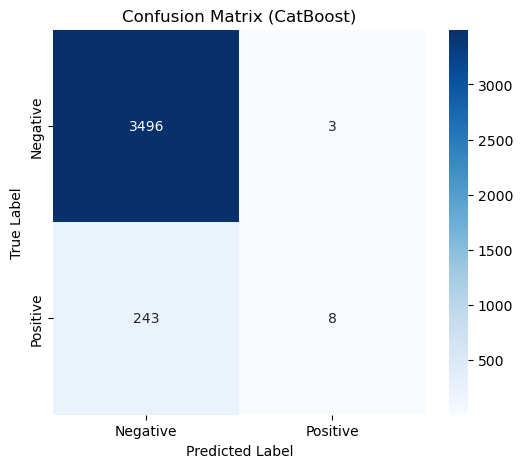

CatBoost metrics:
	ROC_AUC: 0.7786180229069433
	Accuracy: 0.9344
	Precision: 0.7272727272727273
	Recall: 0.03187250996015936
	F1-Score: 0.061068702290076333
[LightGBM] [Info] Number of positive: 503, number of negative: 6997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87274
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 450
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067067 -> initscore=-2.632647
[LightGBM] [Info] Start training from score -2.632647
Training Time: 1.2230 seconds


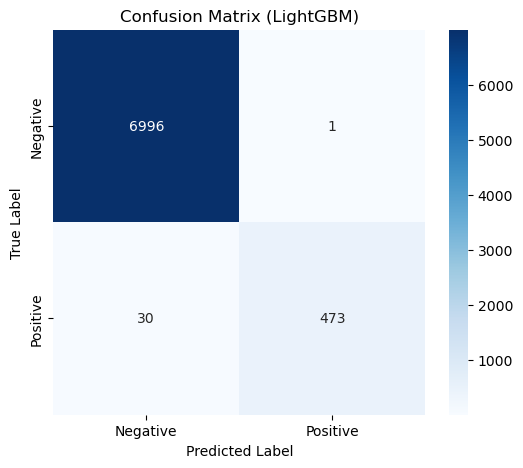

LightGBM metrics:
	ROC_AUC: 0.9993054393376769
	Accuracy: 0.9958666666666667
	Precision: 0.9978902953586498
	Recall: 0.9403578528827038
	F1-Score: 0.9682702149437052


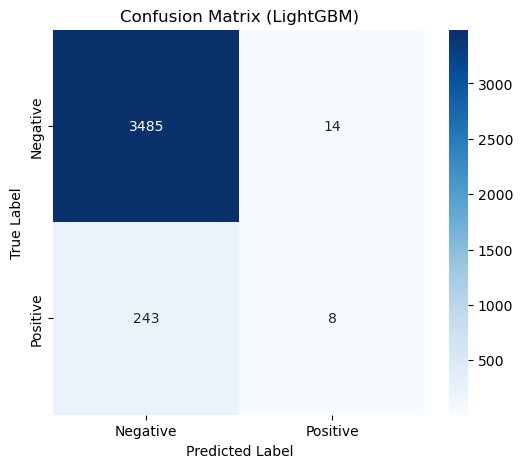

LightGBM metrics:
	ROC_AUC: 0.7528616599620381
	Accuracy: 0.9314666666666667
	Precision: 0.36363636363636365
	Recall: 0.03187250996015936
	F1-Score: 0.05860805860805861


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:17:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 1.9507 seconds


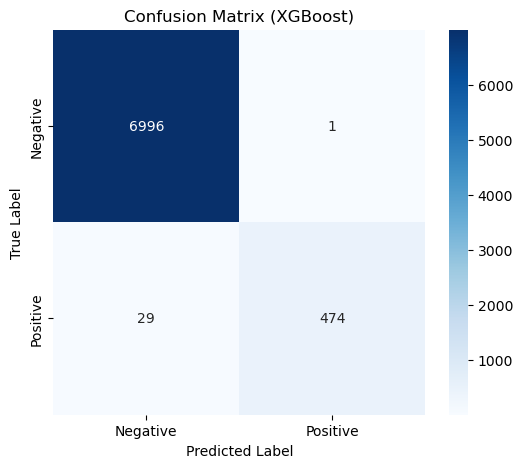

XGBoost metrics:
	ROC_AUC: 0.9996651504436295
	Accuracy: 0.996
	Precision: 0.9978947368421053
	Recall: 0.9423459244532804
	F1-Score: 0.9693251533742331


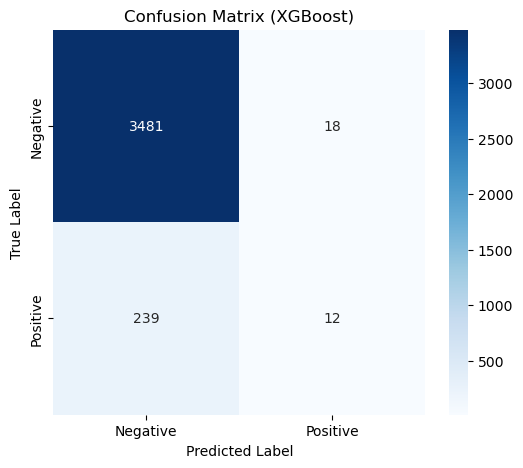

XGBoost metrics:
	ROC_AUC: 0.7230346974491288
	Accuracy: 0.9314666666666667
	Precision: 0.4
	Recall: 0.04780876494023904
	F1-Score: 0.08540925266903915
Training Time: 0.8846 seconds


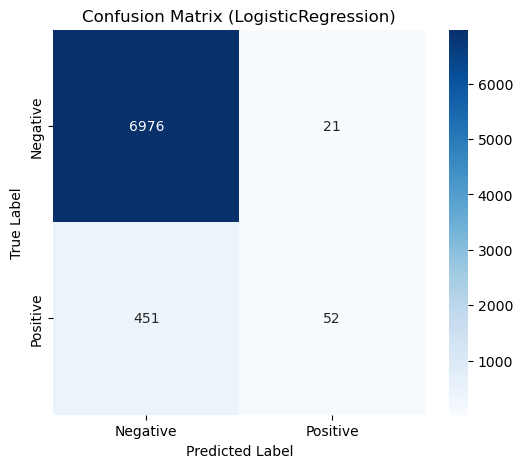

LogisticRegression metrics:
	ROC_AUC: 0.8562760921962863
	Accuracy: 0.9370666666666667
	Precision: 0.7123287671232876
	Recall: 0.10337972166998012
	F1-Score: 0.18055555555555555


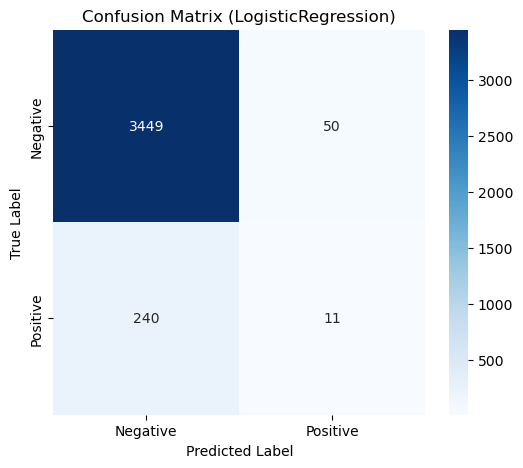

LogisticRegression metrics:
	ROC_AUC: 0.7083708606556911
	Accuracy: 0.9226666666666666
	Precision: 0.18032786885245902
	Recall: 0.043824701195219126
	F1-Score: 0.07051282051282051
Testing 550 features...
Training Time: 1.7984 seconds


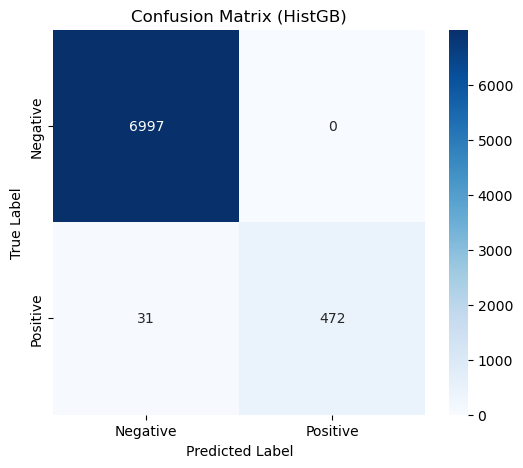

HistGB metrics:
	ROC_AUC: 0.9993715000265664
	Accuracy: 0.9958666666666667
	Precision: 1.0
	Recall: 0.9383697813121272
	F1-Score: 0.9682051282051282


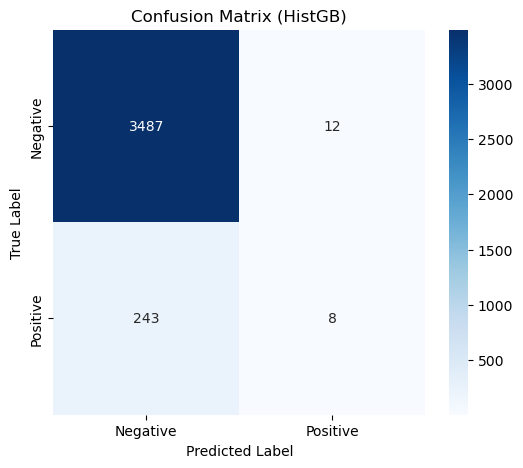

HistGB metrics:
	ROC_AUC: 0.7493774544576766
	Accuracy: 0.932
	Precision: 0.4
	Recall: 0.03187250996015936
	F1-Score: 0.05904059040590406
Training Time: 21.5924 seconds


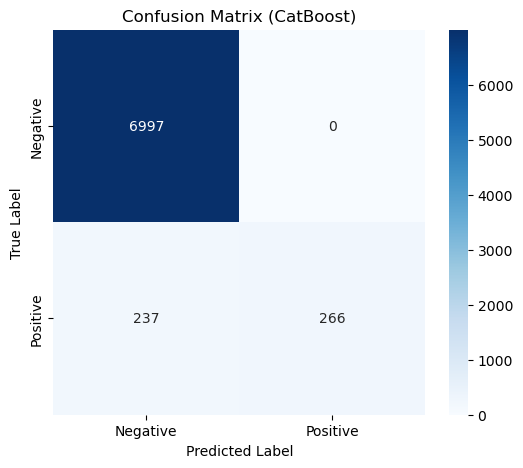

CatBoost metrics:
	ROC_AUC: 0.9907777857650438
	Accuracy: 0.9684
	Precision: 1.0
	Recall: 0.5288270377733598
	F1-Score: 0.6918075422626788


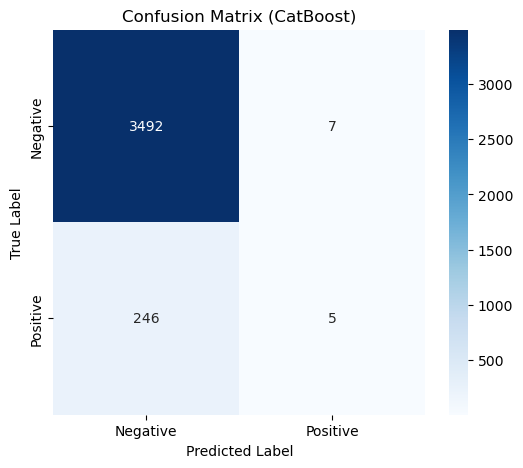

CatBoost metrics:
	ROC_AUC: 0.7840350515628256
	Accuracy: 0.9325333333333333
	Precision: 0.4166666666666667
	Recall: 0.0199203187250996
	F1-Score: 0.03802281368821293
[LightGBM] [Info] Number of positive: 503, number of negative: 6997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110557
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 550
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067067 -> initscore=-2.632647
[LightGBM] [Info] Start training from score -2.632647
Training Time: 1.4117 seconds


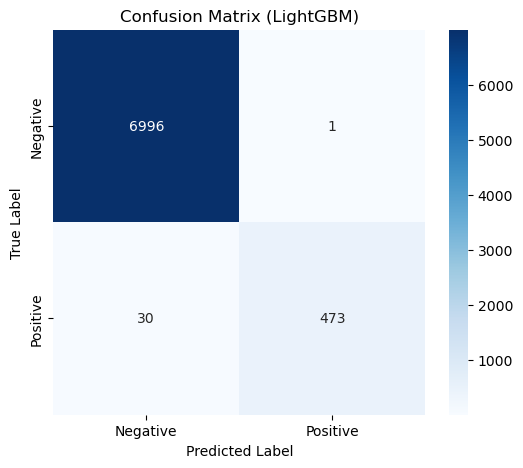

LightGBM metrics:
	ROC_AUC: 0.9992979098398035
	Accuracy: 0.9958666666666667
	Precision: 0.9978902953586498
	Recall: 0.9403578528827038
	F1-Score: 0.9682702149437052


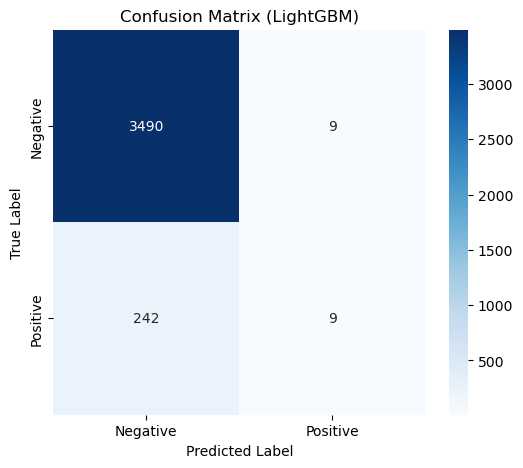

LightGBM metrics:
	ROC_AUC: 0.7597458124062766
	Accuracy: 0.9330666666666667
	Precision: 0.5
	Recall: 0.035856573705179286
	F1-Score: 0.06691449814126393


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:17:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 2.2945 seconds


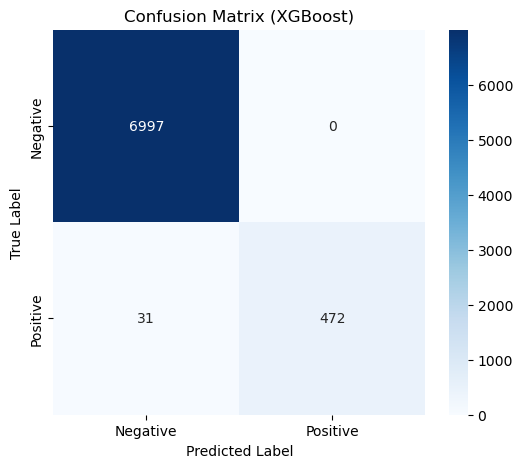

XGBoost metrics:
	ROC_AUC: 0.9996111653645371
	Accuracy: 0.9958666666666667
	Precision: 1.0
	Recall: 0.9383697813121272
	F1-Score: 0.9682051282051282


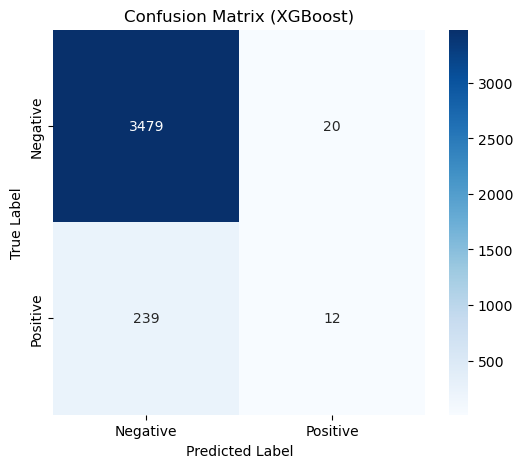

XGBoost metrics:
	ROC_AUC: 0.7511736420992223
	Accuracy: 0.9309333333333333
	Precision: 0.375
	Recall: 0.04780876494023904
	F1-Score: 0.08480565371024736
Training Time: 1.7518 seconds


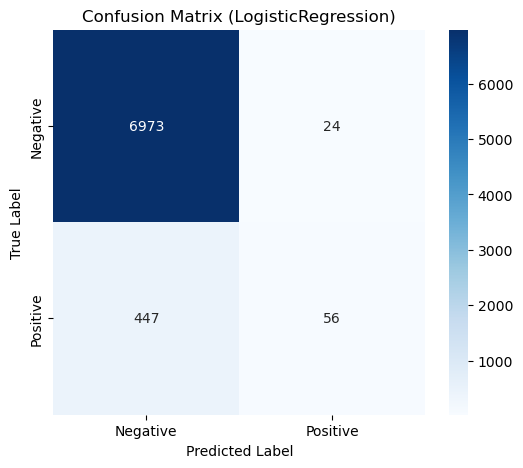

LogisticRegression metrics:
	ROC_AUC: 0.8656899534620204
	Accuracy: 0.9372
	Precision: 0.7
	Recall: 0.11133200795228629
	F1-Score: 0.19210977701543738


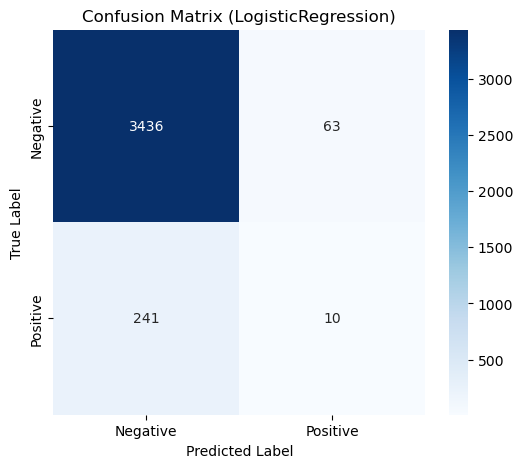

LogisticRegression metrics:
	ROC_AUC: 0.7014821536944533
	Accuracy: 0.9189333333333334
	Precision: 0.136986301369863
	Recall: 0.0398406374501992
	F1-Score: 0.06172839506172839
Testing 650 features...
Training Time: 2.0672 seconds


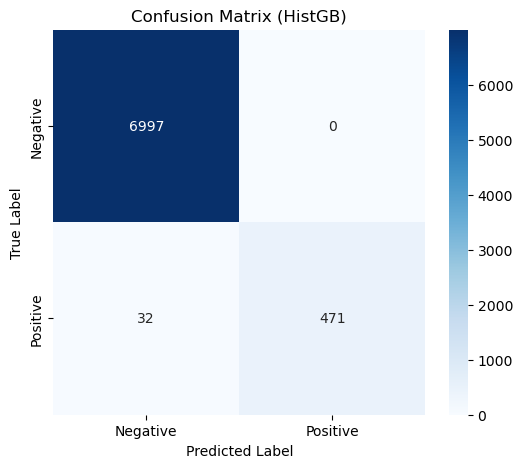

HistGB metrics:
	ROC_AUC: 0.9993109799115839
	Accuracy: 0.9957333333333334
	Precision: 1.0
	Recall: 0.9363817097415507
	F1-Score: 0.9671457905544147


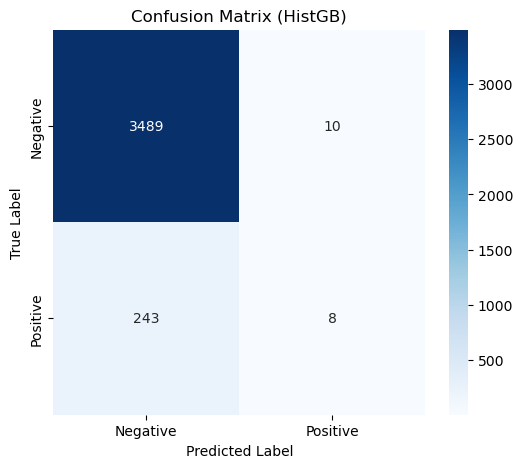

HistGB metrics:
	ROC_AUC: 0.7513563920938139
	Accuracy: 0.9325333333333333
	Precision: 0.4444444444444444
	Recall: 0.03187250996015936
	F1-Score: 0.05947955390334572
Training Time: 24.8534 seconds


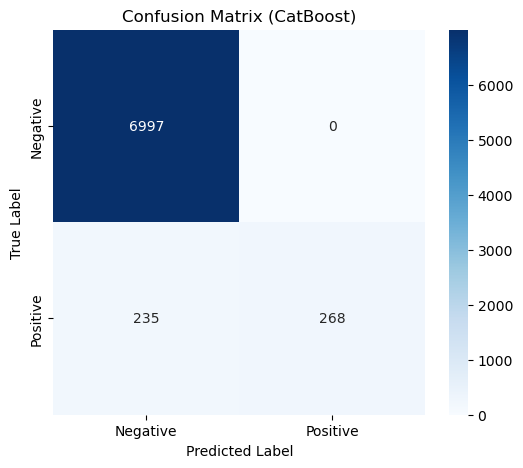

CatBoost metrics:
	ROC_AUC: 0.9913319852217267
	Accuracy: 0.9686666666666667
	Precision: 1.0
	Recall: 0.532803180914513
	F1-Score: 0.695201037613489


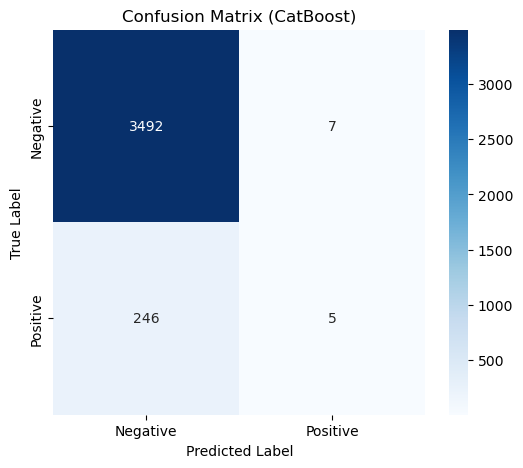

CatBoost metrics:
	ROC_AUC: 0.7846037968730962
	Accuracy: 0.9325333333333333
	Precision: 0.4166666666666667
	Recall: 0.0199203187250996
	F1-Score: 0.03802281368821293
[LightGBM] [Info] Number of positive: 503, number of negative: 6997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133264
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067067 -> initscore=-2.632647
[LightGBM] [Info] Start training from score -2.632647
Training Time: 1.8589 seconds


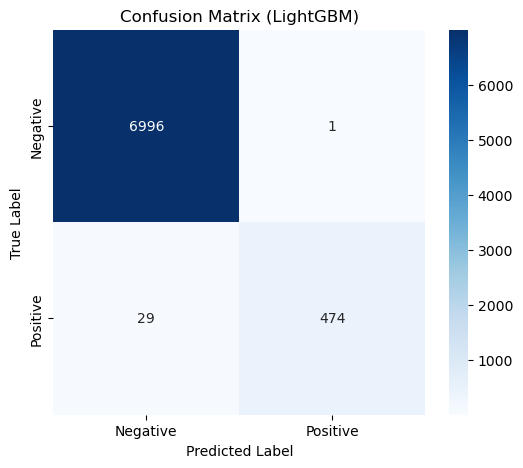

LightGBM metrics:
	ROC_AUC: 0.9993787453924445
	Accuracy: 0.996
	Precision: 0.9978947368421053
	Recall: 0.9423459244532804
	F1-Score: 0.9693251533742331


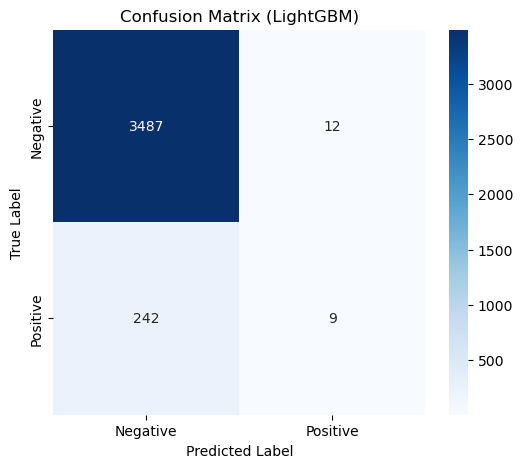

LightGBM metrics:
	ROC_AUC: 0.7607552072362167
	Accuracy: 0.9322666666666667
	Precision: 0.42857142857142855
	Recall: 0.035856573705179286
	F1-Score: 0.0661764705882353


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:18:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 2.7997 seconds


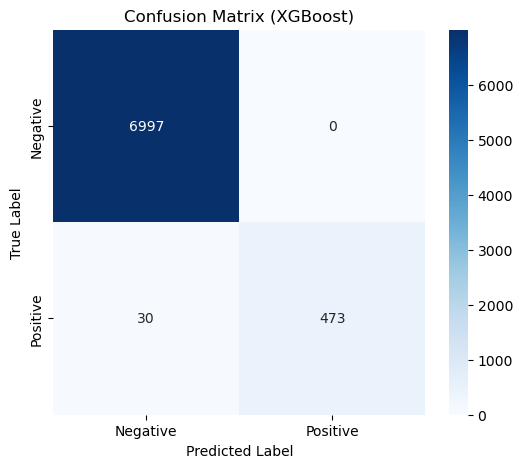

XGBoost metrics:
	ROC_AUC: 0.9996652925096271
	Accuracy: 0.996
	Precision: 1.0
	Recall: 0.9403578528827038
	F1-Score: 0.9692622950819673


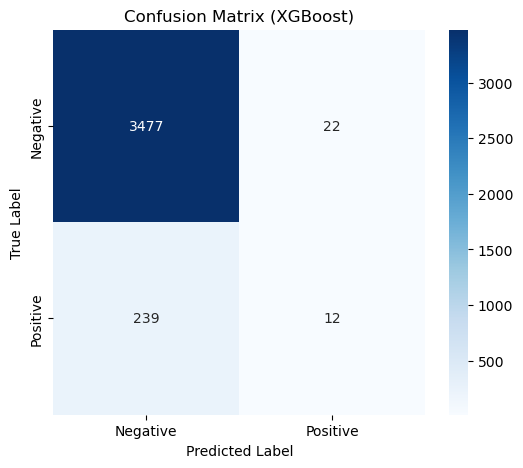

XGBoost metrics:
	ROC_AUC: 0.7389868932387057
	Accuracy: 0.9304
	Precision: 0.35294117647058826
	Recall: 0.04780876494023904
	F1-Score: 0.08421052631578947
Training Time: 1.8940 seconds


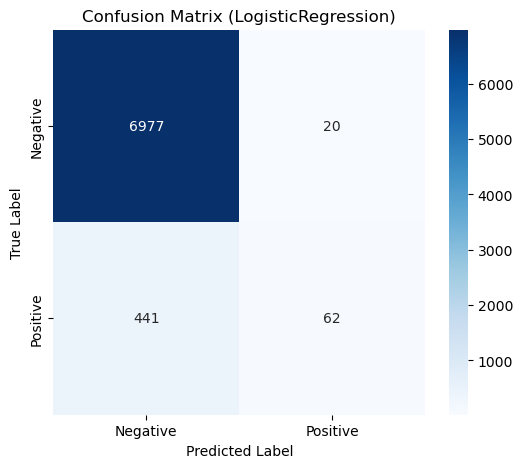

LogisticRegression metrics:
	ROC_AUC: 0.872232092652034
	Accuracy: 0.9385333333333333
	Precision: 0.7560975609756098
	Recall: 0.12326043737574553
	F1-Score: 0.21196581196581196


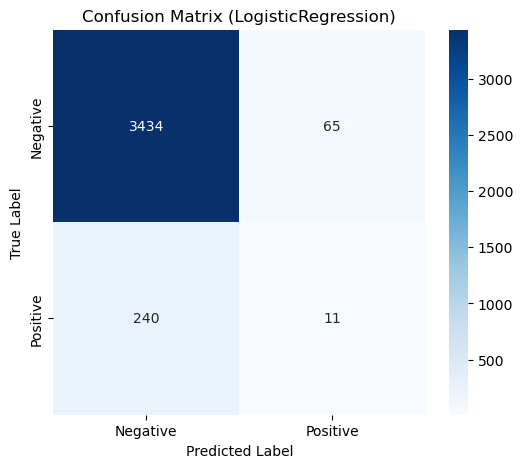

LogisticRegression metrics:
	ROC_AUC: 0.6962262410774165
	Accuracy: 0.9186666666666666
	Precision: 0.14473684210526316
	Recall: 0.043824701195219126
	F1-Score: 0.0672782874617737
Testing 750 features...
Training Time: 2.5728 seconds


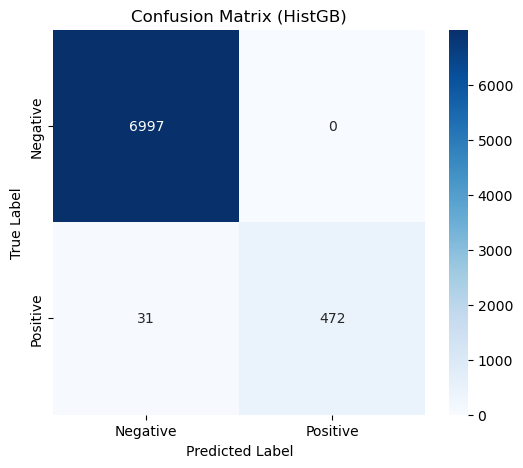

HistGB metrics:
	ROC_AUC: 0.9992554321065177
	Accuracy: 0.9958666666666667
	Precision: 1.0
	Recall: 0.9383697813121272
	F1-Score: 0.9682051282051282


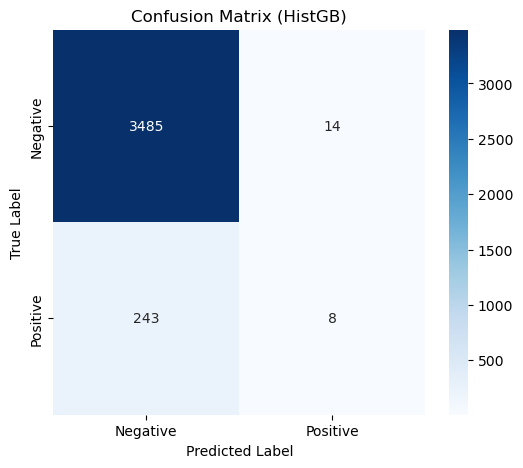

HistGB metrics:
	ROC_AUC: 0.7528884177494083
	Accuracy: 0.9314666666666667
	Precision: 0.36363636363636365
	Recall: 0.03187250996015936
	F1-Score: 0.05860805860805861
Training Time: 28.8770 seconds


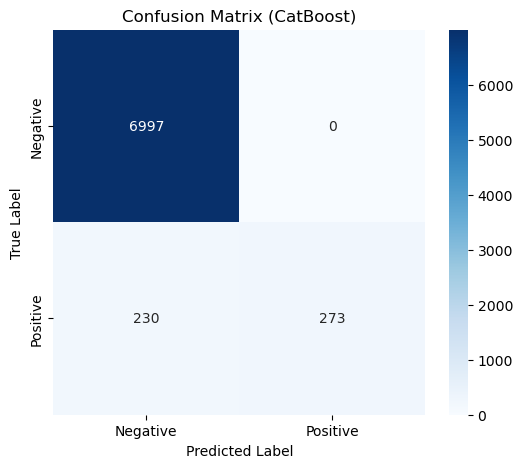

CatBoost metrics:
	ROC_AUC: 0.9913092546621087
	Accuracy: 0.9693333333333334
	Precision: 1.0
	Recall: 0.5427435387673957
	F1-Score: 0.7036082474226805


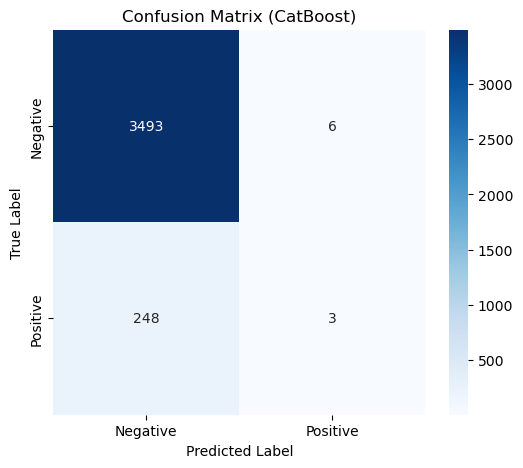

CatBoost metrics:
	ROC_AUC: 0.7768115876021492
	Accuracy: 0.9322666666666667
	Precision: 0.3333333333333333
	Recall: 0.01195219123505976
	F1-Score: 0.023076923076923078
[LightGBM] [Info] Number of positive: 503, number of negative: 6997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155636
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 750
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067067 -> initscore=-2.632647
[LightGBM] [Info] Start training from score -2.632647
Training Time: 2.2662 seconds


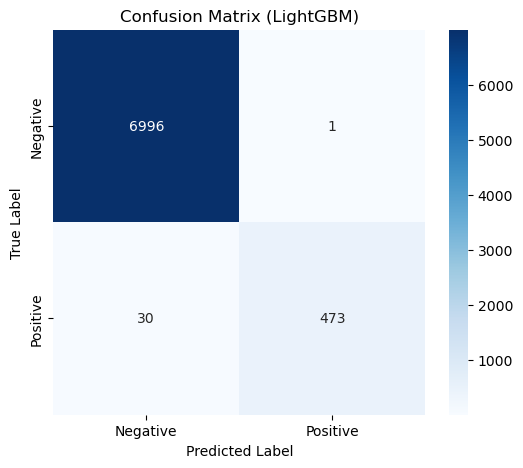

LightGBM metrics:
	ROC_AUC: 0.9993102695815957
	Accuracy: 0.9958666666666667
	Precision: 0.9978902953586498
	Recall: 0.9403578528827038
	F1-Score: 0.9682702149437052


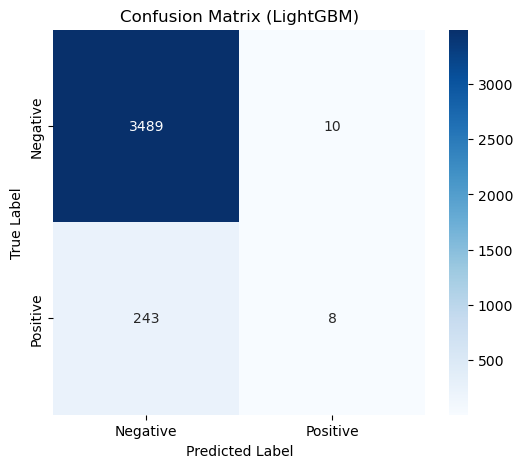

LightGBM metrics:
	ROC_AUC: 0.7550631996165097
	Accuracy: 0.9325333333333333
	Precision: 0.4444444444444444
	Recall: 0.03187250996015936
	F1-Score: 0.05947955390334572


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:19:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 3.3539 seconds


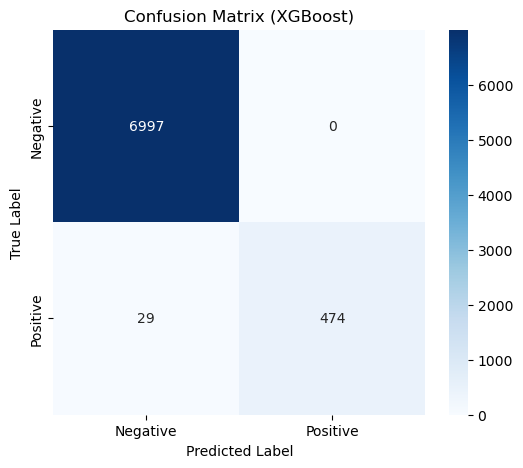

XGBoost metrics:
	ROC_AUC: 0.9996273608882648
	Accuracy: 0.9961333333333333
	Precision: 1.0
	Recall: 0.9423459244532804
	F1-Score: 0.970317297850563


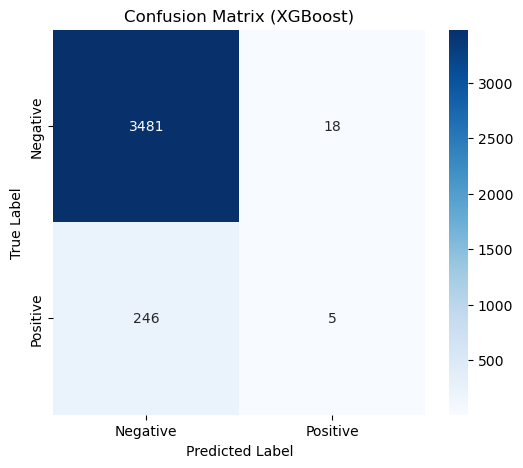

XGBoost metrics:
	ROC_AUC: 0.7587181995083399
	Accuracy: 0.9296
	Precision: 0.21739130434782608
	Recall: 0.0199203187250996
	F1-Score: 0.0364963503649635
Training Time: 2.1519 seconds


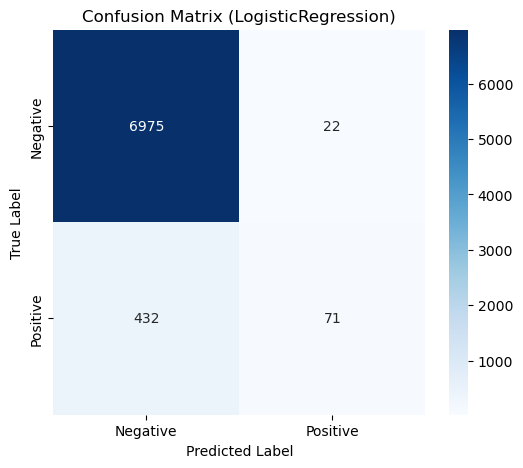

LogisticRegression metrics:
	ROC_AUC: 0.8810271144321721
	Accuracy: 0.9394666666666667
	Precision: 0.7634408602150538
	Recall: 0.1411530815109344
	F1-Score: 0.23825503355704697


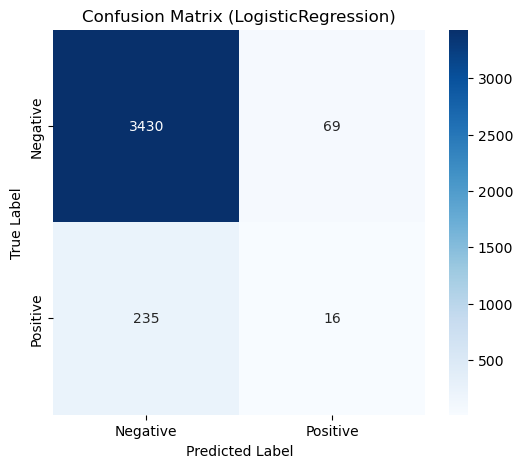

LogisticRegression metrics:
	ROC_AUC: 0.694155074472046
	Accuracy: 0.9189333333333334
	Precision: 0.18823529411764706
	Recall: 0.06374501992031872
	F1-Score: 0.09523809523809523
Testing 850 features...
Training Time: 2.6206 seconds


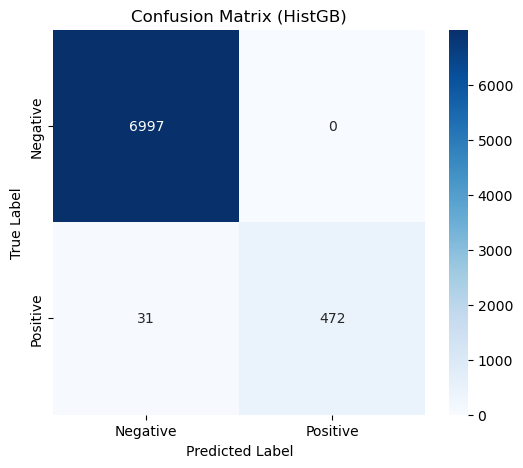

HistGB metrics:
	ROC_AUC: 0.9993645387926833
	Accuracy: 0.9958666666666667
	Precision: 1.0
	Recall: 0.9383697813121272
	F1-Score: 0.9682051282051282


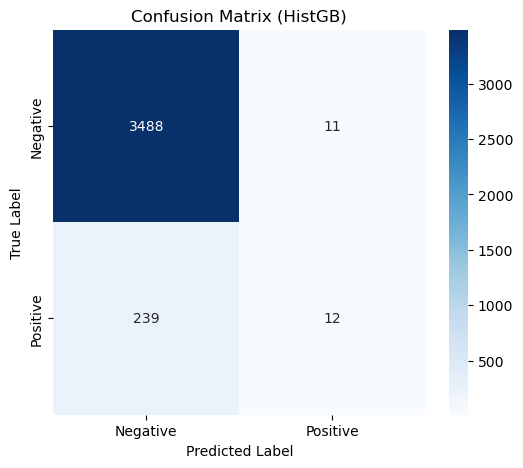

HistGB metrics:
	ROC_AUC: 0.7593148412352305
	Accuracy: 0.9333333333333333
	Precision: 0.5217391304347826
	Recall: 0.04780876494023904
	F1-Score: 0.08759124087591241


KeyboardInterrupt: 

In [51]:
# testing different number of features for all models (REDUNDANT)
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
all_metrics = {}
roc_by_num_features = defaultdict(list)
for num_features in max_features_lst:
    print(f"Testing {num_features} features...")
    feature_coefs = get_lasso_features(X_train_standardized, y_train) 
    selected_features = select_top_features(feature_coefs, num_features, limit=np.inf) # change limit parameter to np.inf to keep redundant features
    X_train_standardized_top_features, X_val_standardized_top_features = \
        get_feature_selection_datasets(X_train_standardized, selected_features), \
        get_feature_selection_datasets(X_val_standardized, selected_features), 
    model_metrics = {}
    for model_type in model_types:
        model, metrics = train_and_evaluate(X_train_standardized_top_features, y_train, X_val_standardized_top_features, y_val, model_type=model_type)
        model_metrics[model_type] = [model, metrics]
        roc_by_num_features[model_type].append(metrics['ROC_AUC'])
    all_metrics[f"{num_features}_features"] = model_metrics

In [102]:
# with open('roc_by_num_features.pkl', 'wb') as f:
#     pickle.dump(roc_by_num_features, f)

In [83]:
with open('roc_by_num_features.pkl', 'rb') as f:
    roc_by_num_features = pickle.load(f)

In [ ]:
"""
RUN BELOW CELL -- TEST DIFFERENT NUMBER OF FEATURES WITH CATEGORY LIMIT FOR ALL MODELS
"""

In [71]:
# this is actually with 205 features, due to the category limit (even though I set max_features to 2050, category limit set it to 205)
# CATBOOST ROC_AUC: 0.7682347623668585
	# Accuracy: 0.9143333333333333
	# Precision: 0.4
	# Recall: 0.03968253968253968

# ACTUALLY ALL 2050 FEATURES THIS TIME
# CATBOOST ROC_AUC: 0.7830276275964049
# 	Accuracy: 0.9153333333333333
# 	Precision: 0.42857142857142855
# 	Recall: 0.023809523809523808
# 	F1-Score: 0.045112781954887216

In [81]:
selected_features = select_top_features(feature_coefs, num_features, limit=3)

2050

Testing 2050 features...
Training Time: 5.5350 seconds


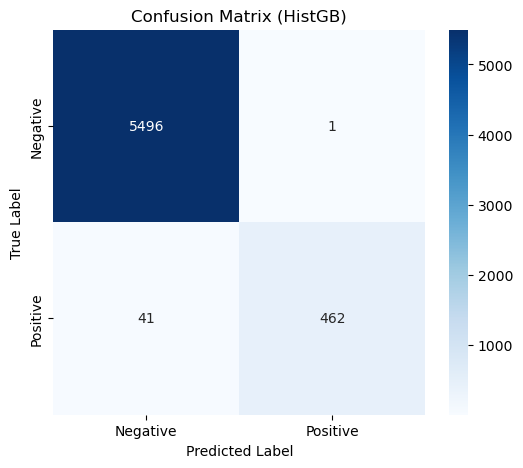

HistGB metrics:
	ROC_AUC: 0.99940506135463
	Accuracy: 0.993
	Precision: 0.9978401727861771
	Recall: 0.9184890656063618
	F1-Score: 0.9565217391304348


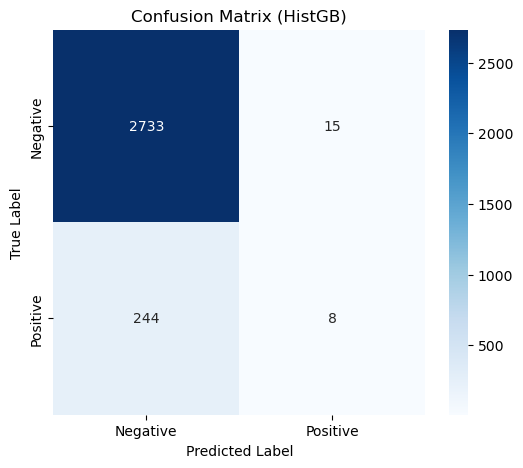

HistGB metrics:
	ROC_AUC: 0.7648722880709781
	Accuracy: 0.9136666666666666
	Precision: 0.34782608695652173
	Recall: 0.031746031746031744
	F1-Score: 0.05818181818181818
Training Time: 58.6965 seconds


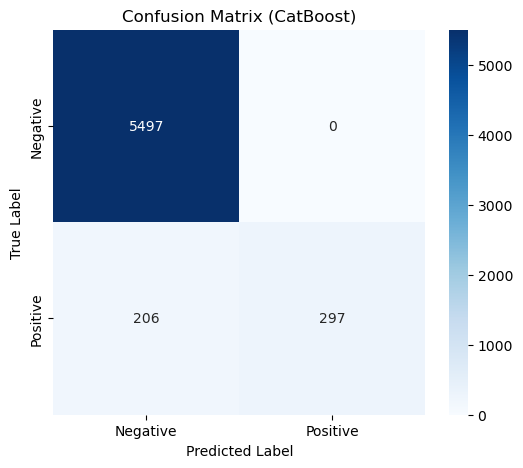

CatBoost metrics:
	ROC_AUC: 0.9918529572067322
	Accuracy: 0.9656666666666667
	Precision: 1.0
	Recall: 0.5904572564612326
	F1-Score: 0.7425


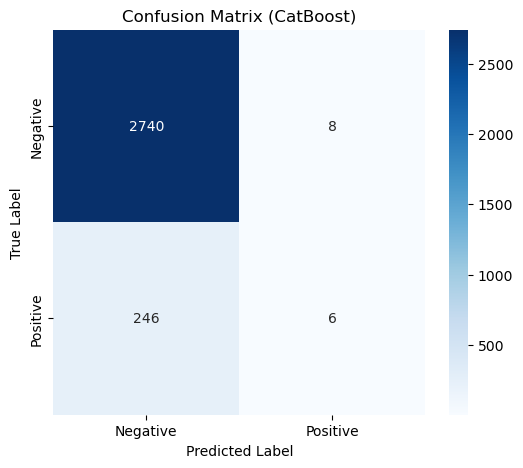

CatBoost metrics:
	ROC_AUC: 0.7830276275964049
	Accuracy: 0.9153333333333333
	Precision: 0.42857142857142855
	Recall: 0.023809523809523808
	F1-Score: 0.045112781954887216
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 358035
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1912
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 4.2976 seconds


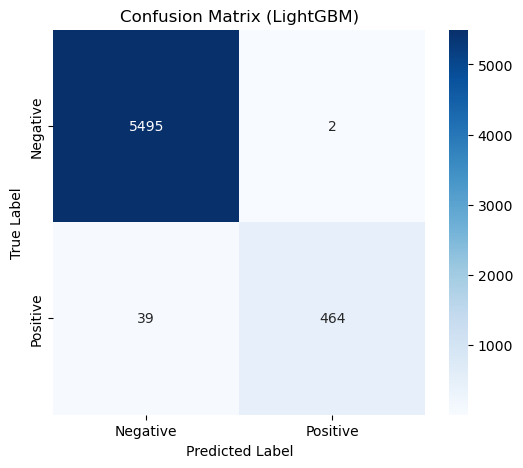

LightGBM metrics:
	ROC_AUC: 0.9994443019886864
	Accuracy: 0.9931666666666666
	Precision: 0.9957081545064378
	Recall: 0.9224652087475149
	F1-Score: 0.957688338493292


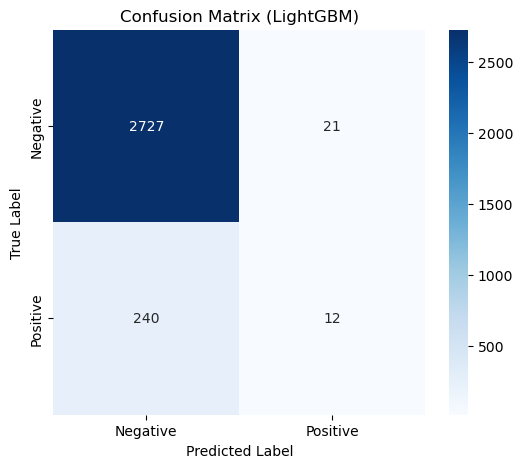

LightGBM metrics:
	ROC_AUC: 0.7688744772532983
	Accuracy: 0.913
	Precision: 0.36363636363636365
	Recall: 0.047619047619047616
	F1-Score: 0.08421052631578947


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:23:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 8.3010 seconds


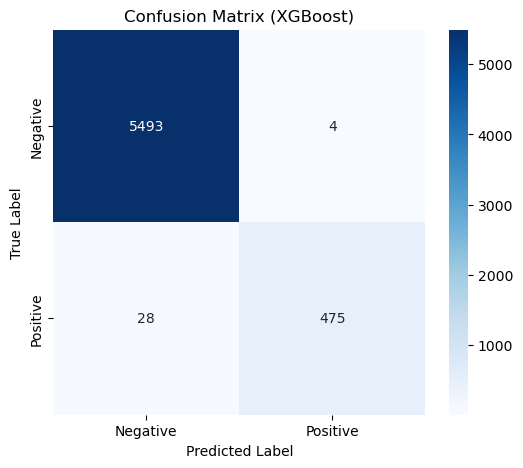

XGBoost metrics:
	ROC_AUC: 0.9996314635382177
	Accuracy: 0.9946666666666667
	Precision: 0.9916492693110647
	Recall: 0.9443339960238568
	F1-Score: 0.9674134419551935


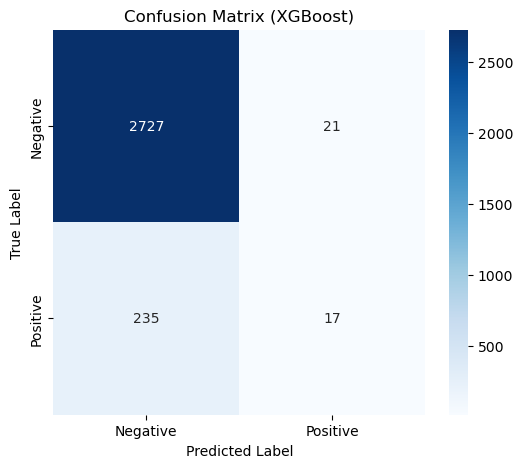

XGBoost metrics:
	ROC_AUC: 0.7587776680298515
	Accuracy: 0.9146666666666666
	Precision: 0.4473684210526316
	Recall: 0.06746031746031746
	F1-Score: 0.11724137931034483
Training Time: 3.3613 seconds


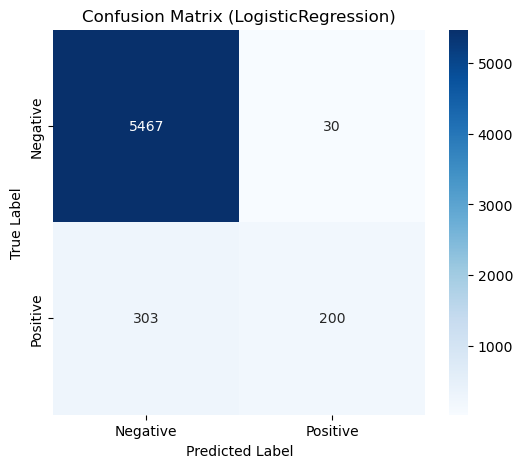

LogisticRegression metrics:
	ROC_AUC: 0.9472025406230978
	Accuracy: 0.9445
	Precision: 0.8695652173913043
	Recall: 0.3976143141153082
	F1-Score: 0.5457025920873124


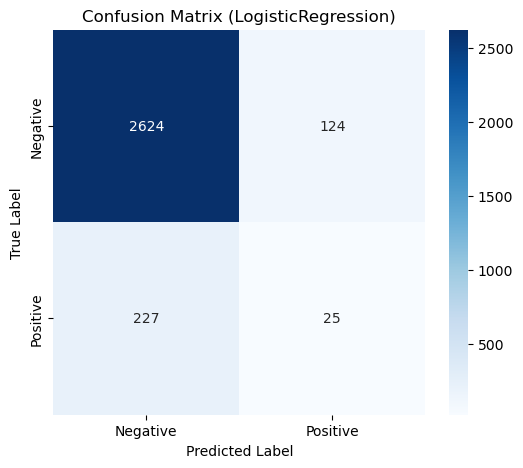

LogisticRegression metrics:
	ROC_AUC: 0.6770753910491901
	Accuracy: 0.883
	Precision: 0.16778523489932887
	Recall: 0.0992063492063492
	F1-Score: 0.12468827930174564


In [82]:
# testing different number of features for all models (CATEGORY LIMIT)
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
all_metrics_limit = {}
roc_by_num_features_limit = defaultdict(list)
for num_features in [2050]: #max_features_lst:
    print(f"Testing {num_features} features...")
    feature_coefs = get_lasso_features(X_train_standardized, y_train) 
    selected_features = select_top_features(feature_coefs, num_features, limit=3) # change limit parameter to np.inf to keep redundant features
    X_train_standardized_top_features, X_val_standardized_top_features = \
        get_feature_selection_datasets(X_train_standardized, selected_features), \
        get_feature_selection_datasets(X_val_standardized, selected_features), 
    model_metrics = {}
    for model_type in model_types:
        model, metrics = train_and_evaluate(X_train_standardized_top_features, y_train, X_val_standardized_top_features, y_val, model_type=model_type)
        model_metrics[model_type] = [model, metrics]
        roc_by_num_features_limit[model_type].append(metrics['ROC_AUC'])
    all_metrics_limit[f"{num_features}_features"] = model_metrics

In [ ]:
with open('roc_by_num_features_limit.pkl', 'wb') as f:
    pickle.dump(roc_by_num_features_limit, f)

In [86]:
with open('roc_by_num_features_limit.pkl', 'rb') as f:
    roc_by_num_features_limit = pickle.load(f)

EOFError: Ran out of input

In [43]:
### getting roc auc metrics across num_features kept ###

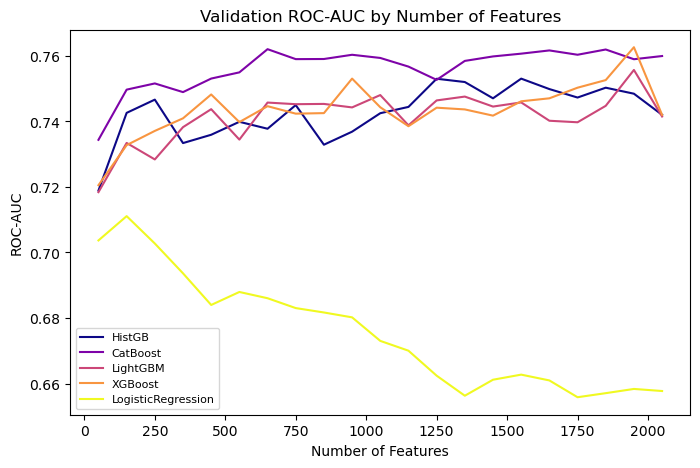

In [87]:
# plotting roc auc for all models across number of features
plt.figure(figsize=(8, 5))
colors = cm.plasma(np.linspace(0, 1, len(model_types)))  # Use 'viridis', or try 'plasma', 'coolwarm', etc.
for i, model_type in enumerate(model_types):
    plt.plot(max_features_lst, roc_by_num_features[model_type], label=model_type, linestyle="-", color=colors[i])
plt.legend()
plt.title("Validation ROC-AUC by Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("ROC-AUC")
plt.legend(fontsize=8, loc="lower left")  
plt.savefig("roc_by_num_features.png", dpi=300, bbox_inches='tight') 
plt.show()

##### Baseline Feature Selection Models

In [ ]:
model, metrics = train_and_evaluate(X_train_standardized, y_train, X_val_standardized, y_val, model_type='CatBoost')

In [124]:
feature_coefs = get_lasso_features(X_train_standardized, y_train) 
selected_features = select_top_features(feature_coefs, 200, limit=np.inf) # change limit parameter to np.inf to keep redundant features

In [117]:
X_train_standardized_top_50, X_test_standardized_top_50 = \
    get_feature_selection_datasets(X_train_standardized, selected_features), \
    get_feature_selection_datasets(X_test_standardized, selected_features), 

In [118]:
# fit with top 50 features
model_top_50 = fit_model(X_train_standardized_top_50, y_train, model_type='log_reg')

In [119]:
# predict on train set with top 50 features
y_pred_train_standardized_top_50, y_pred_proba_train_standardized_top_50 = predict(X_train_standardized_top_50, y_train, model_top_50)
y_pred_proba_train_standardized_top_50 = y_pred_proba_train_standardized_top_50[:, 1]

# predict on test set with top 50 features
y_pred_test_standardized_top_50, y_pred_proba_test_standardized_top_50 = predict(X_test_standardized_top_50, y_test, model_top_50)
y_pred_proba_test_standardized_top_50 = y_pred_proba_test_standardized_top_50[:, 1]

In [120]:
# train metrics
evaluate_model(y_train, y_pred_train_standardized_top_50, y_pred_proba_train_standardized_top_50)

ROC AUC Score: 0.8001
Accuracy: 0.9183

Confusion Matrix:
[[8213   33]
 [ 702   52]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8246
         1.0       0.61      0.07      0.12       754

    accuracy                           0.92      9000
   macro avg       0.77      0.53      0.54      9000
weighted avg       0.90      0.92      0.89      9000



In [121]:
# top 50 features with redundancy: 

# ROC AUC Score: 0.7670
# Accuracy: 0.9170

# Confusion Matrix:
# [[8786   16]
#  [ 781   17]]

# Classification Report:
#               precision    recall  f1-score   support

#          0.0       0.92      1.00      0.96      8802
#          1.0       0.52      0.02      0.04       798

#     accuracy                           0.92      9600
#    macro avg       0.72      0.51      0.50      9600
# weighted avg       0.88      0.92      0.88      9600

In [122]:
# test metrics
evaluate_model(y_test, y_pred_test_standardized_top_50, y_pred_proba_test_standardized_top_50)

ROC AUC Score: 0.7063
Accuracy: 0.9083

Confusion Matrix:
[[2720   28]
 [ 247    5]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2748
         1.0       0.15      0.02      0.04       252

    accuracy                           0.91      3000
   macro avg       0.53      0.50      0.49      3000
weighted avg       0.85      0.91      0.87      3000



In [98]:
# top 50 features with redundancy: 

# ROC AUC Score: 0.7176
# Accuracy: 0.9121

# Confusion Matrix:
# [[2186    6]
#  [ 205    3]]

# Classification Report:
#               precision    recall  f1-score   support

#          0.0       0.91      1.00      0.95      2192
#          1.0       0.33      0.01      0.03       208

#     accuracy                           0.91      2400
#    macro avg       0.62      0.51      0.49      2400
# weighted avg       0.86      0.91      0.87      2400

##### Point Biserial Correlation

In [76]:
# use features with highest point biserial correlation
point_biserial_features = [(feature, pointbiserialr(X_train[feature], y_train).statistic) for feature in X_train.columns]
point_biserial_features.sort(key=lambda x: abs(x[1]), reverse=True)
top_50_features_pb = [feature[0] for feature in point_biserial_features[:50]]

/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


In [77]:
# grab top 50 features by point biseral corr
X_train_standardized_top_50_pb = X_train_standardized[top_50_features_pb]
X_test_standardized_top_50_pb = X_test_standardized[top_50_features_pb]

In [78]:
# fit with top 50 features
model_top_50_pb = fit_model(X_train_standardized_top_50_pb, y_train, model_type='log_reg')

In [79]:
# predict on train set with top 50 features
%time y_pred_train_standardized_top_50_pb, y_pred_proba_train_standardized_top_50_pb = predict(X_train_standardized_top_50_pb, y_train, model_top_50_pb)
y_pred_proba_train_standardized_top_50_pb = y_pred_proba_train_standardized_top_50_pb[:, 1]

CPU times: user 6.89 ms, sys: 42 µs, total: 6.93 ms
Wall time: 5.07 ms


In [80]:
# train metrics
evaluate_model(y_train, y_pred_train_standardized_top_50_pb, y_pred_proba_train_standardized_top_50_pb)

ROC AUC Score: 0.7180
Accuracy: 0.9165

Confusion Matrix:
[[8793    9]
 [ 793    5]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8802
         1.0       0.36      0.01      0.01       798

    accuracy                           0.92      9600
   macro avg       0.64      0.50      0.48      9600
weighted avg       0.87      0.92      0.88      9600



In [81]:
# predict on test set with top 50 features
%time y_pred_test_standardized_top_50_pb, y_pred_proba_test_standardized_top_50_pb = predict(X_test_standardized_top_50_pb, y_test, model_top_50_pb)
y_pred_proba_test_standardized_top_50_pb = y_pred_proba_test_standardized_top_50_pb[:, 1]

CPU times: user 0 ns, sys: 4.9 ms, total: 4.9 ms
Wall time: 3.44 ms


In [82]:
# test metrics
evaluate_model(y_test, y_pred_test_standardized_top_50_pb, y_pred_proba_test_standardized_top_50_pb)

ROC AUC Score: 0.6881
Accuracy: 0.9133

Confusion Matrix:
[[2191    1]
 [ 207    1]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2192
         1.0       0.50      0.00      0.01       208

    accuracy                           0.91      2400
   macro avg       0.71      0.50      0.48      2400
weighted avg       0.88      0.91      0.87      2400



##### Top 50 Feature Plots

<Axes: xlabel='DQ_TARGET', ylabel='ATM_CASH_last_14_days_count'>

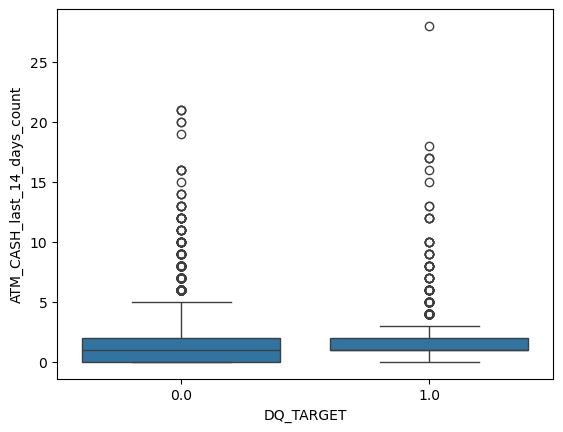

In [83]:
sns.boxplot(final_features_df, x='DQ_TARGET', y='ATM_CASH_last_14_days_count')

In [84]:
final_features_dq_0 = final_features_df[final_features_df['DQ_TARGET'] == 0]
final_features_dq_1 = final_features_df[final_features_df['DQ_TARGET'] == 1]

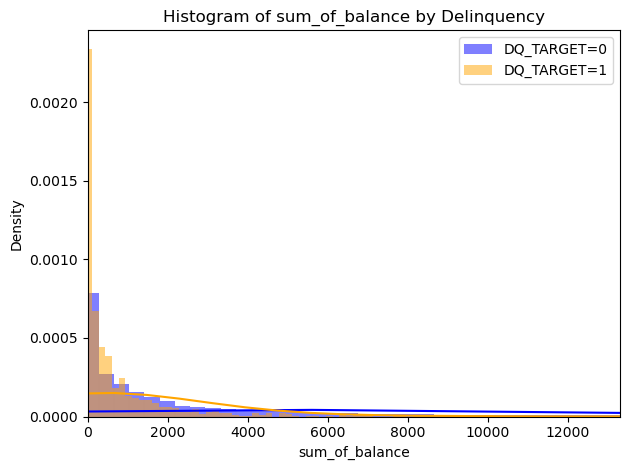

In [85]:
feature = 'sum_of_balance'# sum_of_balance SELF_TRANSFER_last_year_median
x_min, x_max = np.percentile(final_features_df[feature], [10,90])
if 'count' in feature:
    sns.boxplot(final_features_df, x='DQ_TARGET', y=feature)
    plt.title(f"Box Plot of {feature} by Delinquency")
else:
    sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, color='blue', alpha=0.5)
    sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, color='orange', alpha=0.5)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.title(f"Histogram of {feature} by Delinquency")
plt.tight_layout()
plt.show()

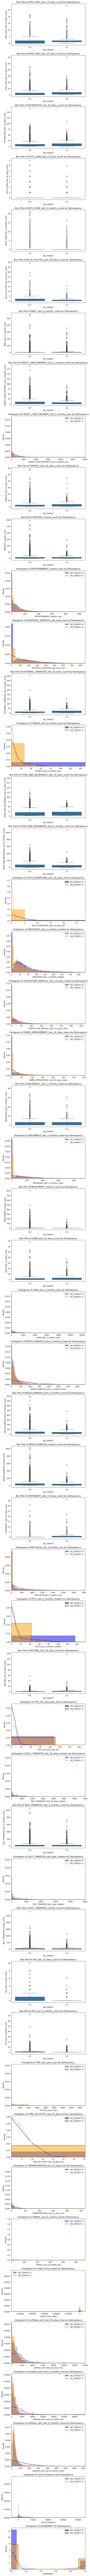

In [88]:
top_features_subset = top_50_features_l1
fig, axes = plt.subplots(len(top_features_subset), 1, figsize=(7, len(top_features_subset) * 4))

for i, feature in enumerate(top_features_subset):
    x_min, x_max = np.percentile(final_features_df[feature], [0,99])
    if 'count' in feature:
        sns.boxplot(final_features_df, x='DQ_TARGET', y=feature, ax=axes[i])
        axes[i].set_title(f"Box Plot of {feature} by Delinquency")
    else:
        sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, ax=axes[i], color='blue', alpha=0.5)
        sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, ax=axes[i], color='orange', alpha=0.5)
        axes[i].legend()
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_title(f"Histogram of {feature} by Delinquency")

plt.tight_layout()
plt.show()

In [ ]:
top_features_subset = top_50_features_pb
fig, axes = plt.subplots(len(top_features_subset), 1, figsize=(7, len(top_features_subset) * 4))

for i, feature in enumerate(top_features_subset):
    x_min, x_max = np.percentile(final_features_df[feature], [0,99])
    if 'count' in feature:
        sns.boxplot(final_features_df, x='DQ_TARGET', y=feature, ax=axes[i])
        axes[i].set_title(f"Box Plot of {feature} by Delinquency")
    else:
        sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, ax=axes[i], color='blue', alpha=0.5)
        sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, ax=axes[i], color='orange', alpha=0.5)
        axes[i].legend()
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_title(f"Histogram of {feature} by Delinquency")

plt.tight_layout()
plt.show()

#### Multiple Model Training

In [37]:
# testing models with all standardized features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_standardized, y_train, X_test_standardized, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

In [39]:
# testing models with l1 top 50 standardized features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_standardized_top_50_l1, y_train, X_test_standardized_top_50_l1, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

In [ ]:
# gambling not in my top features, should inspect that

## Week 6

#### SMOTE

In [ ]:
# !pip install imbalanced-learn

In [33]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [143]:
X_train_resampled, y_train_resampled = resample_data(X_train_standardized, y_train)

In [144]:
X_val_resampled, y_val_resampled = resample_data(X_val_standardized, y_val)

In [98]:
# columns get shuffled after SMOTE, need to reorder them
X_train_resampled = X_train_resampled[X_train_standardized.columns]
# some columns get converted to object dtype, need to change back to float
cols_dtype_object = X_train_resampled.dtypes[X_train_resampled.dtypes == 'object'].index
X_train_resampled[cols_dtype_object] = X_train_resampled[cols_dtype_object].astype(float)

In [114]:
def get_metrics(X, y, model, model_type):
    # Predict on training data
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Evaluation Metrics
    metrics = {
        "ROC_AUC": roc_auc_score(y, y_prob),
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1-Score": f1_score(y, y_pred),
        # "Confusion Matrix": confusion_matrix(y, y_pred)
    }

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({model_type})")
    plt.show()

    # Print Metrics
    print(f'{model_type} metrics:')
    for metric, value in metrics.items():
        print(f"\t{metric}: {value}")

    return metrics

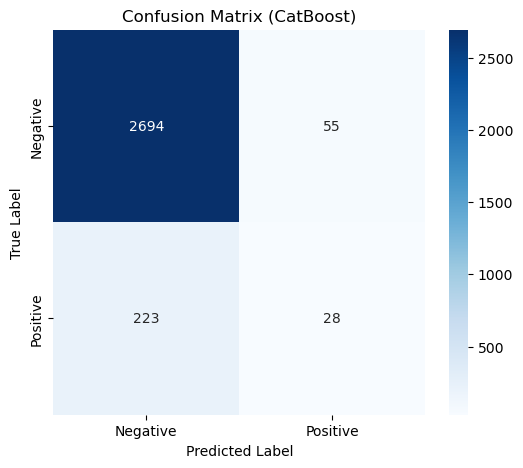

CatBoost metrics:
	ROC_AUC: 0.7446489052882685
	Accuracy: 0.9073333333333333
	Precision: 0.3373493975903614
	Recall: 0.11155378486055777
	F1-Score: 0.16766467065868262


In [115]:
# test metrics on SMOTE validation
model_test = model_metrics['CatBoost'][0]
_ = get_metrics(X_test_standardized, y_test, model_test, 'CatBoost')

Training Time: 6.1775 seconds


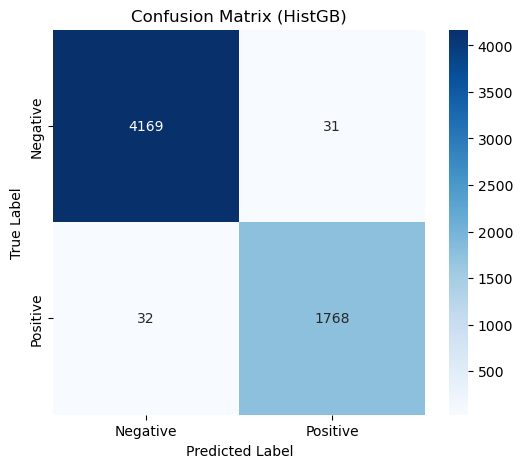

HistGB metrics:
	ROC_AUC: 0.9995073412698413
	Accuracy: 0.9895
	Precision: 0.9827682045580878
	Recall: 0.9822222222222222
	F1-Score: 0.982495137538205


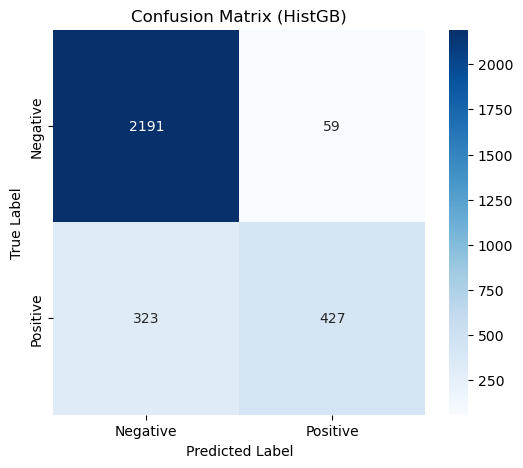

HistGB metrics:
	ROC_AUC: 0.9067315555555556
	Accuracy: 0.8726666666666667
	Precision: 0.8786008230452675
	Recall: 0.5693333333333334
	F1-Score: 0.6909385113268608
Training Time: 64.0651 seconds


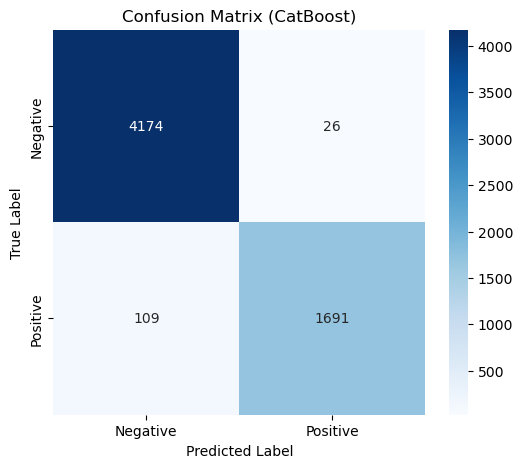

CatBoost metrics:
	ROC_AUC: 0.9982267857142857
	Accuracy: 0.9775
	Precision: 0.9848573092603378
	Recall: 0.9394444444444444
	F1-Score: 0.9616150127949957


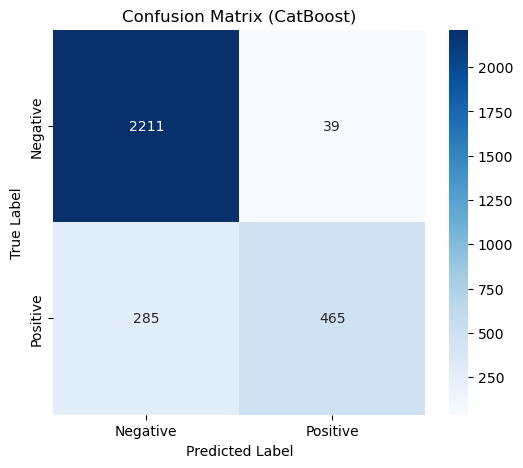

CatBoost metrics:
	ROC_AUC: 0.9171288888888889
	Accuracy: 0.892
	Precision: 0.9226190476190477
	Recall: 0.62
	F1-Score: 0.7416267942583732
[LightGBM] [Info] Number of positive: 1800, number of negative: 4200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408450
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1924
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
Training Time: 4.8421 seconds


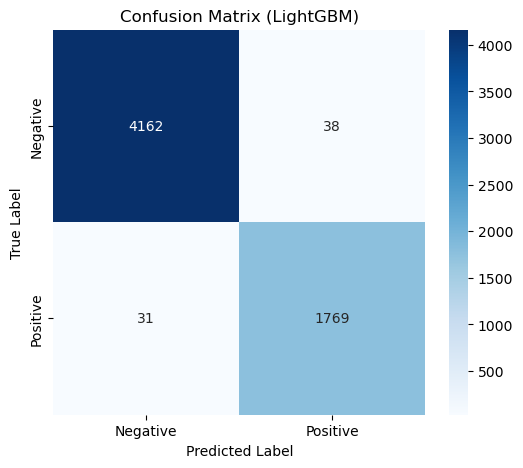

LightGBM metrics:
	ROC_AUC: 0.999559126984127
	Accuracy: 0.9885
	Precision: 0.9789706696181516
	Recall: 0.9827777777777778
	F1-Score: 0.9808705295259218


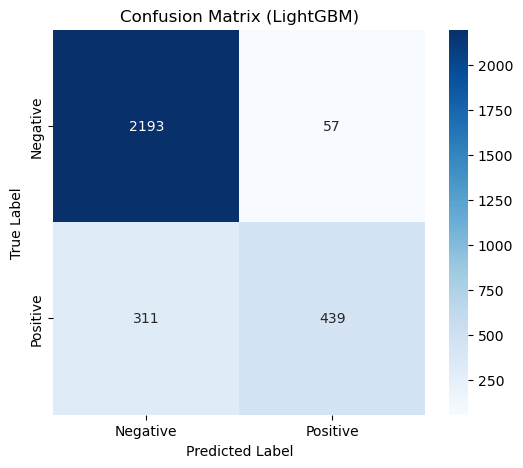

LightGBM metrics:
	ROC_AUC: 0.9073244444444444
	Accuracy: 0.8773333333333333
	Precision: 0.8850806451612904
	Recall: 0.5853333333333334
	F1-Score: 0.7046548956661316


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:45:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 7.1542 seconds


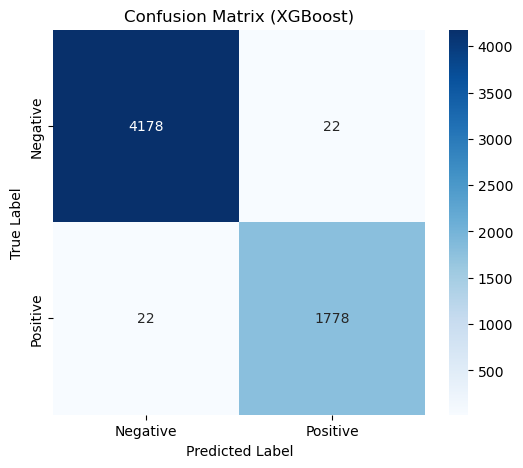

XGBoost metrics:
	ROC_AUC: 0.9997805555555556
	Accuracy: 0.9926666666666667
	Precision: 0.9877777777777778
	Recall: 0.9877777777777778
	F1-Score: 0.9877777777777778


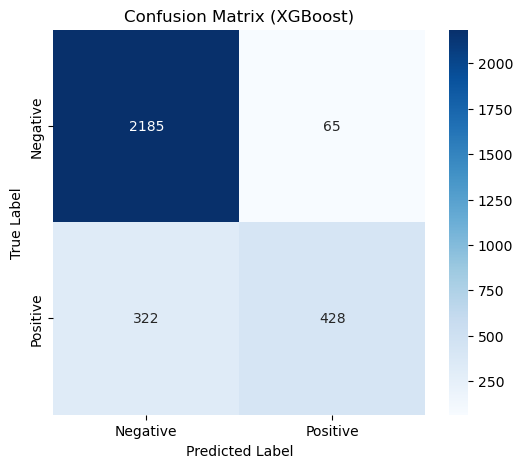

XGBoost metrics:
	ROC_AUC: 0.9006708148148148
	Accuracy: 0.871
	Precision: 0.8681541582150102
	Recall: 0.5706666666666667
	F1-Score: 0.6886564762670957
Training Time: 5.5490 seconds


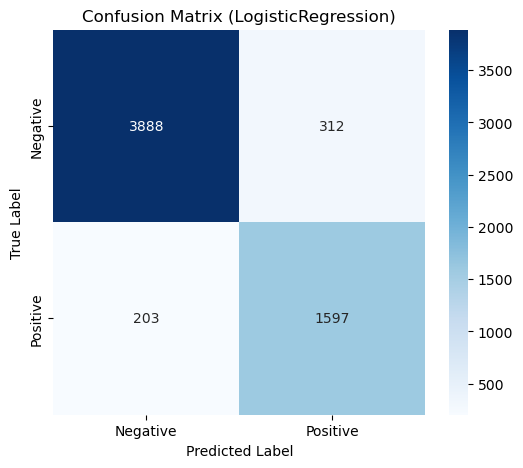

LogisticRegression metrics:
	ROC_AUC: 0.9689637566137566
	Accuracy: 0.9141666666666667
	Precision: 0.8365636458878994
	Recall: 0.8872222222222222
	F1-Score: 0.8611485575626854


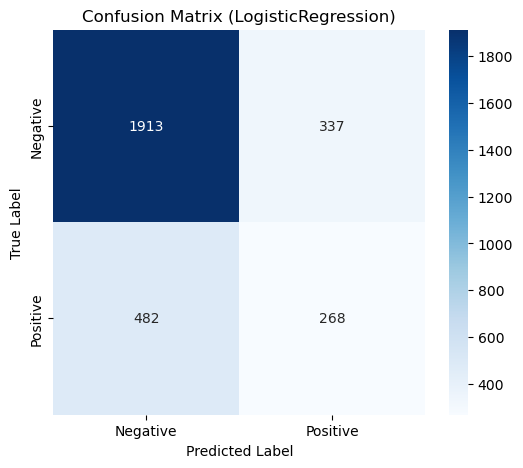

LogisticRegression metrics:
	ROC_AUC: 0.6967902222222222
	Accuracy: 0.727
	Precision: 0.44297520661157025
	Recall: 0.35733333333333334
	F1-Score: 0.3955719557195572


In [102]:
# testing models with SMOTE all standardized features with SMOTE validation
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_val_resampled, y_val_resampled, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

Training Time: 5.8813 seconds


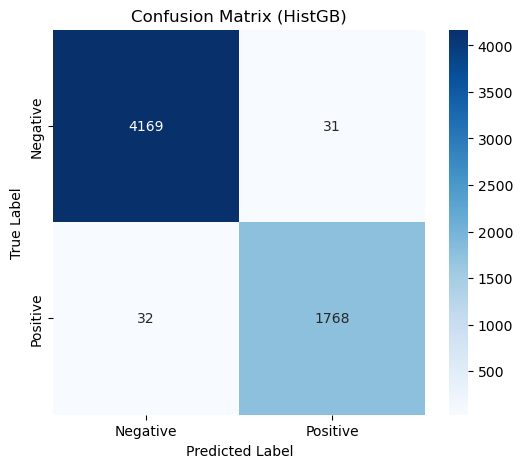

HistGB metrics:
	ROC_AUC: 0.9995073412698413
	Accuracy: 0.9895
	Precision: 0.9827682045580878
	Recall: 0.9822222222222222
	F1-Score: 0.982495137538205


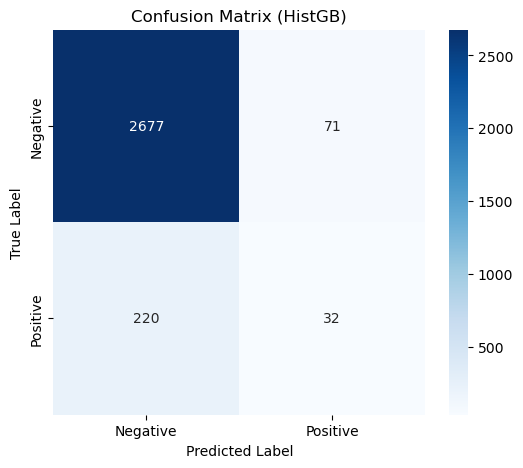

HistGB metrics:
	ROC_AUC: 0.7669213973799127
	Accuracy: 0.903
	Precision: 0.3106796116504854
	Recall: 0.12698412698412698
	F1-Score: 0.18028169014084508
Training Time: 63.8473 seconds


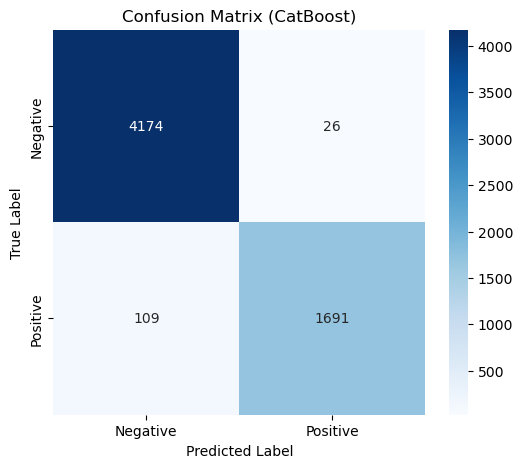

CatBoost metrics:
	ROC_AUC: 0.9982267857142857
	Accuracy: 0.9775
	Precision: 0.9848573092603378
	Recall: 0.9394444444444444
	F1-Score: 0.9616150127949957


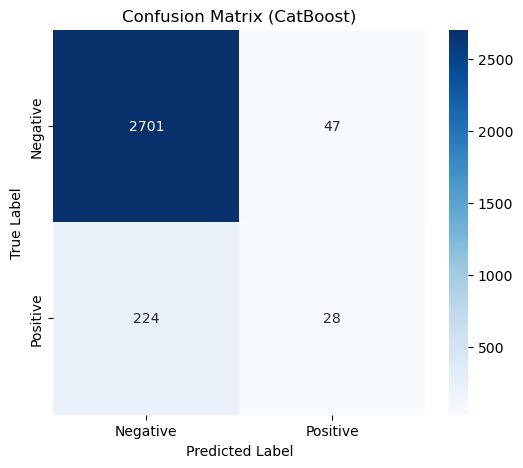

CatBoost metrics:
	ROC_AUC: 0.7761387791409625
	Accuracy: 0.9096666666666666
	Precision: 0.37333333333333335
	Recall: 0.1111111111111111
	F1-Score: 0.1712538226299694
[LightGBM] [Info] Number of positive: 1800, number of negative: 4200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408450
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1924
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
Training Time: 4.9529 seconds


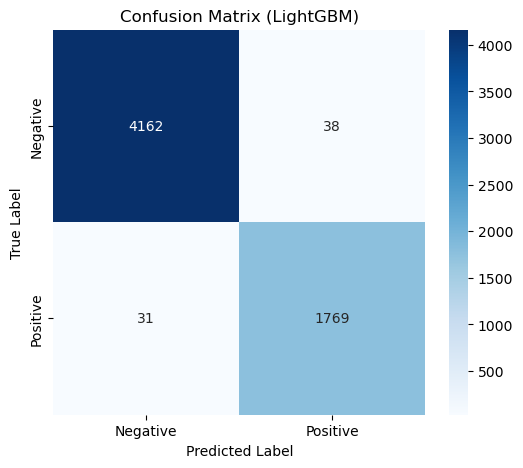

LightGBM metrics:
	ROC_AUC: 0.999559126984127
	Accuracy: 0.9885
	Precision: 0.9789706696181516
	Recall: 0.9827777777777778
	F1-Score: 0.9808705295259218


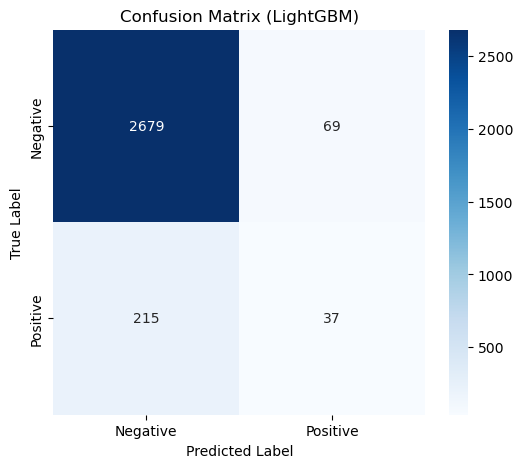

LightGBM metrics:
	ROC_AUC: 0.7639459289295534
	Accuracy: 0.9053333333333333
	Precision: 0.3490566037735849
	Recall: 0.14682539682539683
	F1-Score: 0.20670391061452514


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:54:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 8.1474 seconds


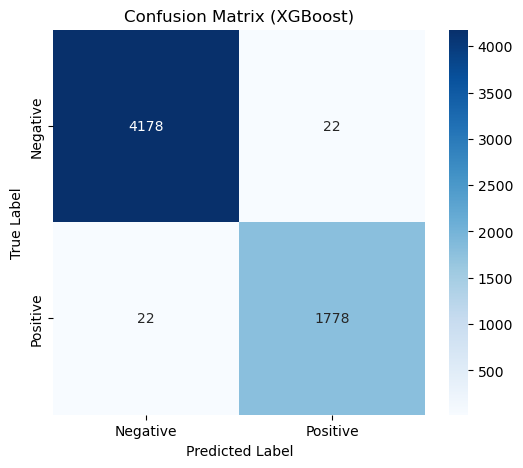

XGBoost metrics:
	ROC_AUC: 0.9997805555555556
	Accuracy: 0.9926666666666667
	Precision: 0.9877777777777778
	Recall: 0.9877777777777778
	F1-Score: 0.9877777777777778


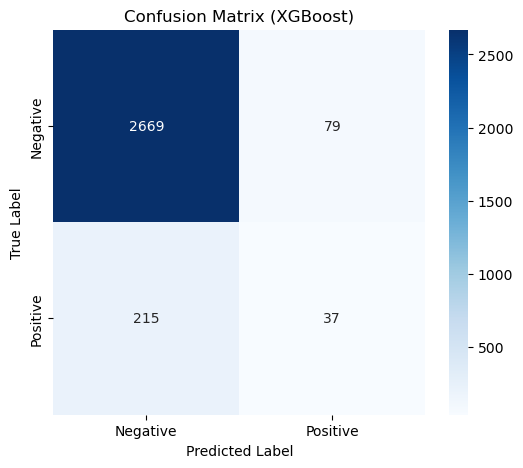

XGBoost metrics:
	ROC_AUC: 0.754355259813775
	Accuracy: 0.902
	Precision: 0.31896551724137934
	Recall: 0.14682539682539683
	F1-Score: 0.20108695652173914
Training Time: 4.4644 seconds


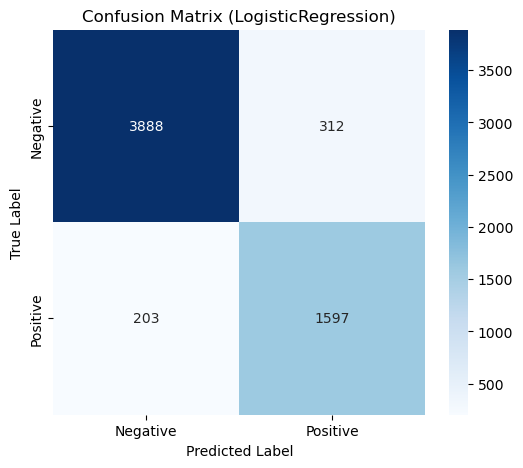

LogisticRegression metrics:
	ROC_AUC: 0.9689637566137566
	Accuracy: 0.9141666666666667
	Precision: 0.8365636458878994
	Recall: 0.8872222222222222
	F1-Score: 0.8611485575626854


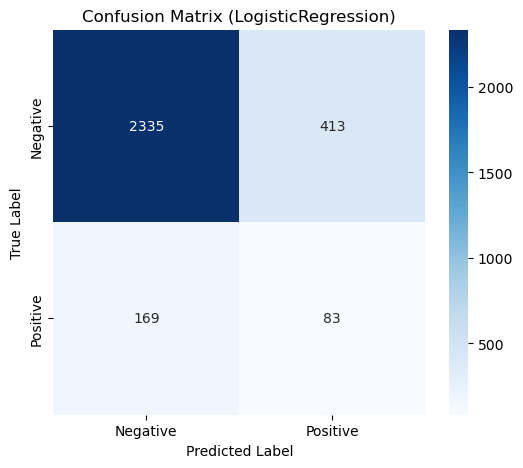

LogisticRegression metrics:
	ROC_AUC: 0.6591575980222268
	Accuracy: 0.806
	Precision: 0.16733870967741934
	Recall: 0.32936507936507936
	F1-Score: 0.22192513368983957


In [116]:
# testing models with SMOTE all standardized features with regular validation
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_val_standardized, y_val, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

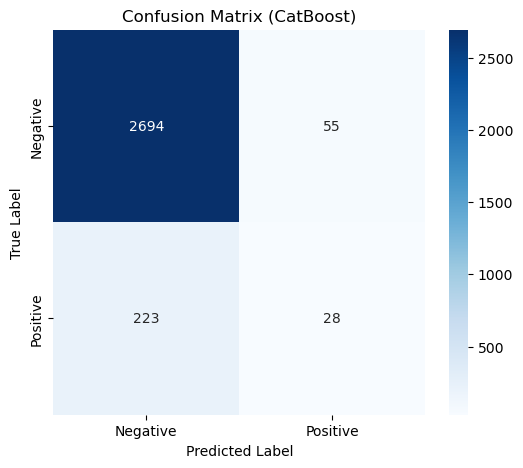

CatBoost metrics:
	ROC_AUC: 0.7446489052882685
	Accuracy: 0.9073333333333333
	Precision: 0.3373493975903614
	Recall: 0.11155378486055777
	F1-Score: 0.16766467065868262


In [117]:
# test metrics on regular validation
model_test = model_metrics['CatBoost'][0]
_ = get_metrics(X_test_standardized, y_test, model_test, 'CatBoost')

In [ ]:
########################
## SMOTE ratio 25% dq ##
########################
# HistGB metrics:
# 	ROC_AUC: 0.7785987211478478
# 	Accuracy: 0.908
# 	Precision: 0.36046511627906974
# 	Recall: 0.12301587301587301
# 	F1-Score: 0.1834319526627219

# CatBoost metrics:
# ROC_AUC: 0.7821417019015273 ------ BASELINE PERFORMANCE BEFORE HP TUNING
# 	Accuracy: 0.911
# 	Precision: 0.3728813559322034
# 	Recall: 0.0873015873015873
# 	F1-Score: 0.1414790996784566

# XGBoost metrics:
# 	ROC_AUC: 0.7425941810494211
# 	Accuracy: 0.9043333333333333
# 	Precision: 0.3364485981308411
# 	Recall: 0.14285714285714285
# 	F1-Score: 0.20055710306406685

## Week 7

#### Hyperparameter Tuning and Other Model Testing

In [105]:
# !pip install optuna

In [116]:
import optuna
import logging
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [109]:
X_train, X_test, y_train, y_test = split_data(features_df_DQ_no_na, test_size=0.25)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)
X_train_standardized, X_test_standardized = standardize(X_train, X_test)

In [110]:
def objective(trial, X, y):
    model_name = trial.suggest_categorical("model", ["HistGB", "LightGBM", "XGBoost", "CatBoost"])
    print(f"Trial {trial.number}: model {model_name}")
    logging.info(f"Trial {trial.number}: model {model_name}")
    
    if model_name == "HistGB":
        model = HistGradientBoostingClassifier(
            learning_rate=trial.suggest_float("lr", 0.01, 0.2, log=True),
            max_iter=trial.suggest_int("max_iter", 100, 1000),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 5, 50),
            l2_regularization=trial.suggest_float("l2_regularization", 0.001, 5.0, log=True),
            early_stopping=True
        )
    elif model_name == "CatBoost":
        model = CatBoostClassifier(
            learning_rate=trial.suggest_float("lr", 0.001, 0.3, log=True),
            depth=trial.suggest_int("depth", 3, 12),
            iterations=trial.suggest_int("iterations", 100, 2000),
            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1, 20, log=True),
            random_strength=trial.suggest_float("random_strength", 0, 10),
            verbose=0
        )
    elif model_name == "LightGBM":
        model = LGBMClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 2000),
            learning_rate=trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            num_leaves=trial.suggest_int("num_leaves", 8, 256),
            min_child_samples=trial.suggest_int("min_child_samples", 5, 100),
            # reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 10, log=True), for feature selection 
            reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 10, log=True), # for overfitting
            # colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            # subsample=trial.suggest_float("subsample", 0.5, 1.0),
            # min_split_gain=trial.suggest_float("min_split_gain", 0, 0.1),
            # boosting_type=trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
            verbose=-1
        )
    elif model_name == "XGBoost":
        model = XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 2000),
            learning_rate=trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            min_child_weight=trial.suggest_float("min_child_weight", 1, 10, log=True),
            gamma=trial.suggest_float("gamma", 0, 10),
            # reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 10, log=True),
            reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 10, log=True),
            eval_metric='logloss'
        )
    else:
        model = LogisticRegression(
            C=trial.suggest_float("C", 0.01, 10, log=True),
            max_iter=trial.suggest_int("max_iter", 100, 500)
        )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    score = np.mean(cross_val_score(model, X, y, cv=cv, scoring='roc_auc'))
    
    print(f"Trial {trial.number} - Model: {model_name}, Score: {score:.4f}")
    logging.info(f"Trial {trial.number} - Model: {model_name}, Score: {score:.4f}")
    
    return score

In [113]:
def run_optimization(X, y, n_trials=50):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)
    
    print("Best parameters:", study.best_params)
    return study

**For entire `final_features_df`**:

Best parameters: {'model': 'XGBoost', 'lr': 0.041860800774292085, 'n_estimators': 166, 'max_depth': 4} -- 0.7642097767193806

**For top 50 features**:

Best parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9} -- 0.7701703831605068

**For top 100 features**:

Best parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110} -- 0.7697076110002644

In [ ]:
study = run_optimization(X_train_standardized, y_train)

[I 2025-02-26 09:14:27,857] A new study created in memory with name: no-name-40f41470-72a2-4abe-a911-554696ad135c


Trial 0: model XGBoost


[I 2025-02-26 09:18:33,746] Trial 0 finished with value: 0.7645538027894629 and parameters: {'model': 'XGBoost', 'n_estimators': 1718, 'learning_rate': 0.06934347987038997, 'max_depth': 12, 'min_child_weight': 1.5746064819852736, 'gamma': 6.542746682984229, 'reg_lambda': 0.00014671195325972688}. Best is trial 0 with value: 0.7645538027894629.


Trial 0 - Model: XGBoost, Score: 0.7646
Trial 1: model HistGB


[I 2025-02-26 09:18:54,024] Trial 1 finished with value: 0.7552376242204507 and parameters: {'model': 'HistGB', 'lr': 0.11464248916903673, 'max_iter': 741, 'max_depth': 19, 'min_samples_leaf': 19, 'l2_regularization': 0.0029320743414777838}. Best is trial 0 with value: 0.7645538027894629.


Trial 1 - Model: HistGB, Score: 0.7552
Trial 2: model XGBoost


[I 2025-02-26 09:22:49,441] Trial 2 finished with value: 0.7702559011872473 and parameters: {'model': 'XGBoost', 'n_estimators': 1590, 'learning_rate': 0.10716811684230368, 'max_depth': 14, 'min_child_weight': 1.6853375704792999, 'gamma': 3.971769111328739, 'reg_lambda': 2.908478899796914}. Best is trial 2 with value: 0.7702559011872473.


Trial 2 - Model: XGBoost, Score: 0.7703
Trial 3: model HistGB


[I 2025-02-26 09:23:01,859] Trial 3 finished with value: 0.7589470546635939 and parameters: {'model': 'HistGB', 'lr': 0.1350075946131972, 'max_iter': 314, 'max_depth': 3, 'min_samples_leaf': 45, 'l2_regularization': 0.009531040884518163}. Best is trial 2 with value: 0.7702559011872473.


Trial 3 - Model: HistGB, Score: 0.7589
Trial 4: model CatBoost


[I 2025-02-26 09:41:23,859] Trial 4 finished with value: 0.775466286271984 and parameters: {'model': 'CatBoost', 'lr': 0.05359689012170398, 'depth': 10, 'iterations': 375, 'l2_leaf_reg': 5.605253157925136, 'random_strength': 1.4218885303330064}. Best is trial 4 with value: 0.775466286271984.


Trial 4 - Model: CatBoost, Score: 0.7755
Trial 5: model XGBoost


[I 2025-02-26 09:44:55,632] Trial 5 finished with value: 0.7367772046326415 and parameters: {'model': 'XGBoost', 'n_estimators': 546, 'learning_rate': 0.0012534424890638322, 'max_depth': 4, 'min_child_weight': 2.6863429856997136, 'gamma': 8.086380580569337, 'reg_lambda': 0.0062290131802228196}. Best is trial 4 with value: 0.775466286271984.


Trial 5 - Model: XGBoost, Score: 0.7368
Trial 6: model XGBoost


In [ ]:
df = study.trials_dataframe()
df.to_csv("optuna_trials.csv", index=False)  # Save as CSV

best_params = {
    "best_trial": study.best_trial.number,
    "best_value": study.best_value,
    "best_params": study.best_params
}

with open("optuna_best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)

print("Best parameters saved!")

In [159]:
X_train_standardized_l1_50, X_test_standardized_l1_50 = get_lasso_features(X_train_standardized, y_train, X_test_standardized)
X_train_standardized_l1_100, X_test_standardized_l1_100 = get_lasso_features(X_train_standardized, y_train, X_test_standardized, max_features=100)

In [156]:
run_optimization(X_train_standardized_l1_50, y_train)

[I 2025-02-16 09:25:43,668] A new study created in memory with name: no-name-1c77e256-6007-45d8-a8ab-f0d93425930e
[I 2025-02-16 09:25:43,778] Trial 0 finished with value: 0.7531442758468295 and parameters: {'model': 'LogisticRegression', 'C': 1.0472664916198309, 'max_iter': 284}. Best is trial 0 with value: 0.7531442758468295.
[I 2025-02-16 09:25:43,856] Trial 1 finished with value: 0.7458249201748403 and parameters: {'model': 'LogisticRegression', 'C': 0.06709733013676819, 'max_iter': 122}. Best is trial 0 with value: 0.7531442758468295.


Trial 0: model LogisticRegression
Trial 0 - Model: LogisticRegression, Score: 0.7531
Trial 1: model LogisticRegression
Trial 1 - Model: LogisticRegression, Score: 0.7458
Trial 2: model HistGB


[I 2025-02-16 09:25:46,347] Trial 2 finished with value: 0.7539314793758836 and parameters: {'model': 'HistGB', 'lr': 0.08816728583868495, 'max_iter': 107, 'max_depth': 11}. Best is trial 2 with value: 0.7539314793758836.


Trial 2 - Model: HistGB, Score: 0.7539
Trial 3: model HistGB


[I 2025-02-16 09:25:47,315] Trial 3 finished with value: 0.7336515763162376 and parameters: {'model': 'HistGB', 'lr': 0.012361297076622235, 'max_iter': 132, 'max_depth': 3}. Best is trial 2 with value: 0.7539314793758836.
[I 2025-02-16 09:25:47,385] Trial 4 finished with value: 0.7460898613682293 and parameters: {'model': 'LogisticRegression', 'C': 0.038735012861097595, 'max_iter': 465}. Best is trial 2 with value: 0.7539314793758836.


Trial 3 - Model: HistGB, Score: 0.7337
Trial 4: model LogisticRegression
Trial 4 - Model: LogisticRegression, Score: 0.7461
Trial 5: model HistGB


[I 2025-02-16 09:25:50,056] Trial 5 finished with value: 0.761660934200464 and parameters: {'model': 'HistGB', 'lr': 0.042227320896738446, 'max_iter': 112, 'max_depth': 12}. Best is trial 5 with value: 0.761660934200464.


Trial 5 - Model: HistGB, Score: 0.7617
Trial 6: model HistGB


[I 2025-02-16 09:25:53,750] Trial 6 finished with value: 0.7599202542078911 and parameters: {'model': 'HistGB', 'lr': 0.043679142168376706, 'max_iter': 296, 'max_depth': 5}. Best is trial 5 with value: 0.761660934200464.
[I 2025-02-16 09:25:53,865] Trial 7 finished with value: 0.7506398060423776 and parameters: {'model': 'LogisticRegression', 'C': 3.2554075797937676, 'max_iter': 498}. Best is trial 5 with value: 0.761660934200464.


Trial 6 - Model: HistGB, Score: 0.7599
Trial 7: model LogisticRegression
Trial 7 - Model: LogisticRegression, Score: 0.7506
Trial 8: model HistGB


[I 2025-02-16 09:25:59,953] Trial 8 finished with value: 0.7701703831605068 and parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:26:00,023] Trial 9 finished with value: 0.7440762042745592 and parameters: {'model': 'LogisticRegression', 'C': 0.028216778398336088, 'max_iter': 150}. Best is trial 8 with value: 0.7701703831605068.


Trial 8 - Model: HistGB, Score: 0.7702
Trial 9: model LogisticRegression
Trial 9 - Model: LogisticRegression, Score: 0.7441
Trial 10: model XGBoost


[I 2025-02-16 09:26:01,900] Trial 10 finished with value: 0.7422492186730005 and parameters: {'model': 'XGBoost', 'lr': 0.01457221071452907, 'n_estimators': 75, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 10 - Model: XGBoost, Score: 0.7422
Trial 11: model LightGBM


[I 2025-02-16 09:26:17,483] Trial 11 finished with value: 0.7562932900331849 and parameters: {'model': 'LightGBM', 'lr': 0.034992485562280295, 'n_estimators': 297, 'num_leaves': 149}. Best is trial 8 with value: 0.7701703831605068.


Trial 11 - Model: LightGBM, Score: 0.7563
Trial 12: model HistGB


[I 2025-02-16 09:26:19,334] Trial 12 finished with value: 0.7469720343975386 and parameters: {'model': 'HistGB', 'lr': 0.026668619677705365, 'max_iter': 67, 'max_depth': 12}. Best is trial 8 with value: 0.7701703831605068.


Trial 12 - Model: HistGB, Score: 0.7470
Trial 13: model HistGB


[I 2025-02-16 09:26:24,494] Trial 13 finished with value: 0.7485454797093171 and parameters: {'model': 'HistGB', 'lr': 0.09957022513037178, 'max_iter': 223, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 13 - Model: HistGB, Score: 0.7485
Trial 14: model LightGBM


[I 2025-02-16 09:26:26,978] Trial 14 finished with value: 0.762647418324113 and parameters: {'model': 'LightGBM', 'lr': 0.024064962487835583, 'n_estimators': 225, 'num_leaves': 22}. Best is trial 8 with value: 0.7701703831605068.


Trial 14 - Model: LightGBM, Score: 0.7626
Trial 15: model LightGBM


[I 2025-02-16 09:26:30,129] Trial 15 finished with value: 0.7616339924993543 and parameters: {'model': 'LightGBM', 'lr': 0.020267269173556337, 'n_estimators': 231, 'num_leaves': 29}. Best is trial 8 with value: 0.7701703831605068.


Trial 15 - Model: LightGBM, Score: 0.7616
Trial 16: model LightGBM


[I 2025-02-16 09:26:32,032] Trial 16 finished with value: 0.7577548066420576 and parameters: {'model': 'LightGBM', 'lr': 0.02023932166730442, 'n_estimators': 161, 'num_leaves': 25}. Best is trial 8 with value: 0.7701703831605068.


Trial 16 - Model: LightGBM, Score: 0.7578
Trial 17: model XGBoost


[I 2025-02-16 09:26:34,222] Trial 17 finished with value: 0.7433047040784755 and parameters: {'model': 'XGBoost', 'lr': 0.18623001723369195, 'n_estimators': 187, 'max_depth': 6}. Best is trial 8 with value: 0.7701703831605068.


Trial 17 - Model: XGBoost, Score: 0.7433
Trial 18: model LightGBM


[I 2025-02-16 09:26:44,526] Trial 18 finished with value: 0.7611168524789439 and parameters: {'model': 'LightGBM', 'lr': 0.010040659622634621, 'n_estimators': 279, 'num_leaves': 81}. Best is trial 8 with value: 0.7701703831605068.


Trial 18 - Model: LightGBM, Score: 0.7611
Trial 19: model LightGBM


[I 2025-02-16 09:26:48,105] Trial 19 finished with value: 0.7637136775352754 and parameters: {'model': 'LightGBM', 'lr': 0.0693469715881561, 'n_estimators': 111, 'num_leaves': 75}. Best is trial 8 with value: 0.7701703831605068.


Trial 19 - Model: LightGBM, Score: 0.7637
Trial 20: model XGBoost


[I 2025-02-16 09:26:50,132] Trial 20 finished with value: 0.7549517553666154 and parameters: {'model': 'XGBoost', 'lr': 0.08023739666449206, 'n_estimators': 69, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 20 - Model: XGBoost, Score: 0.7550
Trial 21: model LightGBM


[I 2025-02-16 09:26:53,796] Trial 21 finished with value: 0.7534160683993152 and parameters: {'model': 'LightGBM', 'lr': 0.06154660560214425, 'n_estimators': 133, 'num_leaves': 77}. Best is trial 8 with value: 0.7701703831605068.


Trial 21 - Model: LightGBM, Score: 0.7534
Trial 22: model LightGBM


[I 2025-02-16 09:26:56,984] Trial 22 finished with value: 0.7630476505423264 and parameters: {'model': 'LightGBM', 'lr': 0.024394070868699626, 'n_estimators': 124, 'num_leaves': 56}. Best is trial 8 with value: 0.7701703831605068.


Trial 22 - Model: LightGBM, Score: 0.7630
Trial 23: model LightGBM


[I 2025-02-16 09:26:59,731] Trial 23 finished with value: 0.7637548122785376 and parameters: {'model': 'LightGBM', 'lr': 0.030945350348099494, 'n_estimators': 115, 'num_leaves': 62}. Best is trial 8 with value: 0.7701703831605068.


Trial 23 - Model: LightGBM, Score: 0.7638
Trial 24: model LightGBM


[I 2025-02-16 09:27:04,810] Trial 24 finished with value: 0.758114121365095 and parameters: {'model': 'LightGBM', 'lr': 0.061900535474844864, 'n_estimators': 112, 'num_leaves': 116}. Best is trial 8 with value: 0.7701703831605068.


Trial 24 - Model: LightGBM, Score: 0.7581
Trial 25: model LightGBM


[I 2025-02-16 09:27:05,971] Trial 25 finished with value: 0.744947490348497 and parameters: {'model': 'LightGBM', 'lr': 0.15414171633677756, 'n_estimators': 52, 'num_leaves': 60}. Best is trial 8 with value: 0.7701703831605068.


Trial 25 - Model: LightGBM, Score: 0.7449
Trial 26: model LightGBM


[I 2025-02-16 09:27:09,833] Trial 26 finished with value: 0.7491572526522225 and parameters: {'model': 'LightGBM', 'lr': 0.0330306719395046, 'n_estimators': 99, 'num_leaves': 104}. Best is trial 8 with value: 0.7701703831605068.


Trial 26 - Model: LightGBM, Score: 0.7492
Trial 27: model HistGB


[I 2025-02-16 09:27:14,171] Trial 27 finished with value: 0.7626756698907794 and parameters: {'model': 'HistGB', 'lr': 0.03425883323164918, 'max_iter': 215, 'max_depth': 6}. Best is trial 8 with value: 0.7701703831605068.


Trial 27 - Model: HistGB, Score: 0.7627
Trial 28: model XGBoost


[I 2025-02-16 09:27:17,123] Trial 28 finished with value: 0.7630557918584907 and parameters: {'model': 'XGBoost', 'lr': 0.058050700592446124, 'n_estimators': 166, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 28 - Model: XGBoost, Score: 0.7631
Trial 29: model LightGBM


[I 2025-02-16 09:27:20,061] Trial 29 finished with value: 0.7459840965817328 and parameters: {'model': 'LightGBM', 'lr': 0.11732235458892129, 'n_estimators': 140, 'num_leaves': 56}. Best is trial 8 with value: 0.7701703831605068.


Trial 29 - Model: LightGBM, Score: 0.7460
Trial 30: model HistGB


[I 2025-02-16 09:27:26,721] Trial 30 finished with value: 0.7700138468262928 and parameters: {'model': 'HistGB', 'lr': 0.01640063201341833, 'max_iter': 273, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 30 - Model: HistGB, Score: 0.7700
Trial 31: model HistGB


[I 2025-02-16 09:27:33,388] Trial 31 finished with value: 0.7594481400313153 and parameters: {'model': 'HistGB', 'lr': 0.016498573283487444, 'max_iter': 268, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 31 - Model: HistGB, Score: 0.7594
Trial 32: model HistGB


[I 2025-02-16 09:27:39,461] Trial 32 finished with value: 0.7605283529388572 and parameters: {'model': 'HistGB', 'lr': 0.01575961868250496, 'max_iter': 244, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 32 - Model: HistGB, Score: 0.7605
Trial 33: model HistGB


[I 2025-02-16 09:27:43,563] Trial 33 finished with value: 0.7550328425153795 and parameters: {'model': 'HistGB', 'lr': 0.02983947029063918, 'max_iter': 188, 'max_depth': 7}. Best is trial 8 with value: 0.7701703831605068.


Trial 33 - Model: HistGB, Score: 0.7550
Trial 34: model HistGB


[I 2025-02-16 09:27:49,683] Trial 34 finished with value: 0.7624867060879295 and parameters: {'model': 'HistGB', 'lr': 0.019552815660166978, 'max_iter': 258, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:27:49,819] Trial 35 finished with value: 0.7543672195972013 and parameters: {'model': 'LogisticRegression', 'C': 9.756493671677912, 'max_iter': 358}. Best is trial 8 with value: 0.7701703831605068.


Trial 34 - Model: HistGB, Score: 0.7625
Trial 35: model LogisticRegression
Trial 35 - Model: LogisticRegression, Score: 0.7544
Trial 36: model HistGB


[I 2025-02-16 09:27:54,456] Trial 36 finished with value: 0.7642931761104609 and parameters: {'model': 'HistGB', 'lr': 0.04868603291725346, 'max_iter': 186, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 36 - Model: HistGB, Score: 0.7643
Trial 37: model HistGB


[I 2025-02-16 09:27:58,977] Trial 37 finished with value: 0.7528195742842638 and parameters: {'model': 'HistGB', 'lr': 0.04921087339199279, 'max_iter': 181, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 37 - Model: HistGB, Score: 0.7528
Trial 38: model HistGB


[I 2025-02-16 09:28:04,207] Trial 38 finished with value: 0.7576012605308741 and parameters: {'model': 'HistGB', 'lr': 0.012311359028905221, 'max_iter': 216, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 38 - Model: HistGB, Score: 0.7576
Trial 39: model HistGB


[I 2025-02-16 09:28:11,138] Trial 39 finished with value: 0.7638886525799388 and parameters: {'model': 'HistGB', 'lr': 0.03815099130261128, 'max_iter': 283, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 39 - Model: HistGB, Score: 0.7639
Trial 40: model HistGB


[I 2025-02-16 09:28:17,947] Trial 40 finished with value: 0.7474554343597103 and parameters: {'model': 'HistGB', 'lr': 0.04034629458229802, 'max_iter': 283, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 40 - Model: HistGB, Score: 0.7475
Trial 41: model HistGB


[I 2025-02-16 09:28:23,944] Trial 41 finished with value: 0.7513545780183724 and parameters: {'model': 'HistGB', 'lr': 0.0495143739322058, 'max_iter': 250, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 41 - Model: HistGB, Score: 0.7514
Trial 42: model HistGB


[I 2025-02-16 09:28:30,818] Trial 42 finished with value: 0.757339758963153 and parameters: {'model': 'HistGB', 'lr': 0.03952385438206622, 'max_iter': 287, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 42 - Model: HistGB, Score: 0.7573
Trial 43: model HistGB


[I 2025-02-16 09:28:36,748] Trial 43 finished with value: 0.7577423301928216 and parameters: {'model': 'HistGB', 'lr': 0.02868865409213526, 'max_iter': 236, 'max_depth': 12}. Best is trial 8 with value: 0.7701703831605068.


Trial 43 - Model: HistGB, Score: 0.7577
Trial 44: model HistGB


[I 2025-02-16 09:28:43,161] Trial 44 finished with value: 0.7644858948635499 and parameters: {'model': 'HistGB', 'lr': 0.022069101236521775, 'max_iter': 270, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 44 - Model: HistGB, Score: 0.7645
Trial 45: model HistGB


[I 2025-02-16 09:28:49,803] Trial 45 finished with value: 0.7536133100021315 and parameters: {'model': 'HistGB', 'lr': 0.013069600752474913, 'max_iter': 270, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 45 - Model: HistGB, Score: 0.7536
Trial 46: model HistGB


[I 2025-02-16 09:28:56,316] Trial 46 finished with value: 0.7667039149591452 and parameters: {'model': 'HistGB', 'lr': 0.023031119627119716, 'max_iter': 269, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 46 - Model: HistGB, Score: 0.7667
Trial 47: model HistGB


[I 2025-02-16 09:29:02,700] Trial 47 finished with value: 0.7602704994101467 and parameters: {'model': 'HistGB', 'lr': 0.023652337714215835, 'max_iter': 263, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:29:02,801] Trial 48 finished with value: 0.7500924086392848 and parameters: {'model': 'LogisticRegression', 'C': 0.269382539757453, 'max_iter': 335}. Best is trial 8 with value: 0.7701703831605068.


Trial 47 - Model: HistGB, Score: 0.7603
Trial 48: model LogisticRegression
Trial 48 - Model: LogisticRegression, Score: 0.7501
Trial 49: model HistGB


[I 2025-02-16 09:29:07,974] Trial 49 finished with value: 0.757329590562626 and parameters: {'model': 'HistGB', 'lr': 0.017664882654131436, 'max_iter': 229, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 49 - Model: HistGB, Score: 0.7573
Best parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9}


In [161]:
run_optimization(X_train_standardized_l1_100, y_train)

[I 2025-02-16 09:30:51,375] A new study created in memory with name: no-name-56327ae7-6d09-4e4b-ba66-14e1f94f1d30


Trial 0: model LightGBM


[I 2025-02-16 09:31:07,652] Trial 0 finished with value: 0.7641911318706711 and parameters: {'model': 'LightGBM', 'lr': 0.0234781276683241, 'n_estimators': 291, 'num_leaves': 102}. Best is trial 0 with value: 0.7641911318706711.


Trial 0 - Model: LightGBM, Score: 0.7642
Trial 1: model LogisticRegression


[I 2025-02-16 09:31:13,642] Trial 1 finished with value: 0.7507038770412037 and parameters: {'model': 'LogisticRegression', 'C': 1.5623683553091934, 'max_iter': 229}. Best is trial 0 with value: 0.7641911318706711.


Trial 1 - Model: LogisticRegression, Score: 0.7507
Trial 2: model LightGBM


[I 2025-02-16 09:31:21,184] Trial 2 finished with value: 0.747492634928692 and parameters: {'model': 'LightGBM', 'lr': 0.14199491247430626, 'n_estimators': 149, 'num_leaves': 100}. Best is trial 0 with value: 0.7641911318706711.


Trial 2 - Model: LightGBM, Score: 0.7475
Trial 3: model XGBoost


[I 2025-02-16 09:31:26,313] Trial 3 finished with value: 0.7620362500544701 and parameters: {'model': 'XGBoost', 'lr': 0.02686734068119967, 'n_estimators': 211, 'max_depth': 7}. Best is trial 0 with value: 0.7641911318706711.


Trial 3 - Model: XGBoost, Score: 0.7620
Trial 4: model XGBoost


[I 2025-02-16 09:31:28,258] Trial 4 finished with value: 0.7602788376155093 and parameters: {'model': 'XGBoost', 'lr': 0.028723191499087176, 'n_estimators': 86, 'max_depth': 6}. Best is trial 0 with value: 0.7641911318706711.


Trial 4 - Model: XGBoost, Score: 0.7603
Trial 5: model XGBoost


[I 2025-02-16 09:31:31,933] Trial 5 finished with value: 0.7677577400867006 and parameters: {'model': 'XGBoost', 'lr': 0.05426740800942819, 'n_estimators': 281, 'max_depth': 5}. Best is trial 5 with value: 0.7677577400867006.


Trial 5 - Model: XGBoost, Score: 0.7678
Trial 6: model XGBoost


[I 2025-02-16 09:31:38,546] Trial 6 finished with value: 0.746742798170075 and parameters: {'model': 'XGBoost', 'lr': 0.014715993057347719, 'n_estimators': 105, 'max_depth': 11}. Best is trial 5 with value: 0.7677577400867006.


Trial 6 - Model: XGBoost, Score: 0.7467
Trial 7: model LightGBM


[I 2025-02-16 09:31:48,205] Trial 7 finished with value: 0.7697076110002644 and parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110}. Best is trial 7 with value: 0.7697076110002644.


Trial 7 - Model: LightGBM, Score: 0.7697
Trial 8: model XGBoost


[I 2025-02-16 09:31:58,042] Trial 8 finished with value: 0.7539004887570911 and parameters: {'model': 'XGBoost', 'lr': 0.015578052166428203, 'n_estimators': 213, 'max_depth': 10}. Best is trial 7 with value: 0.7697076110002644.


Trial 8 - Model: XGBoost, Score: 0.7539
Trial 9: model HistGB


[I 2025-02-16 09:32:04,360] Trial 9 finished with value: 0.7696920736175653 and parameters: {'model': 'HistGB', 'lr': 0.014853162634938665, 'max_iter': 246, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 9 - Model: HistGB, Score: 0.7697
Trial 10: model LightGBM


[I 2025-02-16 09:32:06,554] Trial 10 finished with value: 0.7586481876051123 and parameters: {'model': 'LightGBM', 'lr': 0.06660847501015636, 'n_estimators': 150, 'num_leaves': 27}. Best is trial 7 with value: 0.7697076110002644.


Trial 10 - Model: LightGBM, Score: 0.7586
Trial 11: model HistGB


[I 2025-02-16 09:32:08,998] Trial 11 finished with value: 0.7499423316916964 and parameters: {'model': 'HistGB', 'lr': 0.010002786266514794, 'max_iter': 296, 'max_depth': 3}. Best is trial 7 with value: 0.7697076110002644.


Trial 11 - Model: HistGB, Score: 0.7499
Trial 12: model HistGB


[I 2025-02-16 09:32:10,919] Trial 12 finished with value: 0.7415895209923953 and parameters: {'model': 'HistGB', 'lr': 0.01087315484643933, 'max_iter': 59, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 12 - Model: HistGB, Score: 0.7416
Trial 13: model HistGB


[I 2025-02-16 09:32:15,858] Trial 13 finished with value: 0.7673320168106814 and parameters: {'model': 'HistGB', 'lr': 0.018640033814135686, 'max_iter': 165, 'max_depth': 12}. Best is trial 7 with value: 0.7697076110002644.


Trial 13 - Model: HistGB, Score: 0.7673
Trial 14: model LogisticRegression


[I 2025-02-16 09:32:18,638] Trial 14 finished with value: 0.7404432459317888 and parameters: {'model': 'LogisticRegression', 'C': 0.018583420419946248, 'max_iter': 476}. Best is trial 7 with value: 0.7697076110002644.


Trial 14 - Model: LogisticRegression, Score: 0.7404
Trial 15: model HistGB


[I 2025-02-16 09:32:25,380] Trial 15 finished with value: 0.7595379254835426 and parameters: {'model': 'HistGB', 'lr': 0.03666262211476673, 'max_iter': 262, 'max_depth': 8}. Best is trial 7 with value: 0.7697076110002644.


Trial 15 - Model: HistGB, Score: 0.7595
Trial 16: model LightGBM


[I 2025-02-16 09:32:36,176] Trial 16 finished with value: 0.7679896845507896 and parameters: {'model': 'LightGBM', 'lr': 0.08753921675960269, 'n_estimators': 211, 'num_leaves': 143}. Best is trial 7 with value: 0.7697076110002644.


Trial 16 - Model: LightGBM, Score: 0.7680
Trial 17: model HistGB


[I 2025-02-16 09:32:38,395] Trial 17 finished with value: 0.762808981467401 and parameters: {'model': 'HistGB', 'lr': 0.03818348829101968, 'max_iter': 179, 'max_depth': 4}. Best is trial 7 with value: 0.7697076110002644.


Trial 17 - Model: HistGB, Score: 0.7628
Trial 18: model LightGBM


[I 2025-02-16 09:32:39,807] Trial 18 finished with value: 0.751974680918714 and parameters: {'model': 'LightGBM', 'lr': 0.019177098301862885, 'n_estimators': 53, 'num_leaves': 50}. Best is trial 7 with value: 0.7697076110002644.


Trial 18 - Model: LightGBM, Score: 0.7520
Trial 19: model LogisticRegression


[I 2025-02-16 09:32:46,739] Trial 19 finished with value: 0.7510814854008325 and parameters: {'model': 'LogisticRegression', 'C': 7.840121882646625, 'max_iter': 407}. Best is trial 7 with value: 0.7697076110002644.


Trial 19 - Model: LogisticRegression, Score: 0.7511
Trial 20: model LightGBM


[I 2025-02-16 09:32:53,610] Trial 20 finished with value: 0.7522777595710355 and parameters: {'model': 'LightGBM', 'lr': 0.1894502862178441, 'n_estimators': 240, 'num_leaves': 148}. Best is trial 7 with value: 0.7697076110002644.


Trial 20 - Model: LightGBM, Score: 0.7523
Trial 21: model LightGBM


[I 2025-02-16 09:33:03,092] Trial 21 finished with value: 0.7659665079815285 and parameters: {'model': 'LightGBM', 'lr': 0.08997910618608276, 'n_estimators': 177, 'num_leaves': 146}. Best is trial 7 with value: 0.7697076110002644.


Trial 21 - Model: LightGBM, Score: 0.7660
Trial 22: model LightGBM


[I 2025-02-16 09:33:12,098] Trial 22 finished with value: 0.7538377864506571 and parameters: {'model': 'LightGBM', 'lr': 0.09336355020789654, 'n_estimators': 182, 'num_leaves': 120}. Best is trial 7 with value: 0.7697076110002644.


Trial 22 - Model: LightGBM, Score: 0.7538
Trial 23: model LightGBM


[I 2025-02-16 09:33:23,872] Trial 23 finished with value: 0.7586723387873817 and parameters: {'model': 'LightGBM', 'lr': 0.08458172283580215, 'n_estimators': 247, 'num_leaves': 124}. Best is trial 7 with value: 0.7697076110002644.


Trial 23 - Model: LightGBM, Score: 0.7587
Trial 24: model HistGB


[I 2025-02-16 09:33:25,787] Trial 24 finished with value: 0.7499703149679766 and parameters: {'model': 'HistGB', 'lr': 0.12207394875463493, 'max_iter': 68, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 24 - Model: HistGB, Score: 0.7500
Trial 25: model LightGBM


[I 2025-02-16 09:33:30,422] Trial 25 finished with value: 0.7683542999123256 and parameters: {'model': 'LightGBM', 'lr': 0.013134132651001629, 'n_estimators': 134, 'num_leaves': 77}. Best is trial 7 with value: 0.7697076110002644.


Trial 25 - Model: LightGBM, Score: 0.7684
Trial 26: model LightGBM


[I 2025-02-16 09:33:34,840] Trial 26 finished with value: 0.7541221826986767 and parameters: {'model': 'LightGBM', 'lr': 0.013145180614396611, 'n_estimators': 123, 'num_leaves': 75}. Best is trial 7 with value: 0.7697076110002644.


Trial 26 - Model: LightGBM, Score: 0.7541
Trial 27: model HistGB


[I 2025-02-16 09:33:38,613] Trial 27 finished with value: 0.7568503197757229 and parameters: {'model': 'HistGB', 'lr': 0.020624110458774676, 'max_iter': 127, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 27 - Model: HistGB, Score: 0.7569
Trial 28: model LogisticRegression


[I 2025-02-16 09:33:42,040] Trial 28 finished with value: 0.7457509426325343 and parameters: {'model': 'LogisticRegression', 'C': 0.035302875438871506, 'max_iter': 345}. Best is trial 7 with value: 0.7697076110002644.


Trial 28 - Model: LogisticRegression, Score: 0.7458
Trial 29: model LightGBM


[I 2025-02-16 09:33:47,172] Trial 29 finished with value: 0.7576580481559546 and parameters: {'model': 'LightGBM', 'lr': 0.01326132900324483, 'n_estimators': 145, 'num_leaves': 78}. Best is trial 7 with value: 0.7697076110002644.


Trial 29 - Model: LightGBM, Score: 0.7577
Trial 30: model LightGBM


[I 2025-02-16 09:33:49,331] Trial 30 finished with value: 0.7554167892970993 and parameters: {'model': 'LightGBM', 'lr': 0.017021905637995972, 'n_estimators': 76, 'num_leaves': 58}. Best is trial 7 with value: 0.7697076110002644.


Trial 30 - Model: LightGBM, Score: 0.7554
Trial 31: model LightGBM


[I 2025-02-16 09:33:59,603] Trial 31 finished with value: 0.7638096780458197 and parameters: {'model': 'LightGBM', 'lr': 0.029787291826839223, 'n_estimators': 207, 'num_leaves': 124}. Best is trial 7 with value: 0.7697076110002644.


Trial 31 - Model: LightGBM, Score: 0.7638
Trial 32: model LightGBM


[I 2025-02-16 09:34:06,760] Trial 32 finished with value: 0.7604089017221437 and parameters: {'model': 'LightGBM', 'lr': 0.05380750714637335, 'n_estimators': 178, 'num_leaves': 95}. Best is trial 7 with value: 0.7697076110002644.


Trial 32 - Model: LightGBM, Score: 0.7604
Trial 33: model LightGBM


[I 2025-02-16 09:34:13,394] Trial 33 finished with value: 0.7571065003807038 and parameters: {'model': 'LightGBM', 'lr': 0.01296212450868658, 'n_estimators': 133, 'num_leaves': 134}. Best is trial 7 with value: 0.7697076110002644.


Trial 33 - Model: LightGBM, Score: 0.7571
Trial 34: model LightGBM


[I 2025-02-16 09:34:23,869] Trial 34 finished with value: 0.763064900726364 and parameters: {'model': 'LightGBM', 'lr': 0.023643929105258355, 'n_estimators': 237, 'num_leaves': 110}. Best is trial 7 with value: 0.7697076110002644.


Trial 34 - Model: LightGBM, Score: 0.7631
Trial 35: model LightGBM


[I 2025-02-16 09:34:29,309] Trial 35 finished with value: 0.7578837143586615 and parameters: {'model': 'LightGBM', 'lr': 0.01141593237979808, 'n_estimators': 192, 'num_leaves': 64}. Best is trial 7 with value: 0.7697076110002644.


Trial 35 - Model: LightGBM, Score: 0.7579
Trial 36: model LogisticRegression


[I 2025-02-16 09:34:34,840] Trial 36 finished with value: 0.7465818800085691 and parameters: {'model': 'LogisticRegression', 'C': 0.2768818229068465, 'max_iter': 376}. Best is trial 7 with value: 0.7697076110002644.


Trial 36 - Model: LogisticRegression, Score: 0.7466
Trial 37: model HistGB


[I 2025-02-16 09:34:38,734] Trial 37 finished with value: 0.7630423784196966 and parameters: {'model': 'HistGB', 'lr': 0.024283347783343078, 'max_iter': 209, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 37 - Model: HistGB, Score: 0.7630
Trial 38: model XGBoost


[I 2025-02-16 09:34:39,872] Trial 38 finished with value: 0.7465328720468103 and parameters: {'model': 'XGBoost', 'lr': 0.035083482653063776, 'n_estimators': 113, 'max_depth': 3}. Best is trial 7 with value: 0.7697076110002644.


Trial 38 - Model: XGBoost, Score: 0.7465
Trial 39: model LightGBM


[I 2025-02-16 09:34:46,482] Trial 39 finished with value: 0.7671530981983263 and parameters: {'model': 'LightGBM', 'lr': 0.04883565863029069, 'n_estimators': 167, 'num_leaves': 89}. Best is trial 7 with value: 0.7697076110002644.


Trial 39 - Model: LightGBM, Score: 0.7672
Trial 40: model XGBoost


[I 2025-02-16 09:34:53,355] Trial 40 finished with value: 0.7463067396554525 and parameters: {'model': 'XGBoost', 'lr': 0.06684712128924616, 'n_estimators': 270, 'max_depth': 8}. Best is trial 7 with value: 0.7697076110002644.


Trial 40 - Model: XGBoost, Score: 0.7463
Trial 41: model XGBoost


[I 2025-02-16 09:34:57,206] Trial 41 finished with value: 0.7628100744681434 and parameters: {'model': 'XGBoost', 'lr': 0.06114988633926783, 'n_estimators': 295, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 41 - Model: XGBoost, Score: 0.7628
Trial 42: model XGBoost


[I 2025-02-16 09:35:01,786] Trial 42 finished with value: 0.7556816747276632 and parameters: {'model': 'XGBoost', 'lr': 0.1131138710875235, 'n_estimators': 276, 'max_depth': 6}. Best is trial 7 with value: 0.7697076110002644.


Trial 42 - Model: XGBoost, Score: 0.7557
Trial 43: model XGBoost


[I 2025-02-16 09:35:04,257] Trial 43 finished with value: 0.7500386372542565 and parameters: {'model': 'XGBoost', 'lr': 0.01541550696872734, 'n_estimators': 161, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 43 - Model: XGBoost, Score: 0.7500
Trial 44: model XGBoost


[I 2025-02-16 09:35:08,652] Trial 44 finished with value: 0.7615596218369267 and parameters: {'model': 'XGBoost', 'lr': 0.07536379977496643, 'n_estimators': 262, 'max_depth': 6}. Best is trial 7 with value: 0.7697076110002644.


Trial 44 - Model: XGBoost, Score: 0.7616
Trial 45: model HistGB


[I 2025-02-16 09:35:10,209] Trial 45 finished with value: 0.763311558570875 and parameters: {'model': 'HistGB', 'lr': 0.043519767993477766, 'max_iter': 112, 'max_depth': 4}. Best is trial 7 with value: 0.7697076110002644.


Trial 45 - Model: HistGB, Score: 0.7633
Trial 46: model LightGBM


[I 2025-02-16 09:35:17,302] Trial 46 finished with value: 0.7549684421776531 and parameters: {'model': 'LightGBM', 'lr': 0.16762481006008917, 'n_estimators': 199, 'num_leaves': 135}. Best is trial 7 with value: 0.7697076110002644.


Trial 46 - Model: LightGBM, Score: 0.7550
Trial 47: model XGBoost


[I 2025-02-16 09:35:21,051] Trial 47 finished with value: 0.761499302551099 and parameters: {'model': 'XGBoost', 'lr': 0.02943871968224155, 'n_estimators': 142, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 47 - Model: XGBoost, Score: 0.7615
Trial 48: model HistGB


[I 2025-02-16 09:35:27,183] Trial 48 finished with value: 0.7664462174004768 and parameters: {'model': 'HistGB', 'lr': 0.011689121724646345, 'max_iter': 217, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 48 - Model: HistGB, Score: 0.7664
Trial 49: model LogisticRegression


[I 2025-02-16 09:35:32,639] Trial 49 finished with value: 0.7493048109658852 and parameters: {'model': 'LogisticRegression', 'C': 0.18861654917775247, 'max_iter': 304}. Best is trial 7 with value: 0.7697076110002644.


Trial 49 - Model: LogisticRegression, Score: 0.7493
Best parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110}


## Week 8

#### Scoring Exclusions

**Criteria to exclude consumers**

- minimum number of transactions
    - 5% of consumers have <=14 transactions, 2% have <=3, 1% < 2
    - decided on at having **at least 2 transactions**
- minimum number of credits and debits
    - 16 consumers with no credits, 296 consumers with no debits
    - decided on **having at least 1 credit and 1 debit transaction**
- minimum balance
    - 2.84% of consumers have balance < 0, 3.97% have balance <= 0, 1.13% have balance = 0
    - does it make more sense to drop the consumers with balance of 0? that holds less information than if a balance is negative
    - decided on **having nonzero balance**
- number of consumers meeting all criteria: 12250

In [50]:
# minimum number of transactions
trxn_counts = trxn_df.groupby('prism_consumer_id')['prism_transaction_id'].count()
cons_at_least_2_trxns = trxn_counts[trxn_counts >= 2].index

In [51]:
# consumers with non zero balance
balance_sum = acct_df.groupby('prism_consumer_id')['balance'].sum()
cons_non_zero_balances = balance_sum[balance_sum != 0].index

In [52]:
# consumers with at least 1 credit and debit transaction
credit_debit_counts = trxn_df.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
credit_debit_counts.columns = ['num_credits', 'num_debits']
cons_non_zero_credits = credit_debit_counts[credit_debit_counts.num_credits > 0].index
cons_non_zero_debits = credit_debit_counts[credit_debit_counts.num_debits > 0].index
cons_has_both_credits_debits = credit_debit_counts[((credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index

In [223]:
len(set(cons_at_least_2_trxns).intersection(set(cons_non_zero_balances)))

12378

In [228]:
len(set(cons_at_least_2_trxns).intersection(set(cons_non_zero_balances)).intersection(set(cons_has_both_credits_debits)))

12250

In [53]:
len(cons_at_least_2_trxns), len(cons_non_zero_balances), len(cons_has_both_credits_debits)

(14329, 12861, 14180)

In [56]:
def exclude_consumers(cons_df, acct_df, trxn_df):
    # minimum number of transactions
    trxn_counts = trxn_df.groupby('prism_consumer_id')['prism_transaction_id'].count()
    cons_at_least_2_trxns = set(trxn_counts[trxn_counts >= 2].index)

    # consumers with non zero balance
    balance_sum = acct_df.groupby('prism_consumer_id')['balance'].sum()
    cons_non_zero_balances = set(balance_sum[balance_sum != 0].index)

    # consumers with at least 1 credit and debit transaction
    credit_debit_counts = trxn_df.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
    credit_debit_counts.columns = ['num_credits', 'num_debits']
    cons_non_zero_credits = set(credit_debit_counts[credit_debit_counts.num_credits > 0].index)
    cons_non_zero_debits = set(credit_debit_counts[credit_debit_counts.num_debits > 0].index)
    cons_has_both_credits_debits = set(credit_debit_counts[((credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index)

    # don't do balance exclusion
    return cons_at_least_2_trxns.intersection(cons_has_both_credits_debits)
    # return cons_at_least_2_trxns.intersection(cons_non_zero_balances).intersection(cons_has_both_credits_debits)

In [57]:
kept_consumers = exclude_consumers(cons_df, acct_df, trxn_df)

In [59]:
features_df_scoring_exclusions = features_df[features_df.prism_consumer_id.isin(kept_consumers)]

In [60]:
X_train_score_exc, X_test_score_exc, y_train_score_exc, y_test_score_exc = split_data(features_df_scoring_exclusions)
X_train_standardized_score_exc, X_test_standardized_score_exc = standardize(X_train_score_exc, X_test_score_exc)

Training Time: 10.8200 seconds


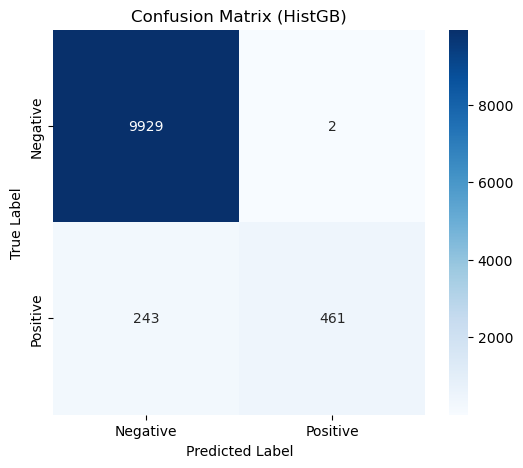

HistGB metrics:
	ROC_AUC: 0.9810053717239864
	Accuracy: 0.9769628584861307
	Precision: 0.9956803455723542
	Recall: 0.6548295454545454
	F1-Score: 0.7900599828620394


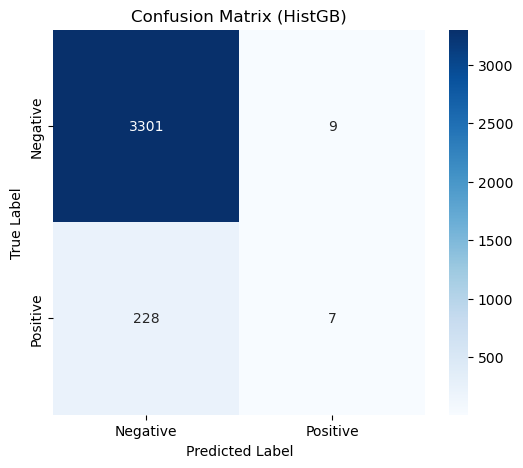

HistGB metrics:
	ROC_AUC: 0.7924959825159092
	Accuracy: 0.9331452750352609
	Precision: 0.4375
	Recall: 0.029787234042553193
	F1-Score: 0.055776892430278883
Training Time: 189.0939 seconds


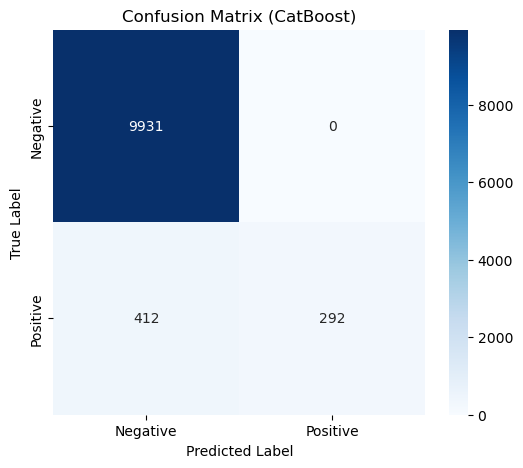

CatBoost metrics:
	ROC_AUC: 0.9929743211111213
	Accuracy: 0.9612599905970851
	Precision: 1.0
	Recall: 0.4147727272727273
	F1-Score: 0.5863453815261044


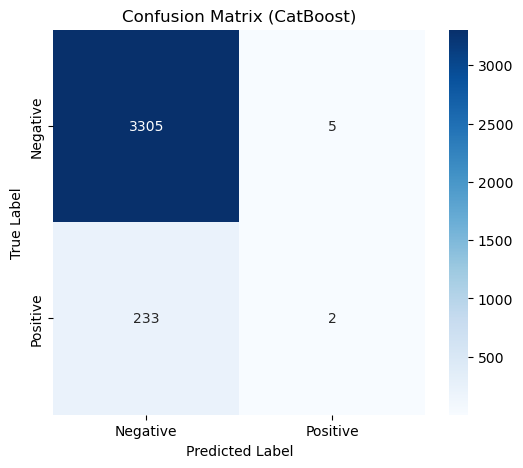

CatBoost metrics:
	ROC_AUC: 0.8049906794369095
	Accuracy: 0.9328631875881523
	Precision: 0.2857142857142857
	Recall: 0.00851063829787234
	F1-Score: 0.01652892561983471
[LightGBM] [Info] Number of positive: 704, number of negative: 9931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393714
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 1928
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066197 -> initscore=-2.646638
[LightGBM] [Info] Start training from score -2.646638
Training Time: 16.9684 seconds


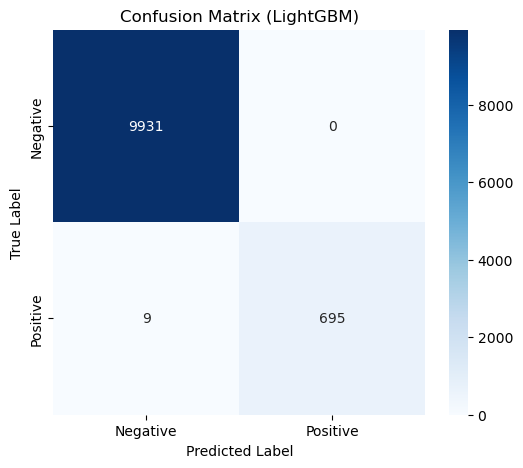

LightGBM metrics:
	ROC_AUC: 0.9999980690628976
	Accuracy: 0.9991537376586742
	Precision: 1.0
	Recall: 0.9872159090909091
	F1-Score: 0.993566833452466


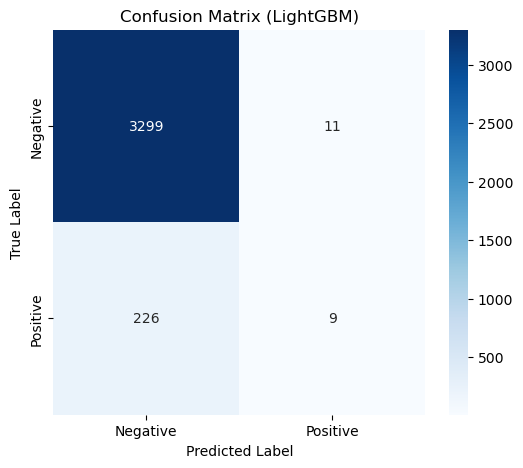

LightGBM metrics:
	ROC_AUC: 0.7895583981487434
	Accuracy: 0.9331452750352609
	Precision: 0.45
	Recall: 0.03829787234042553
	F1-Score: 0.07058823529411765


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:40:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 37.6062 seconds


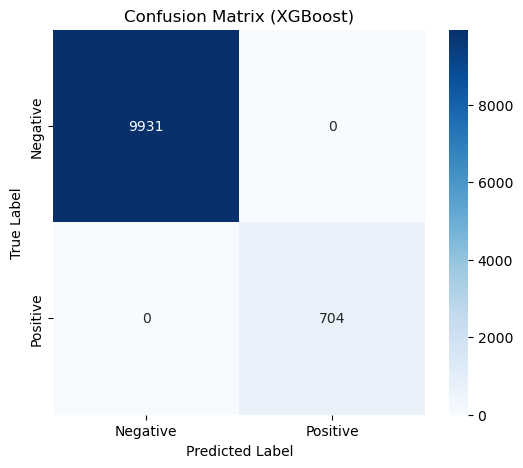

XGBoost metrics:
	ROC_AUC: 1.0
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-Score: 1.0


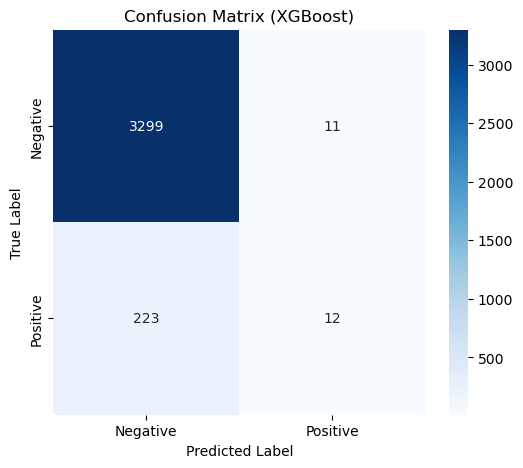

XGBoost metrics:
	ROC_AUC: 0.7797274538792827
	Accuracy: 0.9339915373765867
	Precision: 0.5217391304347826
	Recall: 0.05106382978723404
	F1-Score: 0.09302325581395349
Training Time: 7.3899 seconds


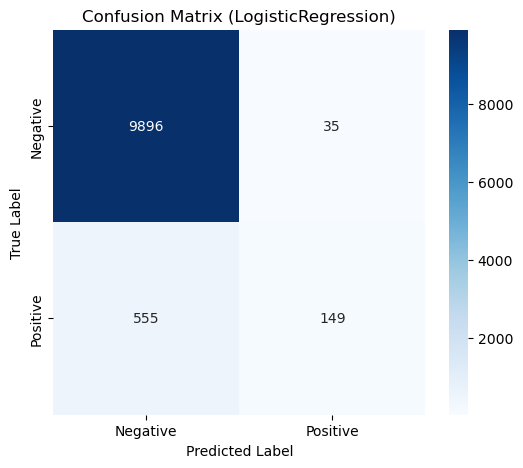

LogisticRegression metrics:
	ROC_AUC: 0.9129985536565941
	Accuracy: 0.9445228020686413
	Precision: 0.8097826086956522
	Recall: 0.21164772727272727
	F1-Score: 0.3355855855855856


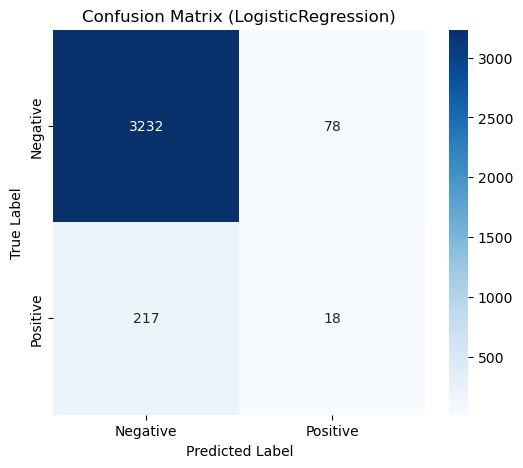

LogisticRegression metrics:
	ROC_AUC: 0.7226740374108118
	Accuracy: 0.9167842031029619
	Precision: 0.1875
	Recall: 0.07659574468085106
	F1-Score: 0.10876132930513595


In [63]:
# testing models with scoring exclusions
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(
        X_train_standardized_score_exc, y_train_score_exc, X_test_standardized_score_exc, y_test_score_exc, model_type=model_type
    )
    model_metrics[model_type] = [model, metrics]

## Week 9

#### Shapley Values

In [30]:
import shap

Training Time: 103.4598 seconds


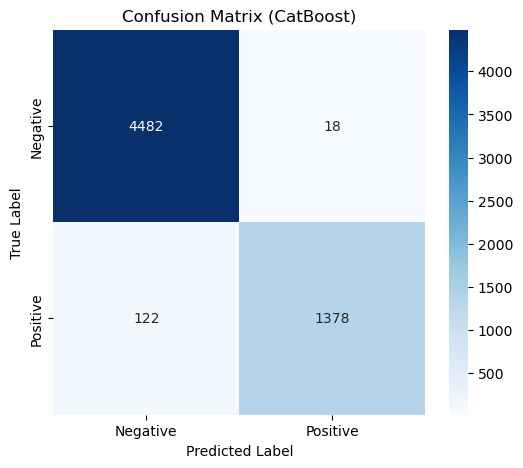

CatBoost metrics:
	ROC_AUC: 0.9983642962962963
	Accuracy: 0.9766666666666667
	Precision: 0.9871060171919771
	Recall: 0.9186666666666666
	F1-Score: 0.9516574585635359


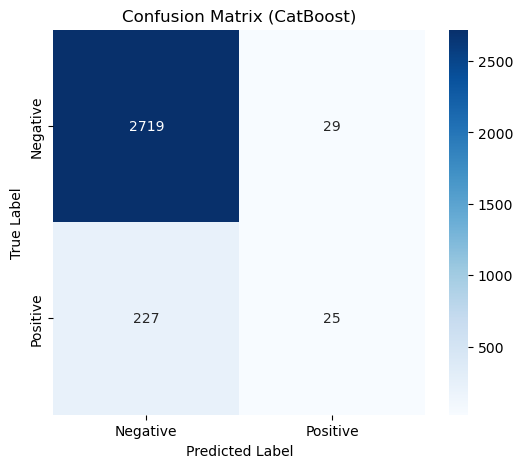

CatBoost metrics:
	ROC_AUC: 0.79530856495922
	Accuracy: 0.9146666666666666
	Precision: 0.46296296296296297
	Recall: 0.0992063492063492
	F1-Score: 0.16339869281045752


In [38]:
catboost, test_metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_val_standardized, y_val, 'CatBoost')

In [227]:
def get_shap_values(X_train, X_val, model):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_val)
    return explainer, shap_values

In [228]:
explainer, shap_values = get_shap_values(X_train_resampled, X_val_standardized, catboost)

 99%|===================| 2983/3000 [01:44<00:00]        

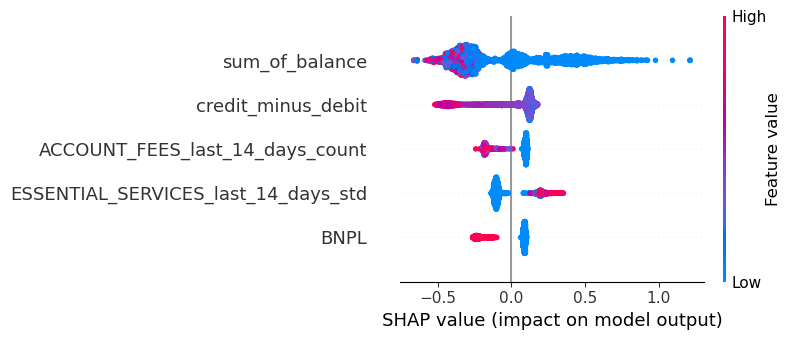

In [229]:
shap.summary_plot(shap_values, X_val_standardized, max_display=5)

In [223]:
shap.force_plot(explainer.expected_value, shap_values[0].values, X_val_standardized.iloc[0])

In [87]:
def get_top_reasons(explainer, X, shap_values, i, n=3):
    shap_instance = shap_values[i].values
    features = X.columns
    
    top = np.argsort(np.abs(shap_instance))[-n:]
    filtered_shap = shap_instance[top]
    filtered_features = features[top]
    feature_labels = [
        f"{feature}_HIGH" if shap_value > 0 else f"{feature}_LOW"
        for feature, shap_value in zip(filtered_features, filtered_shap)
    ]

    return feature_labels, shap.force_plot(explainer.expected_value, filtered_shap, X.iloc[i, top])

In [224]:
features, plot = get_top_reasons(explainer, X_val_standardized, shap_values, 0)
plot

In [235]:
def get_reason_codes(explainer, X, shap_values):
    reason_codes_by_consumer = []
    for i in range(len(X)):
        top_3_features, plot = get_top_reasons(explainer, X, shap_values, i)
        reason_codes_by_consumer.append(list(top_3_features))
    reason_codes_by_consumer = np.array(reason_codes_by_consumer)
    return reason_codes_by_consumer

In [240]:
def plot_reason_codes_distribution(reason_codes_by_consumer):
    reason_codes = reason_codes_by_consumer.ravel()
    unique_reason_codes, reason_codes_counts = np.unique(reason_codes, return_counts=True)
    unique_reason_codes = unique_reason_codes[np.argsort(-reason_codes_counts)][:30]
    reason_codes_counts = reason_codes_counts[np.argsort(-reason_codes_counts)][:30]
    reason_codes_props = reason_codes_counts[np.argsort(-reason_codes_counts)][:30] / reason_codes_counts.sum()
    
    plt.figure(figsize=(10,5))
    plt.bar(unique_reason_codes, reason_codes_props)
    plt.xticks(rotation=45, ha="right")
    
    for i, (prop, count) in enumerate(zip(reason_codes_props, reason_codes_counts)):
        plt.text(i, prop + 0.001, str(count), ha="center", fontsize=10)
    
    plt.title("Distribution of Reason Codes")
    plt.xlabel("Reason Code")
    plt.ylabel("Count")
    plt.show()

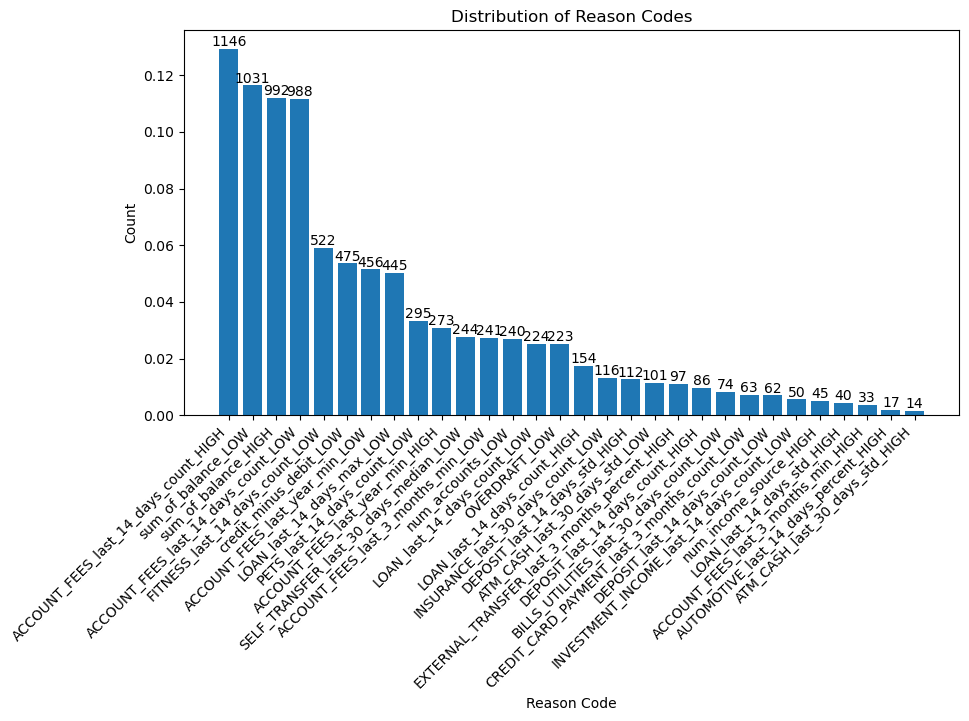

In [242]:
reason_codes_by_consumer_val = get_reason_codes(explainer, X_val_standardized, shap_values)
plot_reason_codes_distribution(reason_codes_by_consumer_val)

In [137]:
final_X_train, final_y_train = (
    features_df_DQ_no_na.drop(columns=['prism_consumer_id', 'DQ_TARGET', 'evaluation_date', 'credit_score']),
    features_df_DQ_no_na['DQ_TARGET']
)
X_holdout = features_df[features_df.DQ_TARGET.isna()].drop(columns=['prism_consumer_id', 'DQ_TARGET', 'evaluation_date', 'credit_score'])

In [186]:
final_X_train_standardized, X_holdout_standardized = standardize(final_X_train, X_holdout)

In [187]:
final_X_train_resampled, final_y_train_resampled = resample_data(final_X_train_standardized, final_y_train)

In [152]:
with open("optuna_best_params.json", 'r') as f:
    params = json.load(f)['best_params']
    params.pop('model', None)

In [188]:
hp_model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
hp_model.fit(final_X_train_resampled, final_y_train_resampled)

/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:09:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3.1984976542621593, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08303507678495341, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=5.901584599258656, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1688,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [189]:
holdout_preds = hp_model.predict(X_holdout_standardized)
holdout_probs = hp_model.predict_proba(X_holdout_standardized)

In [208]:
holdout_ids = features_df[features_df.DQ_TARGET.isna()].prism_consumer_id
holdout_scores_df = pd.DataFrame({'prism_consumer_id': holdout_ids.values, 'score': holdout_probs[:, 1]})
holdout_scores_df.to_csv('holdout_scores.csv', index=False)

In [212]:
train_preds = hp_model.predict(final_X_train_standardized)
train_probs = hp_model.predict_proba(final_X_train_standardized)

In [215]:
train_ids = features_df_DQ_no_na.prism_consumer_id
train_scores_df = pd.DataFrame({'prism_consumer_id': train_ids.values, 'score': train_probs[:, 1]})
all_scores_df = pd.concat([train_scores_df, holdout_scores_df])
all_scores_df.to_csv('all_scores.csv', index=False)

In [230]:
explainer, shap_values = get_shap_values(final_X_train_resampled, X_holdout_standardized, hp_model)

 99%|===================| 2961/3000 [00:45<00:00]        

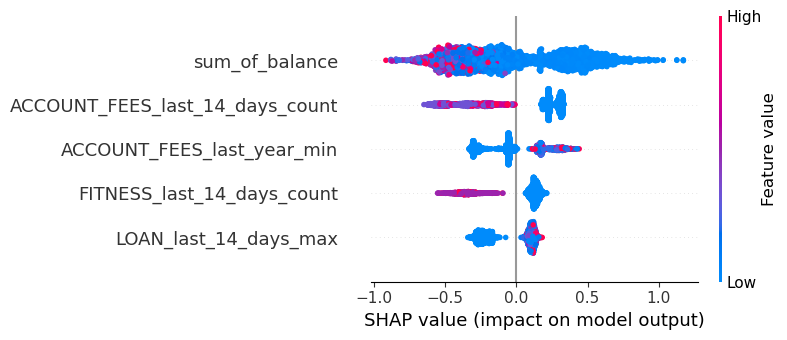

In [232]:
shap.summary_plot(shap_values, X_holdout_standardized, max_display=5)

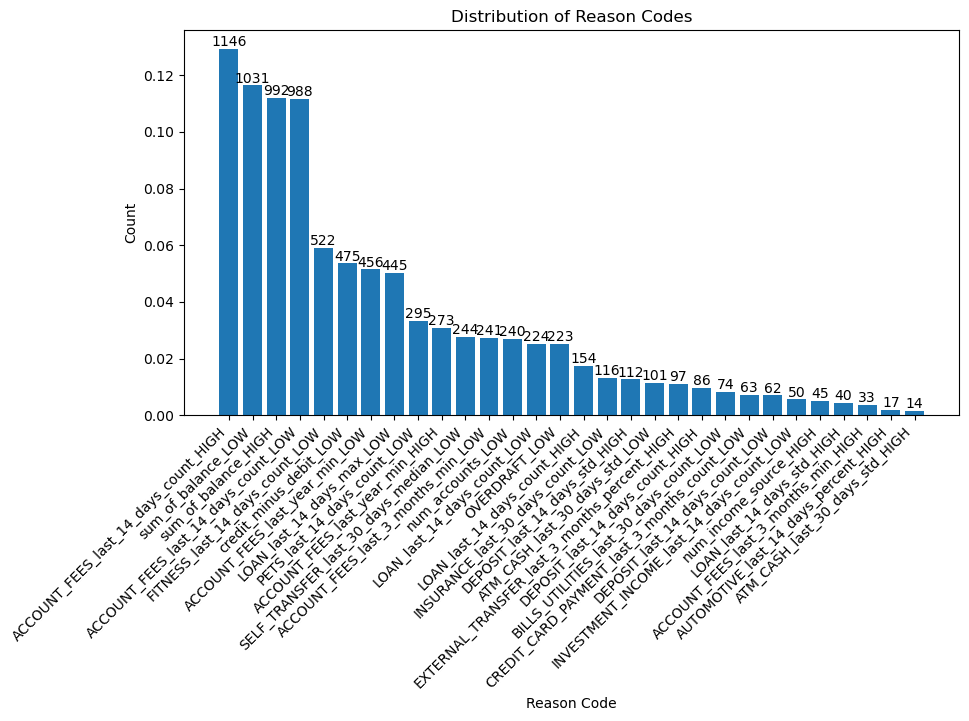

In [241]:
reason_codes_by_consumer_holdout = get_reason_codes(explainer, X_holdout_standardized, shap_values)
plot_reason_codes_distribution(reason_codes_by_consumer_holdout)

In [191]:
model = CatBoostClassifier(verbose=0)
model.fit(final_X_train_resampled, final_y_train_resampled)
preds = model.predict(X_holdout_standardized)
probs = model.predict_proba(X_holdout_standardized)